In [1]:
import os
import sys
from statistics import mean
os.chdir('/n/netscratch/shakhnovich_lab/Lab/jiojeong/scripts')
import pandas as pd
from scipy.stats import spearmanr, linregress
import math
from utils import percentage_of_complete_clusters_in_all_cluster_compositions, filter_incomplete_clusters_and_save_to_file, read_all_cluster_compositions, read_all_incomplete_cluster_compositions
from utils import read_complete_clusters, average_complete_clusters, average_counts_atom_type_final_frame
from utils import average_counts_atom_type_nth_frame
from utils import average_counts_atom_type_faster, read_complete_clusters_one_run
from utils import readlogfile, average_runs, readcluster, average_runs_only_COQ6
from utils import average_clusters, read_atom_type_dump
from utils import readmaxclustercomposition,  average_maxclustercomposition, max_cluster_process_data
from utils import *
from collections import defaultdict
import math
import glob
import re
from collections import deque
import pickle
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm


Utils module is being imported!


In [4]:
def get_subfolder_paths(folder_path):
    subfolder_paths = []
    for entry in os.listdir(folder_path):
        full_path = os.path.join(folder_path, entry)
        if os.path.isdir(full_path):
            subfolder_paths.append(full_path)
    return subfolder_paths

# this is a function that parses the bond/reaction information from the dump file
# the output is a list of tuples where each tuple is length 2
# first number of tuple contains the timestep 
# second number the bond information such as '1 18 1703' where the first number is the bond type, second is the atom1 (enzyme active site) and third is the atom2 (substrate)
# there's probably a way to make this more efficient, but that's for later
def parse_file_in_chunks(filename):
    time_steps = []
    bonds = []
    
    with open(filename, 'r') as file:
        window = deque(maxlen=10)  # Use deque for efficient sliding window
        buffer = []
        for line in file:
            window.append(line)
            
            if len(window) >= 2 and "ITEM: NUMBER OF ENTRIES" in window[-2]:
                next_line = line.strip()
                if next_line.isdigit() and int(next_line) != 0:
                    # Extract the timestep from the window
                    for w in window:
                        if "ITEM: TIMESTEP" in w:
                            timestep_index = window.index(w) + 1
                            if timestep_index < len(window):
                                time_steps.append(window[timestep_index].strip())
                    
                    # Extract the bond information
                    for _ in range(10):  # Increase buffer size to 10
                        try:
                            buffer.append(next(file))
                        except StopIteration:
                            break
                    
                    # Find the bond information line
                    for b in buffer:
                        if "ITEM: ENTRIES" in b:
                            bond_index = buffer.index(b) + 1
                            if bond_index < len(buffer):
                                bonds.append(buffer[bond_index].strip())
                    
                    buffer = []
    
    time_step_bond_pairs = list(zip(time_steps, bonds))
    return time_step_bond_pairs

def outer_parse_file_in_chunks(paths):
    time_step_bond_pairs = []
    for path in paths:
        filename = os.path.join(path, 'bond_data.txt')
        temp = parse_file_in_chunks(filename)
        time_step_bond_pairs.append(temp)
    
    return time_step_bond_pairs

def sort_key(item):
    first_number = int(item[0])
    third_number = int(item[1].split()[2])
    return (third_number, first_number)

# this is a function that maps the timestep to the frame number, basic math
def map_time_step_to_frame(time_step, min_time_step, max_time_step, min_frame, max_frame):
    # Ensure the time step is within the given range
    time_step = int(time_step)
    if time_step < min_time_step or time_step > max_time_step:
        raise ValueError("Time step out of range")
    
    # Calculate the corresponding frame using linear interpolation
    frame = min_frame + (time_step - min_time_step) * (max_frame - min_frame) / (max_time_step - min_time_step)
    
    return frame

# this is a function that creates a dictionary that maps an atom id to the type of atom it is (11~18 for substrate, 1~10 for enzyme HS and active site)
def create_index_to_name_dictionary(system_data_path, mode):
    if mode not in ["molecule", "atom"]:
        raise ValueError("Invalid mode. Choose either 'molecule' or 'atom'.")
    
    output = {}
    
    with open(system_data_path, 'r') as file:
        keyword_found = False
        keyword = "Atoms"
        
        for line in file:
            if keyword_found:
                parts = line.split()
                if len(parts) < 7:
                    continue
                
                atom_index = int(parts[0])  
                molecule_index = int(parts[1])
                name = int(parts[2])
                
                if(mode == 'molecule' and molecule_index not in output):
                    output[molecule_index] = name
                if (mode == 'atom'):
                    output[atom_index] = name
                
            elif keyword in line:
                keyword_found = True
            else:
                continue
    
    return output

def outer_create_index_to_name_dictionary(paths, mode):
    dicts = []
    for path in paths:
        system_data_path = os.path.join(path, 'system.data')
        temp = create_index_to_name_dictionary(system_data_path, mode)
        dicts.append(temp)
    return dicts

# this is a function that uses the "type dictionary" on the atoms involved in the bond and returns the atom types
def process_bonds(bond_string, type_dict):
    bond_ids = bond_string.split()
    if len(bond_ids) < 3:
        raise ValueError("Bond string does not contain enough integers")
    last_two_bonds = bond_ids[-2:]
    processed_bonds = [type_dict[int(bond_id)] for bond_id in last_two_bonds if int(bond_id) in type_dict]
    return processed_bonds

def read_atom_type_dump(file_path):
    '''Reads the file from the end until the line "ITEM: ATOMS id type x y z" is encountered.'''
    
    # Initialize an empty dictionary to store the data
    
    # Open the file and read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Iterate through the lines in reverse order
    for i, line in enumerate(reversed(lines)):
        if line.strip() == "ITEM: ATOMS id type x y z":
            index = len(lines) - 1 - i
            break
    else:
        raise ValueError("The line 'ITEM: ATOMS id type x y z' was not found in the file.")
    
    # Return the remaining lines after the target line
    return lines[index+1:]

def create_type_dictionary(result):
    # Create a defaultdict with an empty list as the default value
    atom_type_dict = defaultdict(list)
    for i in range(1, len(result)):
        parts = result[i].split()
        atom_index = int(parts[0])
        atom_type = int(parts[1])
        atom_type_dict[atom_type].append(atom_index)
    return atom_type_dict

def outer_create_type_dictionary(paths):
    dicts = []
    for path in paths:
        file_path = os.path.join(path, 'atomtype.*.dump')
        matching_files = glob.glob(file_path)
        result = read_atom_type_dump(matching_files[0])
        temp = create_type_dictionary(result)
        dicts.append(temp)
    return dicts

# parser helper function
def check_last_two_integers(val, target):
    bond_ids = val.split()
    if len(bond_ids) < 3:
        return False
    last_two_bonds = bond_ids[-2:]
    return any(int(bond_id) in target for bond_id in last_two_bonds)

# Changing the enzyme active site ID X to its corresponding enzyme HS ID Y
# Y = X - 1 based on how we defined things in system.data
# this is needed in order to have a consistent IDing scheme together with clustering analysis
def decrement_second_value(tuples_list):
    updated_list = []
    for item in tuples_list:
        first, second, third = item
        parts = second.split()
        parts[1] = str(int(parts[1]) - 1)  # Decrement the second value
        updated_second = ' '.join(parts)
        updated_list.append((first, updated_second, third))
    return updated_list


# just a function that reads the clusterList_corrected.dat file and returns the data
def parse_clusters(file_path):
    with open(file_path, 'r') as file:
        data = []
        for line in file:
            items = re.findall(r'\d+|\{[^\}]+\}', line)
            clusters = []
            for item in items:
                if item.startswith('{') and item.endswith('}'):
                    cluster_set = set(map(int, item[1:-1].split()))
                    clusters.append(cluster_set)
                else:
                    clusters.append({int(item)})
            data.append(clusters)
    return data

# this is the main function that tracks the clusters across time
# continuity_threshold dictates that cluster c at time t is the same as some cluster at time t+1 if they share at least 50% of the same atoms
# grace_period is needed to handle cases where a cluster of size 5 disappears by going below the min_cluster_size but promptly reappears in the next frame
def track_clusters(data, continuity_threshold=0.5, min_cluster_size=5, grace_period=2):
    cluster_history = {}  # Track each cluster's evolution across time points
    current_ids = {}  # Track the ID of clusters at each time point
    inactive_clusters = {}  # Track clusters temporarily below the minimum size

    enzyme_history = defaultdict(lambda: [None] * len(data))  # Track cluster ID for each enzyme at each time step

    # Initialize IDs for the first time point
    time_0_clusters = data[0]
    for i, cluster in enumerate(time_0_clusters):
        if len(cluster) >= min_cluster_size:
            cluster_id = f"C{i}_T0"
            cluster_history[cluster_id] = {
                'atoms': [cluster] + [set()] * (len(data) - 1),  # Initialize with empty sets for all future frames
                'time_created': 0,
                'time_disappeared': None
            }
            current_ids[cluster_id] = cluster
            # Record cluster membership for each enzyme in this cluster
            for enzyme in cluster:
                enzyme_history[enzyme][0] = cluster_id

    # Process subsequent time points
    for t, clusters in enumerate(data[1:], start=1):
        next_ids = {}  # IDs for clusters at time t+1
        used_ids = set()

        for cluster in clusters:
            if len(cluster) < min_cluster_size:
                continue  # Skip clusters below the minimum size

            best_match_id = None
            best_overlap = 0

            # Search for best match in both active and inactive clusters
            candidates = {**current_ids, **inactive_clusters}
            for prev_id, prev_cluster in candidates.items():
                overlap = len(cluster.intersection(prev_cluster)) / max(len(prev_cluster), len(cluster))
                if overlap > best_overlap and overlap >= continuity_threshold:
                    best_overlap = overlap
                    best_match_id = prev_id

            if best_match_id:
                # Reactivate if it was in inactive_clusters
                if best_match_id in inactive_clusters:
                    del inactive_clusters[best_match_id]  # Remove from inactive state
                next_ids[best_match_id] = cluster
                cluster_history[best_match_id]['atoms'][t] = cluster  # Update composition at time t
                cluster_history[best_match_id]['time_disappeared'] = None
                used_ids.add(best_match_id)
                # Record cluster membership for each enzyme in this cluster
                for enzyme in cluster:
                    enzyme_history[enzyme][t] = best_match_id
            else:
                # Assign a new ID for unmatched clusters of sufficient size
                new_id = f"C{len(cluster_history)}_T{t}"
                next_ids[new_id] = cluster
                cluster_history[new_id] = {
                    'atoms': [set()] * t + [cluster] + [set()] * (len(data) - t - 1),
                    'time_created': t,
                    'time_disappeared': None
                }
                # Record cluster membership for each enzyme in this new cluster
                for enzyme in cluster:
                    enzyme_history[enzyme][t] = new_id

        # Handle clusters that were active in the previous time step
        for prev_id in current_ids:
            if prev_id not in used_ids:
                # Move to inactive if within grace period
                if prev_id in inactive_clusters:
                    inactive_duration = t - cluster_history[prev_id]['time_disappeared']
                    if inactive_duration >= grace_period:
                        # Permanently disappear if grace period is exceeded
                        cluster_history[prev_id]['time_disappeared'] = t
                        del inactive_clusters[prev_id]  # Remove after grace period
                else:
                    # Set as temporarily disappeared
                    cluster_history[prev_id]['time_disappeared'] = t
                    inactive_clusters[prev_id] = current_ids[prev_id]
                    cluster_history[prev_id]['atoms'][t] = set()  # Record empty set for disappearance
                    
        current_ids = next_ids  # Move to next time point

    return cluster_history, enzyme_history

def find_merged_clusters(cluster_history, enzyme_history):
    merged_clusters = {}
    for cluster_id, history in cluster_history.items():
        if history['time_disappeared'] is not None:
            disappeared_time = history['time_disappeared']
            last_composition = history['atoms'][disappeared_time - 1]
            enzyme_counts = defaultdict(int)
            
            # Count the occurrences of each enzyme in clusters at time t
            for enzyme in last_composition:
                if enzyme_history[enzyme][disappeared_time] is not None:
                    enzyme_counts[enzyme_history[enzyme][disappeared_time]] += 1
            
            # Determine if more than 50% of the enzymes belong to the same cluster
            total_enzymes = len(last_composition)
            for cluster, count in enzyme_counts.items():
                if count > total_enzymes / 2:
                    merged_clusters[cluster_id] = (disappeared_time, cluster)
                    break
    
    return merged_clusters
    
def outer_track_clusters(paths):
    cluster_histories = []
    enzyme_histories = []
    merge_histories = []
    for path in paths:
        file_path = os.path.join(path, 'cluster_results_skip_first_frame', 'clusterList_corrected.dat')
        clusters = parse_clusters(file_path)
        cluster_history, enzyme_history = track_clusters(clusters)
        for key, value in cluster_history.items():
            value['sizes'] = [len(atom_array) for atom_array in value['atoms']]
        sorted_cluster_history = dict(sorted(cluster_history.items(), key=lambda item: item[1]['sizes'][-1], reverse=True))
        merged_clusters = find_merged_clusters(sorted_cluster_history, enzyme_history)
        cluster_histories.append(sorted_cluster_history)
        enzyme_histories.append(enzyme_history)
        merge_histories.append(merged_clusters)

    return cluster_histories, enzyme_histories, merge_histories


def run_analyis(folder_path, paths, target_type = [18]):
    temp_path = os.path.join(folder_path, 'save_time.pkl')
    save_path = os.path.expanduser(temp_path)

    if os.path.exists(save_path):
        with open(save_path, 'rb') as f:
            time_step_bond_pairs = pickle.load(f)
    else:
        time_step_bond_pairs= outer_parse_file_in_chunks(paths)
        with open(save_path, 'wb') as f:
            pickle.dump(time_step_bond_pairs, f)
    

    sorted_pairs = [sorted(i, key=sort_key) for i in time_step_bond_pairs]
    time_step_bond_pairs_unique = []
    for s in sorted_pairs:
        temp = []
        for i, entry in enumerate(s):
            if i == 0 or entry[1] != s[i - 1][1]:
                temp.append(entry)
        time_step_bond_pairs_unique.append(temp)

    WT_dicts = outer_create_index_to_name_dictionary(paths, 'atom')

    mapped_pairs_WT = []
    for i, sim in enumerate(time_step_bond_pairs_unique):
        temp = []
        for entry in sim:
            time_step = entry[0]
            bond = entry[1]
            frame = math.floor(map_time_step_to_frame(time_step, min_time_step, max_time_step, min_frame, max_frame))
            processed_bonds = process_bonds(bond, WT_dicts[i])
            temp.append((frame, bond, processed_bonds))
        mapped_pairs_WT.append(temp)

    atom_type_dumps_WT = outer_create_type_dictionary(paths)

    # target_list = []
    # for i in atom_type_dumps_WT:
    #     for j in target_type:
    #         target_list.append(i[j])

    target_list = []
    for i in atom_type_dumps_WT:
        temp = []
        for j in target_type:
            temp.extend(i[j])
        target_list.append(temp)

    # Filter mapped_pairs so that it only contains reactions that involve target atoms
    mapped_pairs_target_WT = []
    for i, sim in enumerate(mapped_pairs_WT):
        temp = []
        for entry in sim:
            if check_last_two_integers(entry[1], target_list[i]):
                temp.append(entry)
        mapped_pairs_target_WT.append(temp)

    sorted_mapped_pairs_target_WT = []
    for i in mapped_pairs_target_WT:
        temp = sorted(i, key=lambda x: int(x[1].split()[2]))
        temp = decrement_second_value(temp)
        sorted_mapped_pairs_target_WT.append(temp)
        
    cluster_histories_WT, enzyme_histories_WT, merge_histories_WT = outer_track_clusters(paths)

    incomplete_targets = []
    for sim in sorted_mapped_pairs_target_WT:
        temp = []
        target_counts = defaultdict(int)
        for entry in sim:
            first, second, third = entry
            target = int(second.split()[2])
            target_counts[target] += 1
        for target, count in target_counts.items():
            if count != 7:
                temp.append(target)
        incomplete_targets.append(temp)


    print("incomplete_targets:", incomplete_targets)

    updated_data_with_clusters = []

    # this is a block of code that adds the cluster information to the updated_data
    # cluster ID, cluster composition, cluster size, and whether the cluster is complete or not will be added
    for index1, sim in enumerate(sorted_mapped_pairs_target_WT):
        temp = []
        for index2, entry in enumerate(sim):
            first, second, third = entry
            parts = second.split()
            enzyme = parts[1]
            frame = first
            #print(f"Frame: {frame}, Enzyme: {enzyme}"
            enzyme_which_cluster = enzyme_histories_WT[index1][int(enzyme)][int(frame)-1]
            #print(f"Cluster ID: {enzyme_which_cluster}")

            if enzyme_which_cluster is not None:
                cluster_atoms = cluster_histories_WT[index1][enzyme_which_cluster]['atoms'][int(frame)-1]
                #print(f"Cluster atoms: {cluster_atoms}, Size: {len(cluster_atoms)}")
                cluster_atoms_type = [WT_dicts[index1][i] for i in cluster_atoms]
                #print(f"Cluster atoms type: {cluster_atoms_type}")
                complete_cluster = False
                if {1, 2, 3, 4, 5}.issubset(cluster_atoms_type):
                    complete_cluster = True
                new_tuple = (first, second, third, enzyme_which_cluster, cluster_atoms, len(cluster_atoms), complete_cluster)
            else:
                cluster_atoms = None
                #print(f"Cluster atoms: {cluster_atoms}, Size: 0")
                new_tuple = (first, second, third, enzyme_which_cluster, cluster_atoms, 0, False)
            temp.append(new_tuple)
        updated_data_with_clusters.append(temp)
    
    # seeing if any reactions happened in an incomplete cluster
    count_incomplete = 0
    count_total = 0
    for sim in updated_data_with_clusters: 
        for i in sim:
            count_total += 1
            first, second, third, cluster_id, cluster_atoms, cluster_size, complete_cluster = i
            if complete_cluster == False and cluster_size > 0:
                count_incomplete += 1

    print("how many meaningful reactions happened in an incomplete cluster?", count_incomplete)
    print("total number of reactions", count_total)


    # Initialize a dictionary to store data for each CoQ1. I said enzyme on accident but too complicated to fix 
    coq1_data = []

    # Group data by CoQ1
    for sim in updated_data_with_clusters:
        sim_dict = defaultdict(list)
        for item in sim:
            frame, second, third, enzyme_which_cluster, cluster_atoms, cluster_size, complete_cluster = item
            enzyme = second.split()[2]
            sim_dict[enzyme].append((frame, enzyme_which_cluster, cluster_size))
        coq1_data.append(sim_dict)

    # Lists to store the metrics for histograms
    frame_differences = []
    unique_cluster_ids_list = []
    unique_cluster_ids_list_after_accounting_for_cluster_merging = []
    interruptions_list = []
    all_cluster_sizes = []
    mean_cluster_sizes = []
    pairwise_frame_differences = []
    pairwise_frame_differences_only_when_1_unique_cluster = []
    cutoff = 10
    large_diffs = []
    diff_0 = []
    diff_1 = []
    diff_2 = []
    diff_3 = []
    diff_4 = []
    diff_5 = []


    for index, sim_data in enumerate(coq1_data):
        for coq1, data in sim_data.items():
            
            frames = [item[0] for item in data]
            cluster_ids = [item[1] for item in data if item[1] is not None]

            unique_cluster_ids = len(set(cluster_ids))
            unique_cluster_ids_list.append(unique_cluster_ids)

            # this is where we account for the cluster merging
            for i, id in enumerate(cluster_ids):
                if id in merge_histories_WT[index]:
                    new_id = merge_histories_WT[index][id][1]
                    cluster_ids[i] = new_id
            
            
            cluster_sizes = [item[2] for item in data]

            # Collect all non-zero cluster sizes
            all_cluster_sizes.extend([size for size in cluster_sizes if size != 0])

            # Calculate the difference between the largest and smallest frame
            frame_difference = max(frames) - min(frames)
            frame_differences.append(frame_difference)

            # Calculate the number of different cluster IDs
            unique_cluster_ids_after_merging = len(set(cluster_ids))
            unique_cluster_ids_list_after_accounting_for_cluster_merging.append(unique_cluster_ids_after_merging)

            # Calculate the number of interruptions in the sequence of cluster IDs
            interruptions = 0
            previous_cluster_id = None
            for cluster_id in cluster_ids:
                if previous_cluster_id is not None and cluster_id != previous_cluster_id:
                    interruptions += 1
                previous_cluster_id = cluster_id
            interruptions_list.append(interruptions)

            # Calculate the mean cluster size excluding zeros
            non_zero_cluster_sizes = [size for size in cluster_sizes if size != 0]
            mean_cluster_size = sum(non_zero_cluster_sizes) / len(non_zero_cluster_sizes) if non_zero_cluster_sizes else 0
            mean_cluster_sizes.append(mean_cluster_size)

            # Calculate pairwise consecutive frame differences
            frames_sorted = sorted(frames)
            pairwise_diffs = [frames_sorted[i+1] - frames_sorted[i] for i in range(len(frames_sorted) - 1)]
            pairwise_frame_differences.extend(pairwise_diffs)

            if len(pairwise_diffs) == 6:
                diff_0.append(pairwise_diffs[0])
                diff_1.append(pairwise_diffs[1])
                diff_2.append(pairwise_diffs[2])
                diff_3.append(pairwise_diffs[3])
                diff_4.append(pairwise_diffs[4])
                diff_5.append(pairwise_diffs[5])
            

            for i in range(len(pairwise_diffs)):
                if pairwise_diffs[i] > cutoff:
                    large_diffs.append(i)

            if (unique_cluster_ids_after_merging == 1):
                pairwise_frame_differences_only_when_1_unique_cluster.extend(pairwise_diffs)
            

            if (unique_cluster_ids != unique_cluster_ids_after_merging):
                print(f"CoQ1 ID: {coq1} has different unique cluster IDs before and after merging")

    
    # Histogram for frame differences
    plt.figure(figsize=(10, 5))
    plt.hist(frame_differences, bins=20, color='blue', edgecolor='black')
    plt.title('Frame Difference between Last and First Reactions of a Became-CoQ1-Atom')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

    # Histogram for number of unique cluster IDs
    plt.figure(figsize=(10, 5))
    plt.hist(unique_cluster_ids_list, bins=20, color='green', edgecolor='black')
    plt.title('Number of Unique Cluster IDs (Excluding None) Containing Enzymes that reacted with a Became-CoQ1-Atom')
    plt.xlabel('Unique Cluster IDs')
    plt.ylabel('Frequency')
    plt.show()

    # # Histogram for number of interruptions
    # plt.figure(figsize=(10, 5))
    # plt.hist(interruptions_list, bins=20, color='red', edgecolor='black')
    # plt.title('Number of Interruptions in Cluster ID sequence')
    # plt.xlabel('Interruptions')
    # plt.ylabel('Frequency')
    # plt.show()

    # Histogram for all cluster sizes (excluding zeros)
    plt.figure(figsize=(10, 5))
    plt.hist(all_cluster_sizes, bins=20, color='purple', edgecolor='black')
    plt.title('All Sizes (Excluding Zeros) of Clusters (size >= 5) Containing an Enzyme that reacted with a Became-CoQ1-Atom')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.show()


    weights = 1.0 / np.array(all_cluster_sizes)

    plt.figure(figsize=(10, 5))
    plt.hist(all_cluster_sizes, bins=20, color='purple', edgecolor='black', weights=weights)
    plt.title('Normalized Frequency of Cluster Sizes (size >= 5) Containing an Enzyme that Reacted with a Became-CoQ1-Atom')
    plt.xlabel('Cluster Size')
    plt.ylabel('Normalized Frequency')
    plt.show()


    cluster_sizes = []

    for path in paths:
        cluster_dist_path = os.path.join(path, 'cluster_results_skip_first_frame', 'clusterDist.dat')
        with open(cluster_dist_path, 'r') as file:
            for line in file:
                sizes = list(map(int, line.split()))
                cluster_sizes.extend(sizes)

    # Filter out cluster sizes that are less than 5
    filtered_cluster_sizes = [size for size in cluster_sizes if size >= 5]

    weights = np.ones_like(filtered_cluster_sizes) / len(paths)
    # Plot the histogram for the filtered cluster sizes
    plt.figure(figsize=(10, 5))
    plt.hist(filtered_cluster_sizes, bins=20, color='red', edgecolor='black', weights=weights)
    plt.title('Histogram of Cluster Sizes (Excluding Sizes Less Than 5): Entire Simulation')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.show()

    all_cluster_sizes_hist, bins = np.histogram(all_cluster_sizes, bins=20, weights=1.0 / np.array(all_cluster_sizes))
    filtered_cluster_sizes_hist, _ = np.histogram(filtered_cluster_sizes, bins=bins, weights=np.ones_like(filtered_cluster_sizes) / len(paths))

    # Avoid division by zero
    filtered_cluster_sizes_hist[filtered_cluster_sizes_hist == 0] = np.nan

    # Calculate the ratio
    ratio_hist = all_cluster_sizes_hist / filtered_cluster_sizes_hist


    # dont divide by cluster size
    all_cluster_sizes_hist, bins = np.histogram(all_cluster_sizes, bins=20)
    filtered_cluster_sizes_hist, _ = np.histogram(filtered_cluster_sizes, bins=bins)

    # Avoid division by zero
    filtered_cluster_sizes_hist[filtered_cluster_sizes_hist == 0] = np.nan

    # Calculate the ratio
    ratio_hist = all_cluster_sizes_hist / filtered_cluster_sizes_hist


    # Plot the ratio histogram
    plt.figure(figsize=(10, 5))
    plt.bar(bins[:-1], ratio_hist, width=np.diff(bins), color='blue', edgecolor='black')
    plt.title('Ratio of Purple Histogram to Red Histogram')
    plt.xlabel('Cluster Size')
    plt.ylabel('Ratio')
    plt.show()

    weights = np.array(filtered_cluster_sizes) / len(paths)
    plt.figure(figsize=(10, 5))
    plt.hist(filtered_cluster_sizes, bins=20, color='red', edgecolor='black', weights=weights)
    plt.title('Histogram of theoretical reaction num for cluster size: Entire Simulation')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.show()


    # Histogram for mean cluster sizes
    plt.figure(figsize=(10, 5))
    plt.hist(mean_cluster_sizes, bins=20, color='orange', edgecolor='black')
    plt.title('Mean Sizes (Excluding Zeros) of Clusters (size >= 5) Containing an Enzyme that reacted with a Became-CoQ1-Atom')
    plt.xlabel('Mean Cluster Size')
    plt.ylabel('Frequency')
    plt.show()

    # Histogram for pairwise consecutive frame differences
    plt.figure(figsize=(10, 5))
    plt.hist(pairwise_frame_differences, bins=89, color='cyan', edgecolor='black')
    plt.title('Timeframe Differences between Consecutive Reactions of a Became-CoQ1-Atom')
    plt.xlabel('Frame Difference')
    plt.xticks(range(0, max(pairwise_frame_differences) + 1, 5))
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(large_diffs, bins=89, color='magenta', edgecolor='black')
    plt.title('Index if Frame Difference between Consecutive Reactions of a Became-CoQ1-Atom is Greater than 10. Max index 5')
    plt.xlabel('Index')
    plt.xticks([0, 1, 2, 3, 4, 5])    
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(diff_0, bins=20, color='magenta', edgecolor='black')
    plt.title('Frame Difference between 2nd and 1st reaction for a CoQ1')
    plt.xlabel('Index')
    plt.xticks(range(0, 101, 5))
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(diff_1, bins=20, color='magenta', edgecolor='black')
    plt.title('Frame Difference between 3rd and 2nd reaction for a CoQ1')
    plt.xlabel('Index')
    plt.xticks(range(0, 101, 5))
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(diff_2, bins=20, color='magenta', edgecolor='black')
    plt.title('Frame Difference between 4th and 3rd reaction for a CoQ1')
    plt.xlabel('Index')
    plt.xticks(range(0, 101, 5))
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(diff_3, bins=20, color='magenta', edgecolor='black')
    plt.title('Frame Difference between 5th and 4th reaction for a CoQ1')
    plt.xlabel('Index')
    plt.xticks(range(0, 101, 5))
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(diff_4, bins=20, color='magenta', edgecolor='black')
    plt.title('Frame Difference between 6th and 5th reaction for a CoQ1')
    plt.xlabel('Index')
    plt.xticks(range(0, 101, 5))
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(diff_5, bins=20, color='magenta', edgecolor='black')
    plt.title('Frame Difference between 7th(final) and 6th reaction for a CoQ1')
    plt.xlabel('Index')
    plt.xticks(range(0, 101, 5))
    plt.ylabel('Frequency')
    plt.show()

#version with frame
def compare_channeling_frame_version(WT_folder_path, WT_paths, no_interaction_folder_path, no_interaction_paths, target_type = [18]):
    paths_list = [WT_paths, no_interaction_paths]
    folder_paths = [WT_folder_path, no_interaction_folder_path]
    result = []
    for i, paths in enumerate(paths_list):
        temp_path = os.path.join(folder_paths[i], 'save_time.pkl')
        save_path = os.path.expanduser(temp_path)

        if os.path.exists(save_path):
            with open(save_path, 'rb') as f:
                time_step_bond_pairs = pickle.load(f)
        else:
            time_step_bond_pairs= outer_parse_file_in_chunks(paths)
            with open(save_path, 'wb') as f:
                pickle.dump(time_step_bond_pairs, f)
        

        sorted_pairs = [sorted(i, key=sort_key) for i in time_step_bond_pairs]
        time_step_bond_pairs_unique = []
        for s in sorted_pairs:
            temp = []
            for i, entry in enumerate(s):
                if i == 0 or entry[1] != s[i - 1][1]:
                    temp.append(entry)
            time_step_bond_pairs_unique.append(temp)

        WT_dicts = outer_create_index_to_name_dictionary(paths, 'atom')

        mapped_pairs_WT = []
        for i, sim in enumerate(time_step_bond_pairs_unique):
            temp = []
            for entry in sim:
                time_step = entry[0]
                bond = entry[1]
                # version with frame
                frame = math.floor(map_time_step_to_frame(time_step, min_time_step, max_time_step, min_frame, max_frame))
                processed_bonds = process_bonds(bond, WT_dicts[i])
                temp.append((frame, bond, processed_bonds))
            mapped_pairs_WT.append(temp)

        atom_type_dumps_WT = outer_create_type_dictionary(paths)

        # target_list = []
        # for i in atom_type_dumps_WT:
        #     for j in target_type:
        #         target_list.append(i[j])

        target_list = []
        for i in atom_type_dumps_WT:
            temp = []
            for j in target_type:
                temp.extend(i[j])
            target_list.append(temp)

        # Filter mapped_pairs so that it only contains reactions that involve target atoms
        mapped_pairs_target_WT = []
        for i, sim in enumerate(mapped_pairs_WT):
            temp = []
            for entry in sim:
                if check_last_two_integers(entry[1], target_list[i]):
                    temp.append(entry)
            mapped_pairs_target_WT.append(temp)

        sorted_mapped_pairs_target_WT = []
        for i in mapped_pairs_target_WT:
            temp = sorted(i, key=lambda x: int(x[1].split()[2]))
            temp = decrement_second_value(temp)
            sorted_mapped_pairs_target_WT.append(temp)
            
        cluster_histories_WT, enzyme_histories_WT, merge_histories_WT = outer_track_clusters(paths)

        incomplete_targets = []
        for sim in sorted_mapped_pairs_target_WT:
            temp = []
            target_counts = defaultdict(int)
            for entry in sim:
                first, second, third = entry
                target = int(second.split()[2])
                target_counts[target] += 1
            for target, count in target_counts.items():
                if count != 7:
                    temp.append(target)
            incomplete_targets.append(temp)


        updated_data_with_clusters = []

        # this is a block of code that adds the cluster information to the updated_data
        # cluster ID, cluster composition, cluster size, and whether the cluster is complete or not will be added
        for index1, sim in enumerate(sorted_mapped_pairs_target_WT):
            temp = []
            for index2, entry in enumerate(sim):
                first, second, third = entry
                parts = second.split()
                enzyme = parts[1]
                frame = first
                #print(f"Frame: {frame}, Enzyme: {enzyme}"
                enzyme_which_cluster = enzyme_histories_WT[index1][int(enzyme)][int(frame)-1]
                #print(f"Cluster ID: {enzyme_which_cluster}")

                if enzyme_which_cluster is not None:
                    cluster_atoms = cluster_histories_WT[index1][enzyme_which_cluster]['atoms'][int(frame)-1]
                    #print(f"Cluster atoms: {cluster_atoms}, Size: {len(cluster_atoms)}")
                    cluster_atoms_type = [WT_dicts[index1][i] for i in cluster_atoms]
                    #print(f"Cluster atoms type: {cluster_atoms_type}")
                    complete_cluster = False
                    if {1, 2, 3, 4, 5}.issubset(cluster_atoms_type):
                        complete_cluster = True
                    new_tuple = (first, second, third, enzyme_which_cluster, cluster_atoms, len(cluster_atoms), complete_cluster)
                else:
                    cluster_atoms = None
                    #print(f"Cluster atoms: {cluster_atoms}, Size: 0")
                    new_tuple = (first, second, third, enzyme_which_cluster, cluster_atoms, 0, False)
                temp.append(new_tuple)
            updated_data_with_clusters.append(temp)
        
        # seeing if any reactions happened in an incomplete cluster
        count_incomplete = 0
        count_total = 0
        for sim in updated_data_with_clusters: 
            for i in sim:
                count_total += 1
                first, second, third, cluster_id, cluster_atoms, cluster_size, complete_cluster = i
                if complete_cluster == False and cluster_size > 0:
                    count_incomplete += 1



        # Initialize a dictionary to store data for each CoQ1. I said enzyme on accident but too complicated to fix 
        coq1_data = []

        # Group data by CoQ1
        for sim in updated_data_with_clusters:
            sim_dict = defaultdict(list)
            for item in sim:
                frame, second, third, enzyme_which_cluster, cluster_atoms, cluster_size, complete_cluster = item
                enzyme = second.split()[2]
                sim_dict[enzyme].append((frame, enzyme_which_cluster, cluster_size))
            coq1_data.append(sim_dict)

        # Lists to store the metrics for histograms
        frame_differences = []
        unique_cluster_ids_list = []
        unique_cluster_ids_list_after_accounting_for_cluster_merging = []
        interruptions_list = []
        all_cluster_sizes = []
        mean_cluster_sizes = []
        pairwise_frame_differences = []
        pairwise_frame_differences_only_when_1_unique_cluster = []
        cutoff = 10
        large_diffs = []
        diff_0 = []
        diff_1 = []
        diff_2 = []
        diff_3 = []
        diff_4 = []
        diff_5 = []


        for index, sim_data in enumerate(coq1_data):
            for coq1, data in sim_data.items():
                
                frames = [item[0] for item in data]
                cluster_ids = [item[1] for item in data if item[1] is not None]

                unique_cluster_ids = len(set(cluster_ids))
                unique_cluster_ids_list.append(unique_cluster_ids)

                # this is where we account for the cluster merging
                for i, id in enumerate(cluster_ids):
                    if id in merge_histories_WT[index]:
                        new_id = merge_histories_WT[index][id][1]
                        cluster_ids[i] = new_id
                
                
                cluster_sizes = [item[2] for item in data]

                # Collect all non-zero cluster sizes
                all_cluster_sizes.extend([size for size in cluster_sizes if size != 0])

                # Calculate the difference between the largest and smallest frame
                frame_difference = max(frames) - min(frames)
                frame_differences.append(frame_difference)

                # Calculate the number of different cluster IDs
                unique_cluster_ids_after_merging = len(set(cluster_ids))
                unique_cluster_ids_list_after_accounting_for_cluster_merging.append(unique_cluster_ids_after_merging)

                # Calculate the number of interruptions in the sequence of cluster IDs
                interruptions = 0
                previous_cluster_id = None
                for cluster_id in cluster_ids:
                    if previous_cluster_id is not None and cluster_id != previous_cluster_id:
                        interruptions += 1
                    previous_cluster_id = cluster_id
                interruptions_list.append(interruptions)

                # Calculate the mean cluster size excluding zeros
                non_zero_cluster_sizes = [size for size in cluster_sizes if size != 0]
                mean_cluster_size = sum(non_zero_cluster_sizes) / len(non_zero_cluster_sizes) if non_zero_cluster_sizes else 0
                mean_cluster_sizes.append(mean_cluster_size)

                # Calculate pairwise consecutive frame differences
                frames_sorted = sorted(frames)
                pairwise_diffs = [frames_sorted[i+1] - frames_sorted[i] for i in range(len(frames_sorted) - 1)]
                pairwise_frame_differences.extend(pairwise_diffs)

                if len(pairwise_diffs) == 6:
                    diff_0.append(pairwise_diffs[0])
                    diff_1.append(pairwise_diffs[1])
                    diff_2.append(pairwise_diffs[2])
                    diff_3.append(pairwise_diffs[3])
                    diff_4.append(pairwise_diffs[4])
                    diff_5.append(pairwise_diffs[5])
                

                for i in range(len(pairwise_diffs)):
                    if pairwise_diffs[i] > cutoff:
                        large_diffs.append(i)

                if (unique_cluster_ids_after_merging == 1):
                    pairwise_frame_differences_only_when_1_unique_cluster.extend(pairwise_diffs)
                


        result.append(pairwise_frame_differences)
    return result
    
    
def make_step_start_from_zero(df):
    subtract = df.index[0]
    df.index = df.index - subtract

def calculate_ratio_and_error_with_global_correlation(mean_cond1, var_cond1, mean_cond2, var_cond2, threshold=5):
    """
    Calculate ratio and error using global correlation structure
    """
    ratio = pd.DataFrame(np.nan, index=mean_cond1.index, columns=mean_cond1.columns)
    error_ratio = pd.DataFrame(np.nan, index=mean_cond1.index, columns=mean_cond1.columns)

    condition_mask = (mean_cond1 > threshold) | (mean_cond2 > threshold)
    
    for col in mean_cond1.columns:
        valid_mean1 = mean_cond1[col][condition_mask[col]]
        valid_mean2 = mean_cond2[col][condition_mask[col]]
        valid_var1 = var_cond1[col][condition_mask[col]]
        valid_var2 = var_cond2[col][condition_mask[col]]
        
        if len(valid_mean1) > 0:
            # Calculate global correlation between the two series
            correlation = valid_mean1.corr(valid_mean2)
            
            # Calculate ratio
            valid_ratio = valid_mean1 / valid_mean2
            
            # Calculate standard deviations
            sigma1 = np.sqrt(valid_var1)
            sigma2 = np.sqrt(valid_var2)
            
            # Error calculation with global correlation
            valid_error_ratio = valid_ratio * np.sqrt(
                (sigma1 / valid_mean1) ** 2 + 
                (sigma2 / valid_mean2) ** 2 - 
                2 * correlation*sigma1*sigma2  / (valid_mean1 * valid_mean2) #covariance = correlation * sigma1 * sigma2
            )
            
            # Assign back to full dataframe
            ratio[col][condition_mask[col]] = valid_ratio
            error_ratio[col][condition_mask[col]] = valid_error_ratio
    
    return ratio, error_ratio

def get_final_ratio_and_error(ratio_df, error_df, column='f_bondc6[2]', window=50):
    """
    Get the final stable ratio and error by averaging over the last window points
    """
    # Get the final window of data
    final_ratio = ratio_df[column].tail(window).mean()
    final_error = error_df[column].tail(window).mean()
    return final_ratio, final_error

def get_max_ratio_and_error(ratio_df, error_df, column='f_bondc6[2]'):
    """
    Get the maximum ratio and the corresponding error in the same row,
    only considering rows where the ratio exceeds the threshold.
    """

    # Find the maximum ratio and its corresponding error
    max_ratio = ratio_df[column].max()
    max_index = ratio_df[column].idxmax()
    corresponding_error = error_df.loc[max_index, column]

    return max_ratio, corresponding_error

def get_mean_ratio_and_error(ratio_df, column='f_bondc6[2]'):
    """
    Get the mean ratio and the mean error over the entire dataframe.
    """
    # Calculate the mean ratio and mean error
    mean_ratio = ratio_df[column].mean()
    variance_ratio = ratio_df[column].var()
    
    return mean_ratio, variance_ratio

#version with actual time differences
def compare_channeling(WT_folder_path, WT_paths, no_interaction_folder_path, no_interaction_paths, min_time = 0, target_type = [13, 14, 15, 16, 17, 18]):
    paths_list = [WT_paths, no_interaction_paths]
    folder_paths = [WT_folder_path, no_interaction_folder_path]
    result = []
    for i, paths in enumerate(paths_list):
        temp_path = os.path.join(folder_paths[i], 'save_time.pkl')
        save_path = os.path.expanduser(temp_path)

        if os.path.exists(save_path):
            with open(save_path, 'rb') as f:
                time_step_bond_pairs = pickle.load(f)
        else:
            time_step_bond_pairs= outer_parse_file_in_chunks(paths)
            with open(save_path, 'wb') as f:
                pickle.dump(time_step_bond_pairs, f)
        

        sorted_pairs = [sorted(i, key=sort_key) for i in time_step_bond_pairs]
        time_step_bond_pairs_unique = []
        for s in sorted_pairs:
            temp = []
            for i, entry in enumerate(s):
                if i == 0 or entry[1] != s[i - 1][1]:
                    temp.append(entry)
            time_step_bond_pairs_unique.append(temp)

        WT_dicts = outer_create_index_to_name_dictionary(paths, 'atom')

        mapped_pairs_WT = []
        for i, sim in enumerate(time_step_bond_pairs_unique):
            temp = []
            for entry in sim:
                time_step = entry[0]
                bond = entry[1]
                processed_bonds = process_bonds(bond, WT_dicts[i])
                if int(time_step) > min_time:
                    temp.append((time_step, bond, processed_bonds))
            mapped_pairs_WT.append(temp)

        # print("length of mapped_pairs_WT:" + str(len(mapped_pairs_WT)))
        # l = 0 
        # for i in mapped_pairs_WT:
        #     l += len(i)
        # print("combined length of mapped_pairs_WT:" + str(l))

        atom_type_dumps_WT = outer_create_type_dictionary(paths)

        # print("length of atom_type_dumps_WT:" + str(len(atom_type_dumps_WT)))
        # l = 0 
        # for i in atom_type_dumps_WT:
        #     l += len(i)
        # print("combined length of atom_type_dumps_WT:" + str(l))

        # target_list = []
        # for i in atom_type_dumps_WT:
        #     for j in target_type:
        #         target_list.append(i[j])

        target_list = []
        for i in atom_type_dumps_WT:
            temp = []
            for j in target_type:
                temp.extend(i[j])
            target_list.append(temp)

        print(target_list[0])

        # print("length of target_list:" + str(len(target_list)))
        # l = 0 
        # for i in target_list:
        #     l += len(i)
        # print("combined length of target_list:" + str(l))

        # Filter mapped_pairs so that it only contains reactions that involve target atoms
        mapped_pairs_target_WT = []
        for i, sim in enumerate(mapped_pairs_WT):
            temp = []
            for entry in sim:
                if check_last_two_integers(entry[1], target_list[i]):
                    temp.append(entry)
            mapped_pairs_target_WT.append(temp)

        sorted_mapped_pairs_target_WT = []
        for i in mapped_pairs_target_WT:
            temp = sorted(i, key=lambda x: int(x[1].split()[2]))
            temp = decrement_second_value(temp)
            sorted_mapped_pairs_target_WT.append(temp)

        # print("length of sorted_mapped_pairs_target_WT:" + str(len(sorted_mapped_pairs_target_WT)))
        # l = 0 
        # for i in sorted_mapped_pairs_target_WT:
        #     l += len(i)
        # print("combined length of sorted_mapped_pairs_target_WT:" + str(l))


        # Initialize a dictionary to store data for each CoQ1. I said enzyme on accident but too complicated to fix 
        coq1_data = []

        # Group data by CoQ1
        for sim in sorted_mapped_pairs_target_WT:
            sim_dict = defaultdict(list)
            for item in sim:
                frame, second, third = item
                enzyme = second.split()[2]
                sim_dict[enzyme].append(int(frame))
            coq1_data.append(sim_dict)
        
        # print("length of coq1_data:" + str(len(coq1_data)))
        # l = 0 
        # for i in coq1_data:
        #     l += len(i)
        # print("combined length of coq1_data:" + str(l))
        print(coq1_data[0])

        # Lists to store the metrics for histograms
        frame_differences = []
        pairwise_frame_differences = []
        pairwise_frame_differences_only_when_1_unique_cluster = []

        for index, sim_data in enumerate(coq1_data):
            for coq1, frames in sim_data.items():
                
                # Calculate the difference between the largest and smallest frame
                frame_difference = max(frames) - min(frames)
                frame_differences.append(frame_difference)

                # Calculate pairwise consecutive frame differences
                frames_sorted = sorted(frames)
                pairwise_diffs = [frames_sorted[i+1] - frames_sorted[i] for i in range(len(frames_sorted) - 1)]
                pairwise_frame_differences.extend(pairwise_diffs)

        result.append(pairwise_frame_differences)
    return result

In [5]:
folder_path = '/n/shakfs1/users/jiojeong/simulations/20241122_metabolon_CoQ9_HSHS1KT_self_interaction_1KT_vary_kcat_new_dump'
path_02kcat = os.path.join(folder_path, '0.2kcat')
path_05kcat = os.path.join(folder_path, '0.5kcat')
path_1kcat = os.path.join(folder_path, '1kcat')
path_2kcat = os.path.join(folder_path, '2kcat')
path_5kcat = os.path.join(folder_path, '5kcat')
path_10kcat = os.path.join(folder_path, '10kcat_longer')

folder_02kcat_WT = os.path.join(path_02kcat, 'WT')
folder_05kcat_WT = os.path.join(path_05kcat, 'WT')
folder_1kcat_WT = os.path.join(path_1kcat, 'WT')
folder_2kcat_WT = os.path.join(path_2kcat, 'WT')
folder_5kcat_WT = os.path.join(path_5kcat, 'WT')
folder_10kcat_WT = os.path.join(path_10kcat, 'WT')

folder_02kcat_randomized = os.path.join(path_02kcat, 'randomized')
folder_05kcat_randomized = os.path.join(path_05kcat, 'randomized')
folder_1kcat_randomized = os.path.join(path_1kcat, 'randomized')
folder_2kcat_randomized = os.path.join(path_2kcat, 'randomized')
folder_5kcat_randomized = os.path.join(path_5kcat, 'randomized')
folder_10kcat_randomized = os.path.join(path_10kcat, 'randomized')

paths_02kcat_WT = get_subfolder_paths(os.path.join(path_02kcat, 'WT'))
paths_05kcat_WT = get_subfolder_paths(os.path.join(path_05kcat, 'WT'))
paths_1kcat_WT = get_subfolder_paths(os.path.join(path_1kcat, 'WT'))
paths_2kcat_WT = get_subfolder_paths(os.path.join(path_2kcat, 'WT'))
paths_5kcat_WT = get_subfolder_paths(os.path.join(path_5kcat, 'WT'))
paths_10kcat_WT = get_subfolder_paths(os.path.join(path_10kcat, 'WT'))


paths_02kcat_randomized = get_subfolder_paths(os.path.join(path_02kcat, 'randomized'))
paths_05kcat_randomized = get_subfolder_paths(os.path.join(path_05kcat, 'randomized'))
paths_1kcat_randomized = get_subfolder_paths(os.path.join(path_1kcat, 'randomized'))
paths_2kcat_randomized = get_subfolder_paths(os.path.join(path_2kcat, 'randomized'))
paths_5kcat_randomized = get_subfolder_paths(os.path.join(path_5kcat, 'randomized'))
paths_10kcat_randomized = get_subfolder_paths(os.path.join(path_10kcat, 'randomized'))


no_interaction_folder = '/n/shakfs1/users/jiojeong/simulations/20241112_metabolon_CoQ9_HSHS1KT_self_interaction_1KT_10kcat_new_dump/no_interaction'
paths_no_interaction = get_subfolder_paths(no_interaction_folder)

folder_ablation = '/n/shakfs1/users/jiojeong/simulations/20241017_CoQ_ablation'

path_range = range(1, 4)
base_path = "/n/shakfs1/users/jiojeong/simulations/20241017_CoQ_ablation/ablate_1-2"
paths_10kcat_ablate_12 = [f"{base_path}_{i}/" for i in path_range]

base_path = "/n/shakfs1/users/jiojeong/simulations/20241017_CoQ_ablation/ablate_5-20"
paths_10kcat_ablate_520 = [f"{base_path}_{i}/" for i in path_range]

enz_arr = [1, 2, 3, 4, 5]

In [6]:
base_path =  "/n/netscratch/shakhnovich_lab/Lab/jiojeong/simulations/20250224_randomly_shuffle_nodes_fixed_network/5kcat"
paths_5kcat_randomized_nodes_fixed_network = get_subfolder_paths(base_path)
mean_df_5kcat_randomized_nodes_fixed_network, var_df_5kcat_randomized_nodes_fixed_network = average_runs(paths_5kcat_randomized_nodes_fixed_network)

In [7]:
mean_df_1kcat_WT, var_df_1kcat_WT = average_runs(paths_1kcat_WT)
mean_df_1kcat_randomized, var_df_1kcat_randomized = average_runs(paths_1kcat_randomized)
mean_df_10kcat_WT, var_df_10kcat_WT = average_runs(paths_10kcat_WT)
mean_df_10kcat_randomized, var_df_10kcat_randomized = average_runs(paths_10kcat_randomized)
mean_df_0_2kcat_randomized, var_df_0_2kcat_randomized = average_runs(paths_02kcat_randomized)
mean_df_0_5kcat_randomized, var_df_0_5kcat_randomized = average_runs(paths_05kcat_randomized)
mean_df_2kcat_randomized, var_df_2kcat_randomized = average_runs(paths_2kcat_randomized)
mean_df_5kcat_randomized, var_df_5kcat_randomized = average_runs(paths_5kcat_randomized)
mean_df_0_2kcat_WT, var_df_0_2kcat_WT = average_runs(paths_02kcat_WT)
mean_df_0_5kcat_WT, var_df_0_5kcat_WT = average_runs(paths_05kcat_WT)
mean_df_2kcat_WT, var_df_2kcat_WT = average_runs(paths_2kcat_WT)
mean_df_5kcat_WT, var_df_5kcat_WT = average_runs(paths_5kcat_WT)
mean_df_no_interaction_10kcat, var_df_no_interaction_10kcat = average_runs(paths_no_interaction)
mean_df_10kcat_ablate_12, var_df_10kcat_ablate_12 = average_runs(paths_10kcat_ablate_12)
mean_df_10kcat_ablate_520, var_df_10kcat_ablate_520 = average_runs(paths_10kcat_ablate_520)


In [8]:
folder_path = "/n/netscratch/shakhnovich_lab/Lab/jiojeong/simulations/20250128_randomly_shuffle_nodes_except_COQ9"
folder_05kcat = os.path.join(folder_path, '0.5kcat')
folder_1kcat = os.path.join(folder_path, '1kcat')
folder_2kcat = os.path.join(folder_path, '2kcat')
folder_5kcat = os.path.join(folder_path, '5kcat')
folder_10kcat = os.path.join(folder_path, '10kcat')

paths_05kcat_randomized_nodes = get_subfolder_paths(folder_05kcat)
paths_1kcat_randomized_nodes = get_subfolder_paths(folder_1kcat)
paths_2kcat_randomized_nodes = get_subfolder_paths(folder_2kcat)
paths_5kcat_randomized_nodes = get_subfolder_paths(folder_5kcat)
paths_10kcat_randomized_nodes = get_subfolder_paths(folder_10kcat)


mean_df_0_5kcat_randomized_nodes, var_df_0_5kcat_randomized_nodes = average_runs(paths_05kcat_randomized_nodes)
mean_df_1kcat_randomized_nodes, var_df_1kcat_randomized_nodes = average_runs(paths_1kcat_randomized_nodes)
mean_df_2kcat_randomized_nodes, var_df_2kcat_randomized_nodes = average_runs(paths_2kcat_randomized_nodes)
mean_df_5kcat_randomized_nodes, var_df_5kcat_randomized_nodes = average_runs(paths_5kcat_randomized_nodes)
mean_df_10kcat_randomized_nodes, var_df_10kcat_randomized_nodes = average_runs(paths_10kcat_randomized_nodes)

In [9]:
base_path = "/n/netscratch/shakhnovich_lab/Lab/jiojeong/simulations/20250319_metabolon_subtract_kT_from_COQ_PPI"
options = get_subfolder_paths(base_path)
paths_minus_1KT = get_subfolder_paths(options[0])
paths_minus_2KT = get_subfolder_paths(options[1])
paths_minus_3KT = get_subfolder_paths(options[2])
paths_minus_4KT = get_subfolder_paths(options[3])
paths_plus_1KT = get_subfolder_paths(options[4])
paths_plus_2KT = get_subfolder_paths(options[5])
paths_plus_3KT = get_subfolder_paths(options[6])

mean_df_minus_1KT, var_df_minus_1KT = average_runs(paths_minus_1KT)
mean_df_minus_2KT, var_df_minus_2KT = average_runs(paths_minus_2KT)
mean_df_minus_3KT, var_df_minus_3KT = average_runs(paths_minus_3KT)
mean_df_minus_4KT, var_df_minus_4KT = average_runs(paths_minus_4KT)
mean_df_plus_1KT, var_df_plus_1KT = average_runs(paths_plus_1KT)
mean_df_plus_2KT, var_df_plus_2KT = average_runs(paths_plus_2KT)
mean_df_plus_3KT, var_df_plus_3KT = average_runs(paths_plus_3KT)

Figure 3a


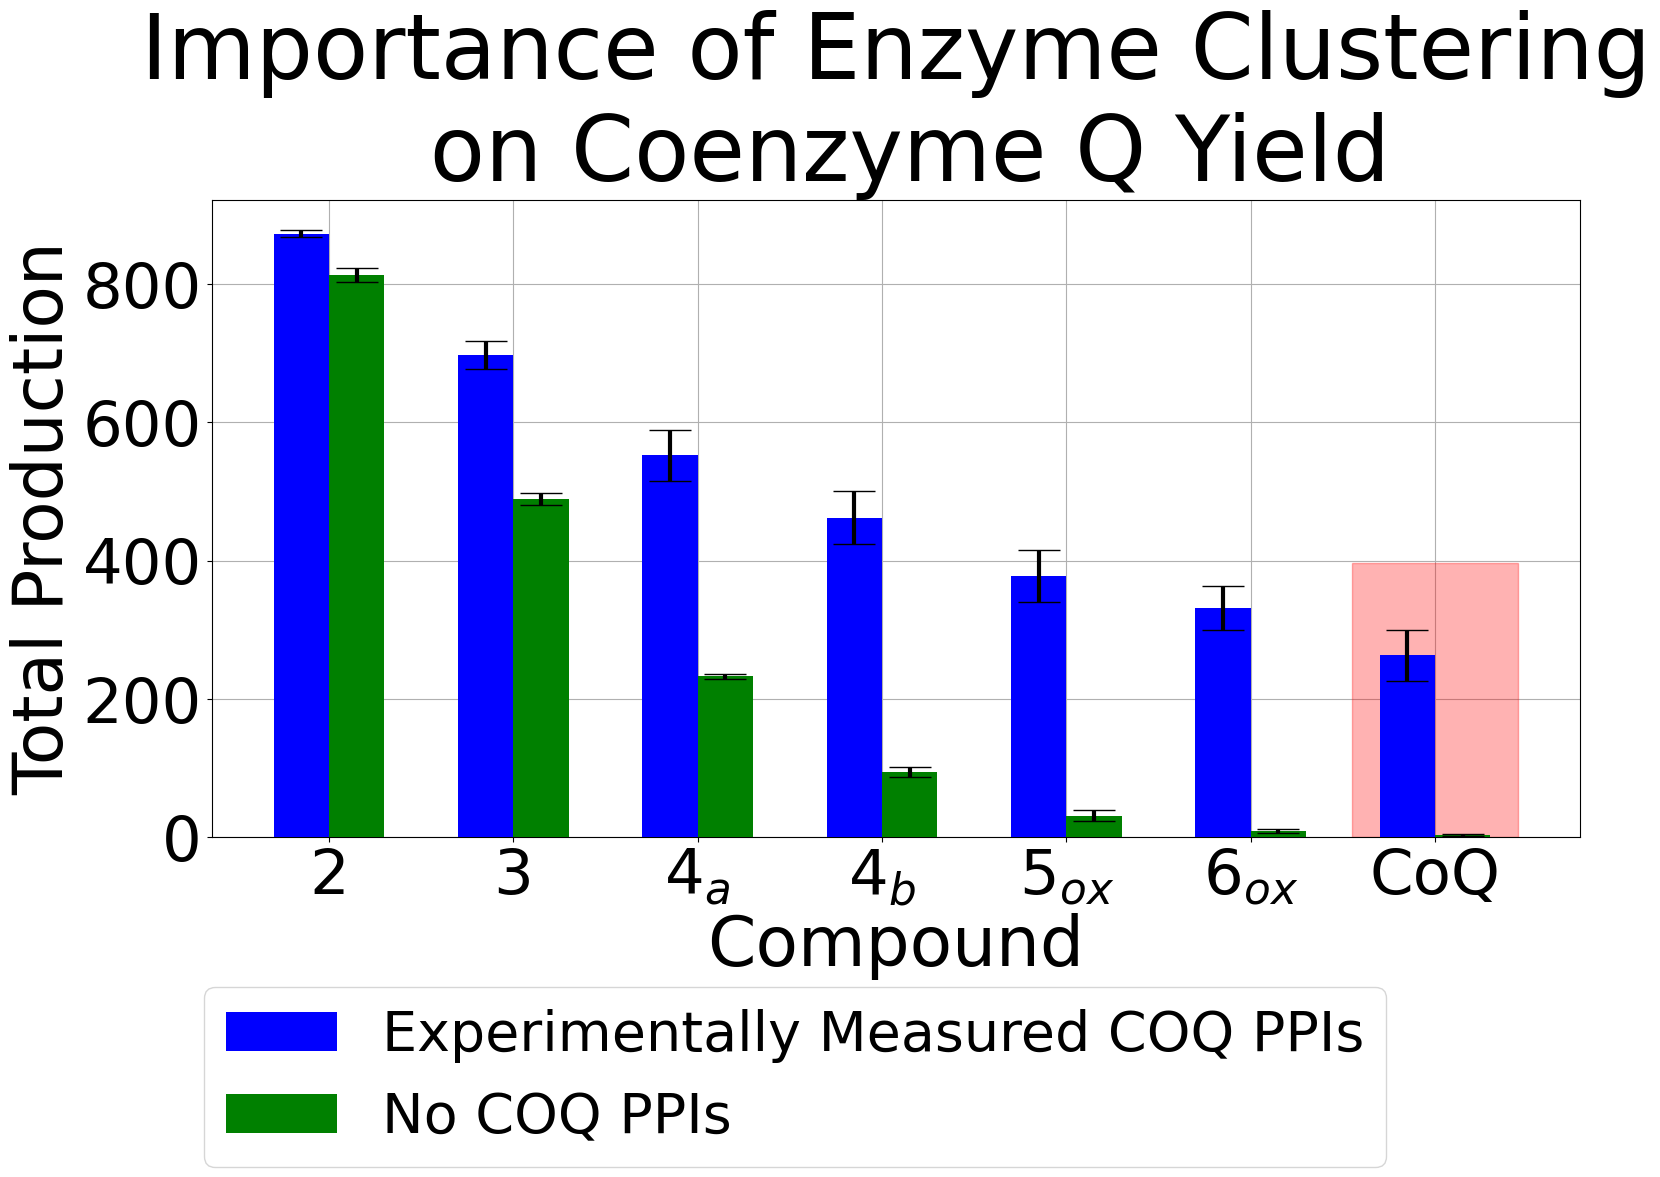

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cluster_10kcat_WT = average_clusters(paths_10kcat_WT, 5)
cluster_10kcat_no_interaction = average_clusters(paths_no_interaction, 5)
dataframes = [cluster_10kcat_WT, cluster_10kcat_no_interaction]

cluster_number_means = [df['clusterNumber_mean'].iloc[-1] for df in dataframes]
cluster_number_vars = [df['clusterNumber_var'].iloc[-1] for df in dataframes]



mean_dataframes = [mean_df_10kcat_WT.iloc[:len(mean_df_10kcat_WT)//2], mean_df_no_interaction_10kcat]
conditions = ['Experimentally Measured COQ PPIs', 'No COQ PPIs']
variance_dataframes = [var_df_10kcat_WT.iloc[:len(var_df_10kcat_WT)//2], var_df_no_interaction_10kcat]
# List of conditions and corresponding colors
colors = ['blue', 'green']
# Columns to plot
columns_to_plot = ['f_bondc0[2]', 'f_bondc1[2]', 'f_bondc2[2]', 'f_bondc3[2]', 'f_bondc4[2]', 'f_bondc5[2]', 'f_bondc6[2]']
titles = ['2', '3', '$4_{a}$', '$4_{b}$', '$5_{ox}$', '$6_{ox}$', 'CoQ']

# Define the width of the bars
bar_width = 0.3

# Define the positions of the bars
index = np.arange(len(columns_to_plot))


columns_to_plot_extended = columns_to_plot + ['clusterNumber']
titles_extended = titles + ['Avgerage \nNumber of\n Clusters']
index_extended = np.arange(len(columns_to_plot_extended))
# Insert extra space (e.g., 1.5 units) before the last bar
index_extended = np.array(list(range(len(columns_to_plot))) + [len(columns_to_plot) + 1.5])


# Set up the main figure and primary axis
fig, ax = plt.subplots(figsize=(18, 10))
ax2 = ax.twinx()  # Secondary y-axis for cluster number
\
# Bar plotting on primary axis (left y-axis)
for i, (mean_df, var_df, condition, color) in enumerate(zip(mean_dataframes, variance_dataframes, conditions, colors)):
    values = [mean_df[col].iloc[-1] for col in columns_to_plot]
    errors = [var_df[col].iloc[-1]**0.5 for col in columns_to_plot]
    
    # Don't include "Cluster Number" here — that's for ax2
    ax.bar(index_extended[:-1] + i * bar_width, values, bar_width,
           yerr=errors, label=condition, color=color, capsize=15,
           zorder=3, error_kw={'elinewidth': 3})

# Plot "Cluster Number" bars on ax2 (secondary y-axis)
cluster_bar_positions = index_extended[-1] + np.array([0, bar_width])
cluster_number_means = [df['clusterNumber_mean'].iloc[0] for df in dataframes]
cluster_number_vars = [df['clusterNumber_var'].iloc[0]**0.5 for df in dataframes]

cluster_number_means[-1] = 0.1


for i, (mean, err, color) in enumerate(zip(cluster_number_means, cluster_number_vars, colors)):
    ax2.bar(cluster_bar_positions[i], mean, bar_width,
            yerr=err, color=color, capsize=15,
            zorder=3, error_kw={'elinewidth': 3})

# X-axis labels and ticks
ax.set_xticks(index_extended + bar_width / 2)
ax.set_xticklabels(titles_extended, fontsize=40)
labels = ax.get_xticklabels()
labels[-1].set_fontsize(25)

# Titles and labels
ax.set_title('Importance of Enzyme Clustering on\n Coenzyme Q Yield', fontsize=60, pad=40)
ax.set_ylabel('Total Production', fontsize=50)
ax2.set_ylabel('Count', fontsize=50)
#ax.set_xlabel('Compound / Cluster Metric', fontsize=50)
# Add "Compound" label to the left side under x-axis
ax.text(2.5, -0.12 * ax.get_ylim()[1], 'Compound', fontsize=40, ha='center', va='top', transform=ax.transData)

# Add "Cluster Metric" label to the right side under x-axis
#ax.text(index_extended[-1], -0.12 * ax.get_ylim()[1], 'Metric', fontsize=40, ha='center', va='top', transform=ax.transData)


ax.tick_params(axis='y', which='major', labelsize=45)
ax2.tick_params(axis='y', labelsize=45)

# Grid and y-limit
ax.grid(True, zorder=0)
ax.set_ylim(0, ax.get_ylim()[1])
ax2.set_ylim(0, max(cluster_number_means) * 1.4)

# Highlight CoQ area
coenzyme_q_index = titles_extended.index('CoQ')
ax.axvspan(coenzyme_q_index - 0.3, coenzyme_q_index + 0.6, color='red', alpha=0.3, zorder=2, ymin=0, ymax=0.43)

divider_x = (index_extended[-2] + index_extended[-1]) / 2 + bar_width / 2
ax.axvline(x=divider_x, color='red', linestyle='-', linewidth=3, zorder=4)


# Legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=40, ncol=1, bbox_to_anchor=(0.5, -0.2))

# Save and show
plt.tight_layout()
plt.savefig('fig_panel1_a', dpi=600, bbox_inches='tight')

plt.show()

Figure 3b

In [11]:
base_path_no_interaction = '/n/netscratch/shakhnovich_lab/Lab/jiojeong/simulations/20241112_metabolon_CoQ9_HSHS1KT_self_interaction_1KT_10kcat_new_dump/no_interaction'

#smallest timestep for production run
min_time_step = 25000000

#largest timestep for production run
max_time_step = 600000000 + 25000000

#this depends on the cluster analysis. Currently I'm dividing entire production run into 100 frames
min_frame = 1
max_frame = 100

# Normalize both histograms and overlay on the same plot
result = compare_channeling(folder_10kcat_WT, paths_10kcat_WT, base_path_no_interaction, paths_no_interaction, target_type=[13, 14, 15, 16, 17, 18])



[1261, 2017, 1277, 1524, 2204, 1496, 2056, 1361, 1406, 1851, 1355, 2236, 1773, 1364, 1619, 1954, 2185, 2067, 1992, 1337, 2032, 1600, 2169, 1294, 2070, 1359, 1552, 1519, 1930, 2171, 1768, 1538, 1559, 2082, 1744, 1893, 1479, 1311, 1728, 1578, 2201, 1516, 2031, 1965, 1747, 1446, 1646, 1267, 1490, 1611, 1713, 1262, 2119, 2062, 1863, 1634, 1864, 1486, 1840, 1752, 1655, 2122, 2167, 2203, 1504, 1390, 2037, 2202, 1343, 1263, 2084, 1730, 1928, 1913, 1682, 1421, 1366, 1276, 2190, 1757, 1448, 2023, 1974, 1679, 2011, 1481, 2160, 1873, 1336, 1399, 2235, 1320, 1471, 2239, 1641, 1597, 1365, 1673, 1660, 1848, 1865, 1689, 1786, 1358, 1303, 1809, 1339, 1908, 2123, 1951, 1389, 1625, 1602, 1549, 2008, 1973, 1642, 2112, 2230, 1780, 1445, 2077, 1396, 2206, 1708, 2054, 1521, 2041, 1553, 1911, 1453, 2148, 1314, 1832, 1814, 1531, 1827, 1963, 2057, 1527, 2144, 1635, 1995, 1901, 1627, 1820, 2043, 1890, 2140, 1257, 1717, 1321, 1991, 1530, 2018, 1562, 2109, 1351, 1555, 1596, 1637, 1878, 1566, 1304, 2046, 2191, 222

/tmp/ipykernel_130627/314445421.py:40: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([bar1, bar2], labels=['Experimentally Measured COQ PPIs', 'No COQ PPIs'], loc='lower center', fontsize=35, ncol=2, bbox_to_anchor=(0.5, -0.12))


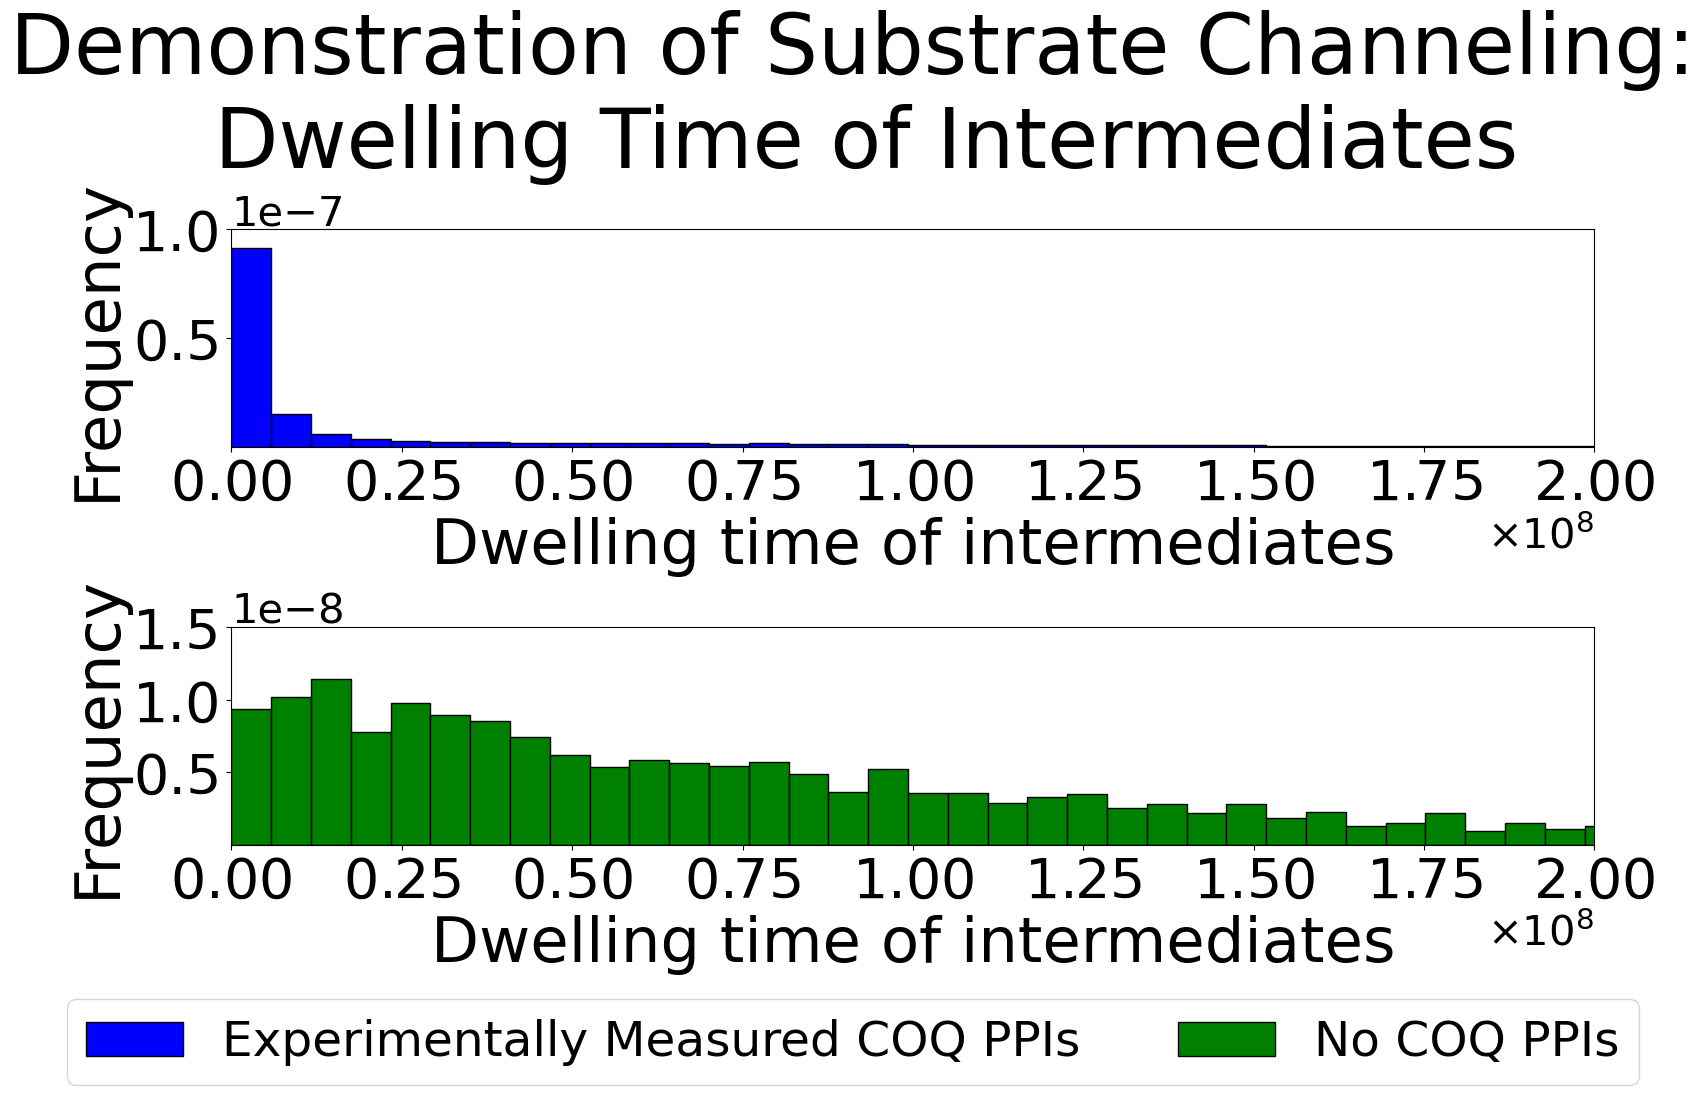

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))  # Create two subplots

# Combine the data to get common bin edges
combined_data = np.concatenate((result[0], result[1]))
counts_combined, bins_combined = np.histogram(combined_data, bins=100, density=True)

# Normalize the first pairwise_frame_differences using the common bins
counts1, _ = np.histogram(result[0], bins=bins_combined, density=True)
bin_centers1 = (bins_combined[:-1] + bins_combined[1:]) / 2  # Calculate bin centers for plotting

# Normalize the second pairwise_frame_differences using the common bins
counts2, _ = np.histogram(result[1], bins=bins_combined, density=True)
bin_centers2 = (bins_combined[:-1] + bins_combined[1:]) / 2  # Calculate bin centers for plotting

# Plot the first normalized histogram on the first subplot
bar1 = ax1.bar(bin_centers1, counts1, width=np.diff(bins_combined), color='blue', edgecolor='black', label='Experimentally Measured COQ PPIs', align='center')

# Plot the second normalized histogram on the second subplot
bar2 = ax2.bar(bin_centers2, counts2, width=np.diff(bins_combined), color='green', edgecolor='black', label='No COQ PPIs', align='center')

# Set labels and title for the first subplot
ax1.set_xlabel('Dwelling time of intermediates', fontsize=45)
ax1.set_ylabel('Frequency', fontsize=45)
ax1.tick_params(axis='both', which='major', labelsize=40)
ax1.set_xlim(0, 2e8)

# Set labels and title for the second subplot
ax2.set_xlabel('Dwelling time of intermediates', fontsize=45)
ax2.set_ylabel('Frequency', fontsize=45)
ax2.tick_params(axis='both', which='major', labelsize=40)
ax2.set_xlim(0, 2e8)

# Remove the 0.0 tick label from the second subplot
ax2.set_yticks(ax2.get_yticks()[1:])
ax1.set_yticks(ax1.get_yticks()[1:])

fig.legend([bar1, bar2], labels=['Experimentally Measured COQ PPIs', 'No COQ PPIs'], loc='lower center', fontsize=35, ncol=2, bbox_to_anchor=(0.5, -0.12))

fig.suptitle('Demonstration of Substrate Channeling', fontsize=60, y=1.02, x=0.5)

from matplotlib.ticker import ScalarFormatter

# Apply formatting to both subplots
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))  
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))   
    ax.xaxis.get_offset_text().set_size(30)  # Increase font size of 1e8
    ax.yaxis.get_offset_text().set_size(30)  # Increase font size of 1e8


plt.tight_layout()
#plt.savefig('BPS_substrate_channeling.png', dpi=600, bbox_inches='tight')
plt.savefig('fig_panel1_b', dpi=600, bbox_inches='tight')

plt.show()

Figure 4b


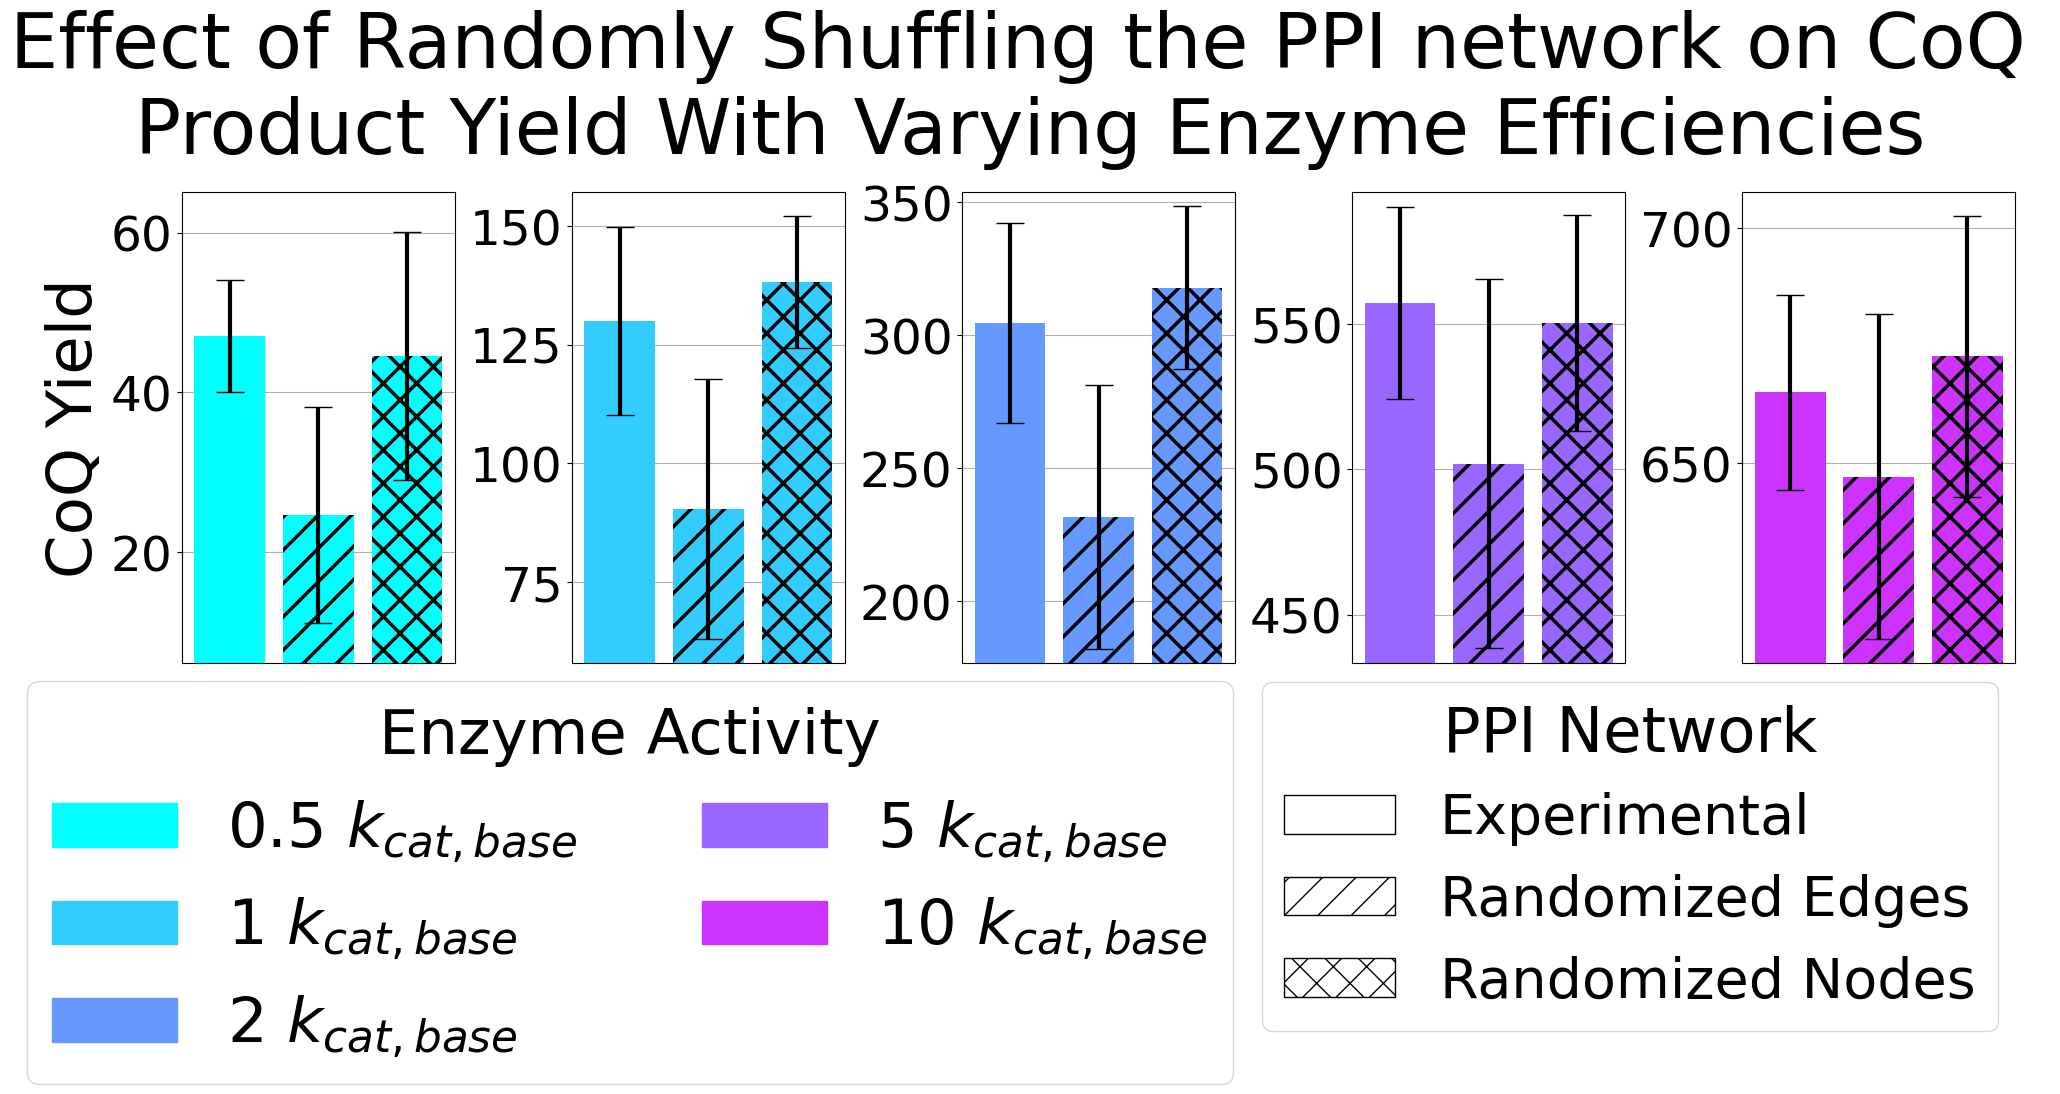

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Assuming mean_dataframes, variance_dataframes, conditions, and colors are already defined
mean_dataframes = [mean_df_0_5kcat_WT, mean_df_0_5kcat_randomized, mean_df_0_5kcat_randomized_nodes, mean_df_1kcat_WT, mean_df_1kcat_randomized, mean_df_1kcat_randomized_nodes, mean_df_2kcat_WT, mean_df_2kcat_randomized, mean_df_2kcat_randomized_nodes, mean_df_5kcat_WT, mean_df_5kcat_randomized, mean_df_5kcat_randomized_nodes, mean_df_10kcat_WT, mean_df_10kcat_randomized, mean_df_10kcat_randomized_nodes]
conditions = [ "0.5$k_{cat,base}$ WT", "0.5$p_{base}$ randomized edges", "0.5$p_{base}$ randomized nodes", "1$p_{base}$ WT", "1$p_{base}$ randomized edges", "1$p_{base}$ randomized nodes", "2$p_{base}$ WT", "2$p_{base}$ randomized edges", "2$p_{base}$ randomized nodes", "5$p_{base}$ WT", "5$p_{base}$ randomized edges", "5$p_{base}$ randomized nodes", "10$p_{base}$ WT", "10$p_{base}$ randomized edges", "10$p_{base}$ randomized nodes"]
variance_dataframes = [var_df_0_5kcat_WT, var_df_0_5kcat_randomized, var_df_0_5kcat_randomized_nodes, var_df_1kcat_WT, var_df_1kcat_randomized, var_df_1kcat_randomized_nodes, var_df_2kcat_WT, var_df_2kcat_randomized, var_df_2kcat_randomized_nodes, var_df_5kcat_WT, var_df_5kcat_randomized, var_df_5kcat_randomized_nodes, var_df_10kcat_WT, var_df_10kcat_randomized, var_df_10kcat_randomized_nodes]
columns_to_plot = ['f_bondc6[2]']

# Define color schemes for different kcat values using a colormap
cmap = plt.get_cmap('cool')
kcat_values = [0.5, 1, 2, 5, 10]
kcat_colors = [cmap(i / len(kcat_values)) for i in range(len(kcat_values))]
#kcat_colors.reverse()  # Reverse the order of the colors

fig, axs = plt.subplots(1, 5, figsize=(20, 7), sharey=False)
legend_handles = []
legend_handles_2 = []

for kcat_index, kcat in enumerate(kcat_values):
    ax = axs[kcat_index]
    
    # Initialize min and max based on the data for this kcat value
    overall_min = float('inf')
    overall_max = float('-inf')
    
    for j in range(3):  # 0 for WT, 1 for randomized
        mean_df = mean_dataframes[3 * kcat_index + j]
        var_df = variance_dataframes[3 * kcat_index + j]
        condition = conditions[3 * kcat_index + j]
        
        # Get the last data point
        last_mean = mean_df[columns_to_plot].iloc[-1].values[0]
        last_std = var_df[columns_to_plot].iloc[-1].values[0] ** 0.5
        
        # Update overall min and max based on mean ± std
        overall_min = min(overall_min, last_mean - last_std)
        overall_max = max(overall_max, last_mean + last_std)
        
        # Determine color and hatch based on WT or randomized
        color = kcat_colors[kcat_index]
        hatch = '/' if 'randomized edges' in condition else ('x' if 'randomized nodes' in condition else '')
        
        # Plot the bar
        bar = ax.bar(j, last_mean, yerr=last_std, color=color, hatch=hatch, capsize=10, hatch_linewidth=2.5, error_kw={'elinewidth': 3})
        
        if j == 0:
            legend_handles.append(mpatches.Patch(color=color, label=f'{kcat} $k_{{cat,base}}$'))
        if kcat_index == 0 and j == 1:
            legend_handles_2.append(mpatches.Patch(facecolor='none', edgecolor='black', label='Experimental'))
            legend_handles_2.append(mpatches.Patch(facecolor='none', edgecolor='black', hatch='/', label='Randomized Edges'))
            legend_handles_2.append(mpatches.Patch(facecolor='none', edgecolor='black', hatch='x', label='Randomized Nodes'))
    
    if kcat_index == 0:
        ax.set_ylabel('CoQ Yield', fontsize=45)
    
    # Set dynamic y-axis limits with truncation
    y_min = overall_min - 5
    y_max = overall_max + 5
    ax.set_ylim(y_min, y_max)

    ax.set_xticks([])
    #ax.set_xticklabels(['WT', 'Randomized'], fontsize=15)
    ax.tick_params(axis='y', labelsize=35)
    ax.grid(True)
    ax.set_axisbelow(True)  # Move gridlines to the back

fig.suptitle("Effect of Randomly Shuffling the PPI network on CoQ \nProduct Yield With Varying Enzyme Efficiencies", fontsize=55)
fig.legend(title = 'Enzyme Activity', title_fontsize = 45, handles=legend_handles, loc='lower center', fontsize=45, ncol=2, bbox_to_anchor=(0.3, -0.6))
fig.legend(title = 'PPI Network', title_fontsize = 45, handles=legend_handles_2, loc='lower center', fontsize=40, ncol=1, bbox_to_anchor=(0.8, -0.52))
plt.tight_layout()
#plt.savefig('fig_randomized_edge_node_WT_yield_bar_graph.png', dpi=600, bbox_inches='tight')
plt.savefig('fig_panel2_b_edges_and_nodes', dpi=600, bbox_inches='tight')

plt.show()


Figure 4c

In [20]:
ratio_0_2, error_0_2 = calculate_ratio_and_error_with_global_correlation(mean_df_0_2kcat_WT, var_df_0_2kcat_WT, mean_df_0_2kcat_randomized, var_df_0_2kcat_randomized)
ratio_0_5, error_0_5 = calculate_ratio_and_error_with_global_correlation(mean_df_0_5kcat_WT, var_df_0_5kcat_WT, mean_df_0_5kcat_randomized, var_df_0_5kcat_randomized)
ratio_1, error_1 = calculate_ratio_and_error_with_global_correlation(mean_df_1kcat_WT, var_df_1kcat_WT, mean_df_1kcat_randomized, var_df_1kcat_randomized)
ratio_2, error_2 = calculate_ratio_and_error_with_global_correlation(mean_df_2kcat_WT, var_df_2kcat_WT, mean_df_2kcat_randomized, var_df_2kcat_randomized)
ratio_5, error_5 = calculate_ratio_and_error_with_global_correlation(mean_df_5kcat_WT, var_df_5kcat_WT, mean_df_5kcat_randomized, var_df_5kcat_randomized)
ratio_10, error_10 = calculate_ratio_and_error_with_global_correlation(mean_df_10kcat_WT, var_df_10kcat_WT, mean_df_10kcat_randomized, var_df_10kcat_randomized)

ratio_0_5_nodes, error_0_5_nodes = calculate_ratio_and_error_with_global_correlation(mean_df_0_5kcat_WT, var_df_0_5kcat_WT, mean_df_0_5kcat_randomized_nodes, var_df_0_5kcat_randomized_nodes)
ratio_1_nodes, error_1_nodes = calculate_ratio_and_error_with_global_correlation(mean_df_1kcat_WT, var_df_1kcat_WT, mean_df_1kcat_randomized_nodes, var_df_1kcat_randomized_nodes)
ratio_2_nodes, error_2_nodes = calculate_ratio_and_error_with_global_correlation(mean_df_2kcat_WT, var_df_2kcat_WT, mean_df_2kcat_randomized_nodes, var_df_2kcat_randomized_nodes)
ratio_5_nodes, error_5_nodes = calculate_ratio_and_error_with_global_correlation(mean_df_5kcat_WT, var_df_5kcat_WT, mean_df_5kcat_randomized_nodes, var_df_5kcat_randomized_nodes)
ratio_10_nodes, error_10_nodes = calculate_ratio_and_error_with_global_correlation(mean_df_10kcat_WT, var_df_10kcat_WT, mean_df_10kcat_randomized_nodes, var_df_10kcat_randomized_nodes)

/tmp/ipykernel_130627/1140994081.py:1007: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ratio[col][condition_mask[col]] = valid_ratio
/tmp/ipykernel_130627/1140994081.py:1008: FutureWarning: ChainedAssignmentError: behaviour will change in p

/tmp/ipykernel_130627/1140994081.py:1007: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ratio[col][condition_mask[col]] = valid_ratio
/tmp/ipykernel_130627/1140994081.py:1008: FutureWarning: ChainedAssignmentError: behaviour will change in p

In [ ]:
#smallest timestep for production run
min_time_step = 25000000

#largest timestep for production run
max_time_step = 600000000 + 25000000

#this depends on the cluster analysis. Currently I'm dividing entire production run into 100 frames
min_frame = 1
max_frame = 100

def compare_channeling_inside_cluster(folder_path, paths, target_type = [13, 14, 15, 16, 17, 18]):
    result = []
    
    temp_path = os.path.join(folder_path, 'save_time.pkl')
    save_path = os.path.expanduser(temp_path)

    if os.path.exists(save_path):
        with open(save_path, 'rb') as f:
            time_step_bond_pairs = pickle.load(f)
    else:
        print("first make a picke file")
        return
    

    sorted_pairs = [sorted(i, key=sort_key) for i in time_step_bond_pairs]
    time_step_bond_pairs_unique = []
    for s in sorted_pairs:
        temp = []
        for i, entry in enumerate(s):
            if i == 0 or entry[1] != s[i - 1][1]:
                temp.append(entry)
        time_step_bond_pairs_unique.append(temp)


    WT_dicts = outer_create_index_to_name_dictionary(paths, 'atom')

    mapped_pairs_WT = []
    for i, sim in enumerate(time_step_bond_pairs_unique):
        temp = []
        for entry in sim:
            time_step = entry[0]
            bond = entry[1]
            frame = math.floor(map_time_step_to_frame(time_step, min_time_step, max_time_step, min_frame, max_frame))
            processed_bonds = process_bonds(bond, WT_dicts[i])
            temp.append((frame, bond, processed_bonds))
        mapped_pairs_WT.append(temp)

    

    atom_type_dumps_WT = outer_create_type_dictionary(paths)
    target_list = []
    for i in atom_type_dumps_WT:
        temp = []
        for j in target_type:
            temp.extend(i[j])
        target_list.append(temp)

    # Filter mapped_pairs so that it only contains reactions that involve target atoms
    mapped_pairs_target_WT = []
    for i, sim in enumerate(mapped_pairs_WT):
        temp = []
        for entry in sim:
            if check_last_two_integers(entry[1], target_list[i]):
                temp.append(entry)
        mapped_pairs_target_WT.append(temp)


    sorted_mapped_pairs_target_WT = []
    for i in mapped_pairs_target_WT:
        temp = sorted(i, key=lambda x: int(x[1].split()[2]))
        temp = decrement_second_value(temp)
        sorted_mapped_pairs_target_WT.append(temp)
        
    cluster_histories_WT, enzyme_histories_WT, merge_histories_WT = outer_track_clusters(paths)

    incomplete_targets = []
    for sim in sorted_mapped_pairs_target_WT:
        temp = []
        target_counts = defaultdict(int)
        for entry in sim:
            first, second, third = entry
            target = int(second.split()[2])
            target_counts[target] += 1
        for target, count in target_counts.items():
            if count != 7:
                temp.append(target)
        incomplete_targets.append(temp)


    updated_data_with_clusters = []

    tot_rxn_count_list = []
    rxn_count_outside_of_cluster_list  = []
    
    
    # this is a block of code that adds the cluster information to the updated_data
    # cluster ID, cluster composition, cluster size, and whether the cluster is complete or not will be added
    for index1, sim in enumerate(sorted_mapped_pairs_target_WT):
        temp = []
        tot_rxn_count = 0
        rxn_count_outside_of_cluster = 0
        for index2, entry in enumerate(sim):
            first, second, third = entry
            parts = second.split()
            enzyme = parts[1]
            frame = first
            #print(f"Frame: {frame}, Enzyme: {enzyme}"
            enzyme_which_cluster = enzyme_histories_WT[index1][int(enzyme)][int(frame)-1]
            #print(f"Cluster ID: {enzyme_which_cluster}")
            tot_rxn_count += 1

            if enzyme_which_cluster is not None:
                cluster_atoms = cluster_histories_WT[index1][enzyme_which_cluster]['atoms'][int(frame)-1]
                #print(f"Cluster atoms: {cluster_atoms}, Size: {len(cluster_atoms)}")
                cluster_atoms_type = [WT_dicts[index1][i] for i in cluster_atoms]
                #print(f"Cluster atoms type: {cluster_atoms_type}")
                complete_cluster = False
                if {1, 2, 3, 4, 5}.issubset(cluster_atoms_type):
                    complete_cluster = True
                new_tuple = (first, second, third, enzyme_which_cluster, cluster_atoms, len(cluster_atoms), complete_cluster)
                
                if len(cluster_atoms) < 5:
                    rxn_count_outside_of_cluster += 1
            else:
                cluster_atoms = None
                #print(f"Cluster atoms: {cluster_atoms}, Size: 0")
                new_tuple = (first, second, third, enzyme_which_cluster, cluster_atoms, 0, False)
                rxn_count_outside_of_cluster += 1
            temp.append(new_tuple)
        updated_data_with_clusters.append(temp)
        tot_rxn_count_list.append(tot_rxn_count)
        rxn_count_outside_of_cluster_list.append(rxn_count_outside_of_cluster)
    
    return tot_rxn_count_list, rxn_count_outside_of_cluster_list


tot_10_WT, out_10_WT = compare_channeling_inside_cluster(folder_10kcat_WT, paths_10kcat_WT, target_type=[13, 14, 15, 16, 17, 18])
tot_5_WT, out_5_WT = compare_channeling_inside_cluster(folder_5kcat_WT, paths_5kcat_WT, target_type=[13, 14, 15, 16, 17, 18])
tot_2_WT, out_2_WT = compare_channeling_inside_cluster(folder_2kcat_WT, paths_2kcat_WT, target_type=[13, 14, 15, 16, 17, 18])
tot_1_WT, out_1_WT = compare_channeling_inside_cluster(folder_1kcat_WT, paths_1kcat_WT, target_type=[13, 14, 15, 16, 17, 18])
tot_05_WT, out_05_WT = compare_channeling_inside_cluster(folder_05kcat_WT, paths_05kcat_WT, target_type=[13, 14, 15, 16, 17, 18])

tot_10_random, out_10_random = compare_channeling_inside_cluster(folder_10kcat_randomized, paths_10kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])
tot_5_random, out_5_random = compare_channeling_inside_cluster(folder_5kcat_randomized, paths_5kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])
tot_2_random, out_2_random = compare_channeling_inside_cluster(folder_2kcat_randomized, paths_2kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])
tot_1_random, out_1_random = compare_channeling_inside_cluster(folder_1kcat_randomized, paths_1kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])
tot_05_random, out_05_random = compare_channeling_inside_cluster(folder_05kcat_randomized, paths_05kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])

# Calculate mean ratios and standard errors for out / (total - out)
out_over_in_10_WT = np.array(out_10_WT) / (np.array(tot_10_WT) - np.array(out_10_WT))
mean_ratios_10_WT = np.mean(out_over_in_10_WT)
sem_10_WT = np.std(out_over_in_10_WT, ddof=1) / np.sqrt(len(out_over_in_10_WT))

out_over_in_5_WT = np.array(out_5_WT) / (np.array(tot_5_WT) - np.array(out_5_WT))
mean_ratios_5_WT = np.mean(out_over_in_5_WT)
sem_5_WT = np.std(out_over_in_5_WT, ddof=1) / np.sqrt(len(out_over_in_5_WT))

out_over_in_2_WT = np.array(out_2_WT) / (np.array(tot_2_WT) - np.array(out_2_WT))
mean_ratios_2_WT = np.mean(out_over_in_2_WT)
sem_2_WT = np.std(out_over_in_2_WT, ddof=1) / np.sqrt(len(out_over_in_2_WT))

out_over_in_1_WT = np.array(out_1_WT) / (np.array(tot_1_WT) - np.array(out_1_WT))
mean_ratios_1_WT = np.mean(out_over_in_1_WT)
sem_1_WT = np.std(out_over_in_1_WT, ddof=1) / np.sqrt(len(out_over_in_1_WT))

out_over_in_05_WT = np.array(out_05_WT) / (np.array(tot_05_WT) - np.array(out_05_WT))
mean_ratios_05_WT = np.mean(out_over_in_05_WT)
sem_05_WT = np.std(out_over_in_05_WT, ddof=1) / np.sqrt(len(out_over_in_05_WT))

# Plot the mean ratios with error bars
kcat_values = ['10kcat', '5kcat', '2kcat', '1kcat', '0.5kcat']
mean_ratios_out_in = [mean_ratios_10_WT, mean_ratios_5_WT, mean_ratios_2_WT, mean_ratios_1_WT, mean_ratios_05_WT]
sem_values_out_in = [sem_10_WT, sem_5_WT, sem_2_WT, sem_1_WT, sem_05_WT]

# plt.errorbar(kcat_values, mean_ratios, yerr=sem_values, fmt='o', capsize=5)

# # Add labels and title
# plt.xlabel('kcat')
# plt.ylabel('out_over_in')
# plt.title('Bulk/Inside Cluster Reactions Ratio for Different kcat Values')

# # Show the plot
# plt.show()

In [23]:
tot_10_random_nodes, out_10_random_nodes = compare_channeling_inside_cluster(folder_10kcat_randomized, paths_10kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])
tot_5_random_nodes, out_5_random_nodes = compare_channeling_inside_cluster(folder_5kcat_randomized, paths_5kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])
tot_2_random_nodes, out_2_random_nodes = compare_channeling_inside_cluster(folder_2kcat_randomized, paths_2kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])
tot_1_random_nodes, out_1_random_nodes = compare_channeling_inside_cluster(folder_1kcat_randomized, paths_1kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])
tot_05_random_nodes, out_05_random_nodes = compare_channeling_inside_cluster(folder_05kcat_randomized, paths_05kcat_randomized, target_type=[13, 14, 15, 16, 17, 18])


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Sample arrays for kcat values, ratios, and errors
kcat_values = np.array([0.5, 1, 2, 5, 10])
ratios_list = [ratio_0_5, ratio_1, ratio_2, ratio_5, ratio_10]
#these are stddev not variance
errors_list = [error_0_5, error_1, error_2, error_5, error_10]

ratios_list_nodes = [ratio_0_5_nodes, ratio_1_nodes, ratio_2_nodes, ratio_5_nodes, ratio_10_nodes]
errors_list_nodes = [error_0_5_nodes, error_1_nodes, error_2_nodes, error_5_nodes, error_10_nodes]

def weighted_stats(values, stddevs):
    mask = ~np.isnan(values) & ~np.isnan(stddevs)
    values = values[mask]
    stddevs = stddevs[mask]
    
    # Convert standard deviations to variances
    variances = stddevs ** 2
    
    # Compute weights as 1 / variance
    weights = 1 / variances
    
    # Weighted mean
    weighted_mean = np.sum(values * weights) / np.sum(weights)
    
    # Weighted standard deviation
    weighted_std = np.sqrt(np.sum(weights * (values - weighted_mean) ** 2) / np.sum(weights))
    
    return weighted_mean, weighted_std

# Compute weighted mean and std for f_bondc6[2] at each kcat value
mean_advantage_ratios = []
std_devs_advantage_ratios = []

mean_advantage_ratios_nodes = []
std_devs_advantage_ratios_nodes = []

for i in range(len(kcat_values)):
    mean, std = weighted_stats(ratios_list[i]['f_bondc6[2]'].values, errors_list[i]['f_bondc6[2]'].values)
    mean_advantage_ratios.append(mean)
    std_devs_advantage_ratios.append(std)

    mean_nodes, std_nodes = weighted_stats(ratios_list_nodes[i]['f_bondc6[2]'].values, errors_list_nodes[i]['f_bondc6[2]'].values)
    mean_advantage_ratios_nodes.append(mean_nodes)
    std_devs_advantage_ratios_nodes.append(std_nodes)


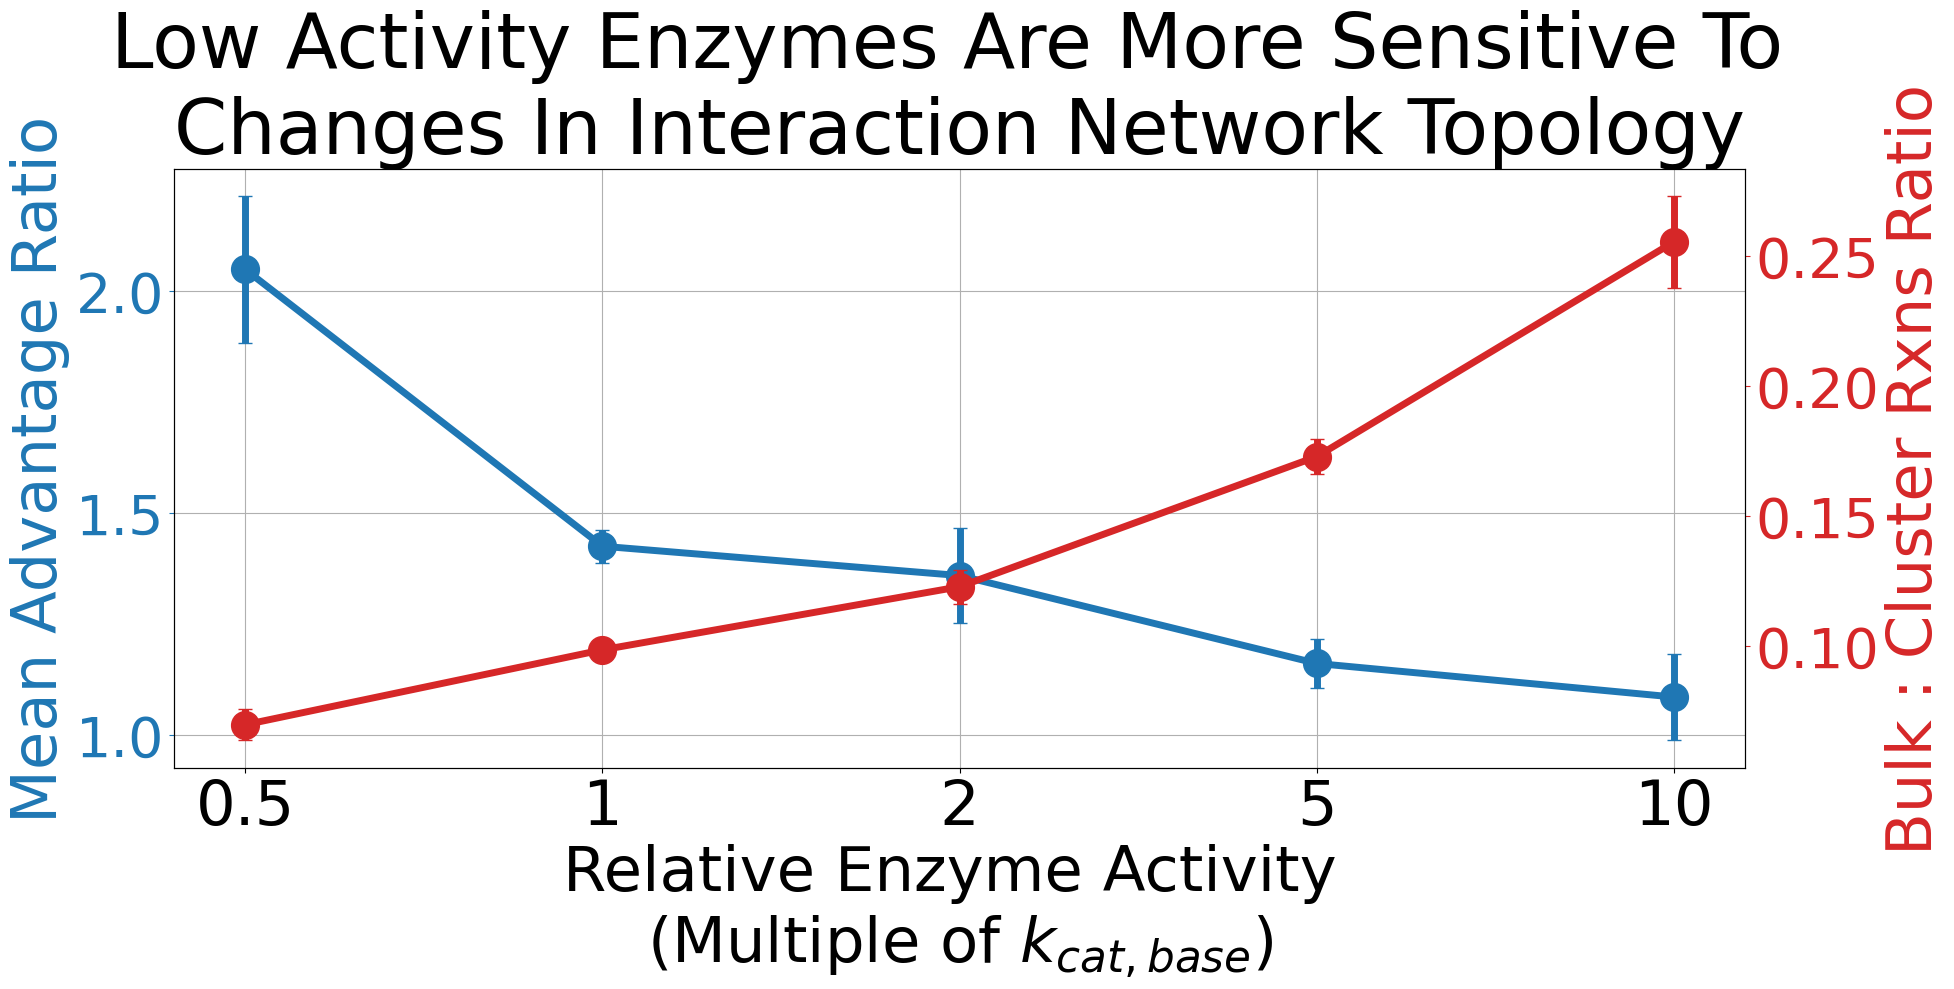

In [56]:
import matplotlib.pyplot as plt

kcat_values = ['0.5$k_{{cat,base}}$', '1$k_{{cat,base}}$', '2$k_{{cat,base}}$', '5$k_{{cat,base}}$', '10$k_{{cat,base}}$']
kcat_values = ['0.5', '1', '2', '5', '10']
# plt.errorbar(kcat_values, mean_ratios, yerr=std_devs, fmt='o-', 
#              capsize=5, label='f_bondc6[2]', markersize=20, linewidth=5)
# plt.errorbar(kcat_values, mean_ratios, yerr=sem_values, fmt='o', capsize=5)

# Create the plot
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot 1: Mean advantage ratio (left y-axis)
color1 = 'tab:blue'
ax1.errorbar(kcat_values, mean_advantage_ratios, yerr=std_devs_advantage_ratios, fmt='o-', 
             capsize=5, markersize=20, linewidth=5, color=color1, label='Mean Advantage Ratio (f_bondc6[2])')
    
ax1.set_xlabel('Relative Enzyme Activity \n(Multiple of $k_{{cat,base}}$)', fontsize=45)
ax1.set_ylabel('Mean Advantage Ratio', fontsize=45, color=color1)
ax1.tick_params(axis='y', labelsize=40, colors=color1)
ax1.tick_params(axis='x', labelsize=45)
ax1.grid(True)

# Plot 2: out_over_in ratio (right y-axis)
ax2 = ax1.twinx()  # Create a second y-axis
color2 = 'tab:red'
ax2.errorbar(kcat_values, mean_ratios_out_in, yerr=sem_values_out_in, fmt='o-', capsize=5, 
             markersize=20, linewidth=5, color=color2, label='Bulk/Inside Cluster Ratio')
ax2.set_ylabel('Bulk : Cluster Rxns Ratio', fontsize=45, color=color2)
ax2.tick_params(axis='y', labelsize=40, colors=color2)

# Title and layout adjustments
plt.title('Low Activity Enzymes Are More Sensitive To \nChanges In Interaction Network Topology', fontsize=55)
fig.tight_layout()
#plt.savefig('BPS_randomized_WT_mean_ratio.png', dpi=600, bbox_inches='tight')
plt.savefig('fig_panel2_c', dpi=600, bbox_inches='tight')

# Show plot
plt.show()


Figure 5a

In [44]:
def read_complete_clusters_excluding_COQ9_one_run(path):
    column_names = ['ClusterNumber', 'ClusterSize', 'MeanClusterSize']
    df = pd.DataFrame(columns=column_names)

    path_number = os.path.join(path, 'cluster_results_skip_first_frame/clusterList_only_complete_clusters_number_excluding_COQ9.dat')
    path_sizes = os.path.join(path, 'cluster_results_skip_first_frame/clusterList_only_complete_clusters_sizes_excluding_COQ9.dat')
    path_mean_sizes = os.path.join(path, 'cluster_results_skip_first_frame/clusterList_only_complete_clusters_mean_sizes_excluding_COQ9.dat')
    

    # Initialize lists to hold file data
    cluster_numbers = []
    cluster_sizes = []
    cluster_mean_sizes = []

    # Read cluster numbers
    with open(path_number, 'r') as file:
        for line in file:
            cluster_numbers.append(int(line.strip()))

    # Read cluster sizes
    with open(path_sizes, 'r') as file:
        for line in file:
            numbers = line.split()  # This splits the string into a list of numbers as strings
            cluster_sizes.append([int(number) for number in numbers])

    with open(path_mean_sizes, 'r') as file:
        for line in file:
            mean_size = float(line.strip())
            cluster_mean_sizes.append(mean_size)

    # Create a DataFrame
    df = pd.DataFrame({
        'ClusterNumber': cluster_numbers,
        'ClusterSize': cluster_sizes,
        'MeanClusterSize' : cluster_mean_sizes
    })

    return df



def read_complete_clusters_one_run(path):
    column_names = ['ClusterNumber', 'ClusterSize', 'MeanClusterSize']
    df = pd.DataFrame(columns=column_names)

    path_number = os.path.join(path, 'cluster_results_skip_first_frame/clusterList_only_complete_clusters_number.dat')
    path_sizes = os.path.join(path, 'cluster_results_skip_first_frame/clusterList_only_complete_clusters_sizes.dat')
    path_mean_sizes = os.path.join(path, 'cluster_results_skip_first_frame/clusterList_only_complete_clusters_mean_sizes.dat')
    

    # Initialize lists to hold file data
    cluster_numbers = []
    cluster_sizes = []
    cluster_mean_sizes = []

    # Read cluster numbers
    with open(path_number, 'r') as file:
        for line in file:
            cluster_numbers.append(int(line.strip()))

    # Read cluster sizes
    with open(path_sizes, 'r') as file:
        for line in file:
            numbers = line.split()  # This splits the string into a list of numbers as strings
            cluster_sizes.append([int(number) for number in numbers])

    with open(path_mean_sizes, 'r') as file:
        for line in file:
            mean_size = float(line.strip())
            cluster_mean_sizes.append(mean_size)

    # Create a DataFrame
    df = pd.DataFrame({
        'ClusterNumber': cluster_numbers,
        'ClusterSize': cluster_sizes,
        'MeanClusterSize' : cluster_mean_sizes
    })

    return df

def readlogfile(logfile_path):
    log_file_full_path = os.path.join(logfile_path, 'output.log')

    with open(log_file_full_path) as file:
        lines = file.readlines()
        start_index = 0
        data_lines = []
        for i, line in enumerate(lines):
            if 'Step E_bond TotEng Temp' in line:
                start_index = i + 1
                break

        # Collect data until a line starts with " loop"
        for line in lines[start_index:]:
            if line.strip().startswith("Loop"):
                break
            data_lines.append(line.split())

    # Now read the actual data into a DataFrame
    df = pd.DataFrame(data_lines, columns=lines[start_index-1].split())

    # Convert necessary columns to float or int as appropriate
    df['Step'] = df['Step'].astype(int)
    for col in df.columns[1:]:  # Convert all other columns assuming they are numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Use 'coerce' to handle any non-numeric entries safely
    return df

def process_paths(paths):
    complete_clusters = []
    yield_data = []
    complete_clusters_excluding_COQ9 = []
    
    for path in paths:
        #complete_clusters.append(read_complete_clusters_one_run(path))
        complete_clusters_excluding_COQ9.append(read_complete_clusters_excluding_COQ9_one_run(path))
        yield_data.append(readlogfile(path))
    
    return complete_clusters_excluding_COQ9, yield_data

def get_mean_cluster_size(df_list):
    mean_values = []
    for df in df_list:
        one_sim = []
        # Ensure the column contains numeric values
        for i in range(len(df)):
            temp = mean(df.iloc[i])
            one_sim.append(temp)
        mean_values.append(one_sim)
    return mean_values

def get_num_enzymes_in_CC(df_list):
    sum_values = []
    for df in df_list:
        one_sim = []
        # Ensure the column contains numeric values
        for i in range(len(df)):
            temp = sum(df.iloc[i])
            one_sim.append(temp)
        sum_values.append(one_sim)
    return sum_values

def plot_cluster_size(WT, WT_yield, random, random_yield, kcat):
    # Assuming random_complete_clusters, random_yield, control_complete_clusters, control_yield, no_PPI_complete_clusters, and no_PPI_yield are lists of DataFrames
    # Each DataFrame in random_complete_clusters, control_complete_clusters, and no_PPI_complete_clusters has a column 'ClusterSize'
    # Each DataFrame in random_yield, control_yield, and no_PPI_yield has a column 'f_bondc6[2]'

    # Extract the average ClusterSize value from the last 10 rows in each entry in random_complete_clusters
    x_values_random = [entry['ClusterSize'].iloc[-10:] for entry in random]
    x_values_random = [mean(entry) for entry in get_mean_cluster_size(x_values_random)]

    # Extract the last f_bondc6[2] value from each entry in random_yield
    y_values_random = [entry['f_bondc6[2]'].iloc[-1] for entry in random_yield]

    # Extract the average ClusterSize value from the last 10 rows in each entry in control_complete_clusters
    x_values_control = [entry['ClusterSize'].iloc[-10:] for entry in WT]
    x_values_control = [mean(entry) for entry in get_mean_cluster_size(x_values_control)]

    # Extract the last f_bondc6[2] value from each entry in control_yield
    y_values_control = [entry['f_bondc6[2]'].iloc[-1] for entry in WT_yield]

    # Combine all x-values and y-values
    x_values_combined = x_values_random + x_values_control + x_values_zeroes
    y_values_combined = y_values_random + y_values_control + y_values_zeroes

    # Calculate Spearman correlation for combined data
    spearman_combined, p_value_combined = spearmanr(x_values_combined, y_values_combined)
    print(f"Spearman correlation for combined data: {spearman_combined}, p-value: {p_value_combined}")

    # Calculate line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(x_values_combined, y_values_combined)
    line = slope * np.array(x_values_combined) + intercept

    # Calculate mean and standard deviation for random network
    mean_x_random = np.mean(x_values_random)
    mean_y_random = np.mean(y_values_random)
    std_x_random = np.std(x_values_random)
    std_y_random = np.std(y_values_random)

    # Calculate mean and standard deviation for experimental network
    mean_x_control = np.mean(x_values_control)
    mean_y_control = np.mean(y_values_control)
    std_x_control = np.std(x_values_control)
    std_y_control = np.std(y_values_control)


    # Plot the values
    plt.figure(figsize=(10, 5))

    # Plot random data
    plt.scatter(x_values_random, y_values_random, color='red', label='Random network')

    # Plot control data
    plt.scatter(x_values_control, y_values_control, color='blue', label='Experimental network')

    # Plot line of best fit
    plt.plot(x_values_combined, line, color='black', label='Line of best fit')

    # Plot average points with error bars
    plt.errorbar(mean_x_random, mean_y_random, xerr=std_x_random, yerr=std_y_random, fmt='o', color='red', ecolor='red', elinewidth=2, capsize=4, label='Average Random')
    plt.errorbar(mean_x_control, mean_y_control, xerr=std_x_control, yerr=std_y_control, fmt='o', color='blue', ecolor='blue', elinewidth=2, capsize=4, label='Average Experimental')

    plt.xlabel('Average Size of Complete Clusters', fontsize=15)
    plt.ylabel('Yield (f_bondc6[2])', fontsize=15)
    plt.title(f'{kcat}kcat, Yield vs Average Size of Complete Clusters = [COQ3, COQ4, COQ5, COQ6, COQ7], Final 10% of simulation', fontsize=20)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    plt.grid(True)

    # Add Spearman correlation coefficient to the plot
    plt.text(0.05, 0.95, f'Spearman: {spearman_combined:.2f}\nP-value: {p_value_combined:.2e}', 
            transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.show()

def plot_cluster_number(WT, WT_yield, random, random_yield, kcat):

    # Assuming random_complete_clusters, random_yield, control_complete_clusters, control_yield, no_PPI_complete_clusters, and no_PPI_yield are lists of DataFrames
    # Each DataFrame in random_complete_clusters, control_complete_clusters, and no_PPI_complete_clusters has a column 'ClusterSize'
    # Each DataFrame in random_yield, control_yield, and no_PPI_yield has a column 'f_bondc6[2]'

    # Extract the average ClusterSize value from the last 10 rows in each entry in control_complete_clusters
    x_values_control = [entry['ClusterNumber'].iloc[-10:].mean() for entry in WT]

    # Extract the last f_bondc6[2] value from each entry in control_yield
    y_values_control = [entry['f_bondc6[2]'].iloc[-1] for entry in WT_yield]

    x_values_random = [entry['ClusterNumber'].iloc[-10:].mean() for entry in random]
    y_values_random = [entry['f_bondc6[2]'].iloc[-1] for entry in random_yield]


    # Combine all x-values and y-values
    x_values_combined = x_values_control + x_values_random + x_values_zeroes
    y_values_combined = y_values_control + y_values_random + y_values_zeroes
    # Calculate Spearman correlation for combined data
    spearman_combined, p_value_combined = spearmanr(x_values_combined, y_values_combined)
    print(f"Spearman correlation for combined data: {spearman_combined}, p-value: {p_value_combined}")

    # Calculate line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(x_values_combined, y_values_combined)
    line = slope * np.array(x_values_combined) + intercept

    # # Calculate mean and standard deviation for random network
    mean_x_random = np.mean(x_values_random)
    mean_y_random = np.mean(y_values_random)
    std_x_random = np.std(x_values_random)
    std_y_random = np.std(y_values_random)

    # Calculate mean and standard deviation for experimental network
    mean_x_control = np.mean(x_values_control)
    mean_y_control = np.mean(y_values_control)
    std_x_control = np.std(x_values_control)
    std_y_control = np.std(y_values_control)


    # Plot the values
    plt.figure(figsize=(10, 5))

    plt.scatter(x_values_random, y_values_random, color='red', label='Random network')

    # Plot control data
    plt.scatter(x_values_control, y_values_control, color='blue', label='Experimental network')


    # Plot line of best fit
    plt.plot(x_values_combined, line, color='black', label='Line of best fit')

    # Plot average points with error bars
    plt.errorbar(mean_x_random, mean_y_random, xerr=std_x_random, yerr=std_y_random, fmt='o', color='red', ecolor='red', elinewidth=2, capsize=4, label='Average Random')
    plt.errorbar(mean_x_control, mean_y_control, xerr=std_x_control, yerr=std_y_control, fmt='o', color='blue', ecolor='blue', elinewidth=2, capsize=4, label='_nolegend_')

    plt.xlabel('Number of Complete Clusters', fontsize=15)
    plt.ylabel('Yield (f_bondc6[2])', fontsize=15)
    plt.title(f'{kcat}kcat, Yield vs Total Number Complete Clusters = [COQ3, COQ4, COQ5, COQ6, COQ7], Final 10% of Simulation', fontsize=15)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    plt.grid(True)

    # Add Spearman correlation coefficient to the plot
    plt.text(0.05, 0.95, f'Spearman: {spearman_combined:.2f}\nP-value: {p_value_combined:.2e}', 
            transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.show()


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, linregress
from sklearn.linear_model import LinearRegression


def plot_all_three(WT, WT_yield, random, random_yield, kcat):
    plot_cluster_size(WT, WT_yield, random, random_yield, kcat)
    plot_cluster_number(WT, WT_yield, random, random_yield, kcat)
    plot_enzyme_number(WT, WT_yield, random, random_yield, kcat)
    
x_values_zeroes = [0, 0, 0, 0, 0, 0]
y_values_zeroes = [0, 0, 0, 0, 0, 0]


# Using the function for randomized paths
cc_02kcat_WT, yield_02kat_WT = process_paths(paths_02kcat_WT)
cc_05kcat_WT, yield_05kat_WT = process_paths(paths_05kcat_WT)
cc_1kcat_WT, yield_1kat_WT = process_paths(paths_1kcat_WT)
cc_2kcat_WT, yield_2kat_WT = process_paths(paths_2kcat_WT)
cc_5kcat_WT, yield_5kat_WT = process_paths(paths_5kcat_WT)
cc_10kcat_WT, yield_10kat_WT = process_paths(paths_10kcat_WT)

cc_02kcat_randomized, yield_02kat_randomized = process_paths(paths_02kcat_randomized)
cc_05kcat_randomized, yield_05kat_randomized = process_paths(paths_05kcat_randomized)
cc_1kcat_randomized, yield_1kat_randomized = process_paths(paths_1kcat_randomized)
cc_2kcat_randomized, yield_2kat_randomized = process_paths(paths_2kcat_randomized)
cc_5kcat_randomized, yield_5kat_randomized = process_paths(paths_5kcat_randomized)
cc_10kcat_randomized, yield_10kat_randomized = process_paths(paths_10kcat_randomized)

cc_10kcat_no_interaction, yield_10kat_no_interaction = process_paths(paths_no_interaction)
cc_10kcat_ablate_1_2, yield_10kat_ablate_1_2 = process_paths(paths_10kcat_ablate_12)
cc_10kcat_ablate_5_20, yield_10kat_ablate_5_20 = process_paths(paths_10kcat_ablate_520)


path_range = range(1, 4)
base_path = "/n/netscratch/shakhnovich_lab/Lab/jiojeong/simulations/20250127_CoQ_ablation_15us_production_5kcat/ablate_1-2"
paths_5kcat_ablate_12 = [f"{base_path}_{i}/" for i in path_range]

base_path = "/n/netscratch/shakhnovich_lab/Lab/jiojeong/simulations/20250127_CoQ_ablation_15us_production_5kcat/ablate_5-20"
paths_5kcat_ablate_520 = [f"{base_path}_{i}/" for i in path_range]

cc_5kcat_ablate_1_2, yield_5kat_ablate_1_2 = process_paths(paths_5kcat_ablate_12)
cc_5kcat_ablate_5_20, yield_5kat_ablate_5_20 = process_paths(paths_5kcat_ablate_520)


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

def plot_enzyme_number(WT, WT_yield, random, random_yield, kcat, show_legend=False):
    # Assuming random_complete_clusters, random_yield, control_complete_clusters, control_yield, no_PPI_complete_clusters, and no_PPI_yield are lists of DataFrames
    # Each DataFrame in random_complete_clusters, control_complete_clusters, and no_PPI_complete_clusters has a column 'ClusterSize'
    # Each DataFrame in random_yield, control_yield, and no_PPI_yield has a column 'f_bondc6[2]'
    fig, ax = plt.subplots(figsize=(35, 17))
    # Extract the average ClusterSize value from the last 10 rows in each entry in random_complete_clusters
    x_values_random = [entry['ClusterSize'].iloc[-10:] for entry in random]
    x_values_random = [np.mean(entry) for entry in get_num_enzymes_in_CC(x_values_random)]
    x_values_random = [x / 300 for x in x_values_random]


    # Extract the last f_bondc6[2] value from each entry in random_yield
    y_values_random = [entry['f_bondc6[2]'].iloc[-1] for entry in random_yield]

    # Extract the average ClusterSize value from the last 10 rows in each entry in control_complete_clusters
    x_values_control = [entry['ClusterSize'].iloc[-10:] for entry in WT]
    x_values_control = [np.mean(entry) for entry in get_num_enzymes_in_CC(x_values_control)]
    x_values_control = [x / 300 for x in x_values_control]

    # Extract the last f_bondc6[2] value from each entry in control_yield
    y_values_control = [entry['f_bondc6[2]'].iloc[-1] for entry in WT_yield]

    # Combine all x-values and y-values
    x_values_combined = x_values_random + x_values_control
    y_values_combined = y_values_random + y_values_control

    # Calculate Spearman correlation for combined data
    spearman_combined, p_value_combined = spearmanr(x_values_combined, y_values_combined)
    print(f"Spearman correlation for combined data: {spearman_combined}, p-value: {p_value_combined}")

    # Calculate line of best fit through the origin
    x_values_combined = np.array(x_values_combined).reshape(-1, 1)
    y_values_combined = np.array(y_values_combined)
    model = LinearRegression(fit_intercept=False)
    model.fit(x_values_combined, y_values_combined)
    slope = model.coef_[0]
    line = slope * np.array(x_values_combined)
    line = np.append(line, [[0]], axis=0)

    # Calculate mean and standard deviation for random network
    mean_x_random = np.mean(x_values_random)
    mean_y_random = np.mean(y_values_random)
    std_x_random = np.std(x_values_random)
    std_y_random = np.std(y_values_random)

    # Calculate mean and standard deviation for experimental network
    mean_x_control = np.mean(x_values_control)
    mean_y_control = np.mean(y_values_control)
    std_x_control = np.std(x_values_control)
    std_y_control = np.std(y_values_control)

    # Plot the values
    ax.scatter(x_values_random, y_values_random, color='red', label='Random network', s=400)
    ax.scatter(x_values_control, y_values_control, color='blue', label='Experimental network', s=400)
    ax.plot(np.append(x_values_combined, [[0]], axis=0), line, color='black', label='Line of best fit', linewidth=5)
    ax.errorbar(mean_x_random, mean_y_random, xerr=std_x_random, yerr=std_y_random, fmt='o', color='red', ecolor='red', elinewidth=3, capsize=4, label='Average Random', markersize=25)
    ax.errorbar(mean_x_control, mean_y_control, xerr=std_x_control, yerr=std_y_control, fmt='o', color='blue', ecolor='blue', elinewidth=3, capsize=4, label='Average Experimental', markersize=25)
    ax.set_xlabel('Proportion of Enzymes in Complete Clusters', fontsize=45)
    ax.set_ylabel('Final Coenzyme Q Yield', fontsize=45)
    ax.tick_params(axis='both', which='major', labelsize=45)
    ax.set_title(f'{kcat}$k_{{cat,base}}$', fontsize=65)
    ax.grid(True)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.text(0.05, 0.95, f'Spearman: {spearman_combined:.2f}\nP-value: {p_value_combined:.2e}', 
            transform=ax.transAxes, fontsize=45, verticalalignment='top')

    ax.legend(fontsize=50, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)
    plt.savefig(f'fig_supp_correlation_{kcat}kcat.png', dpi=600)
    plt.show()
    

Spearman correlation for combined data: 0.5330581356818384, p-value: 0.022733428713924274


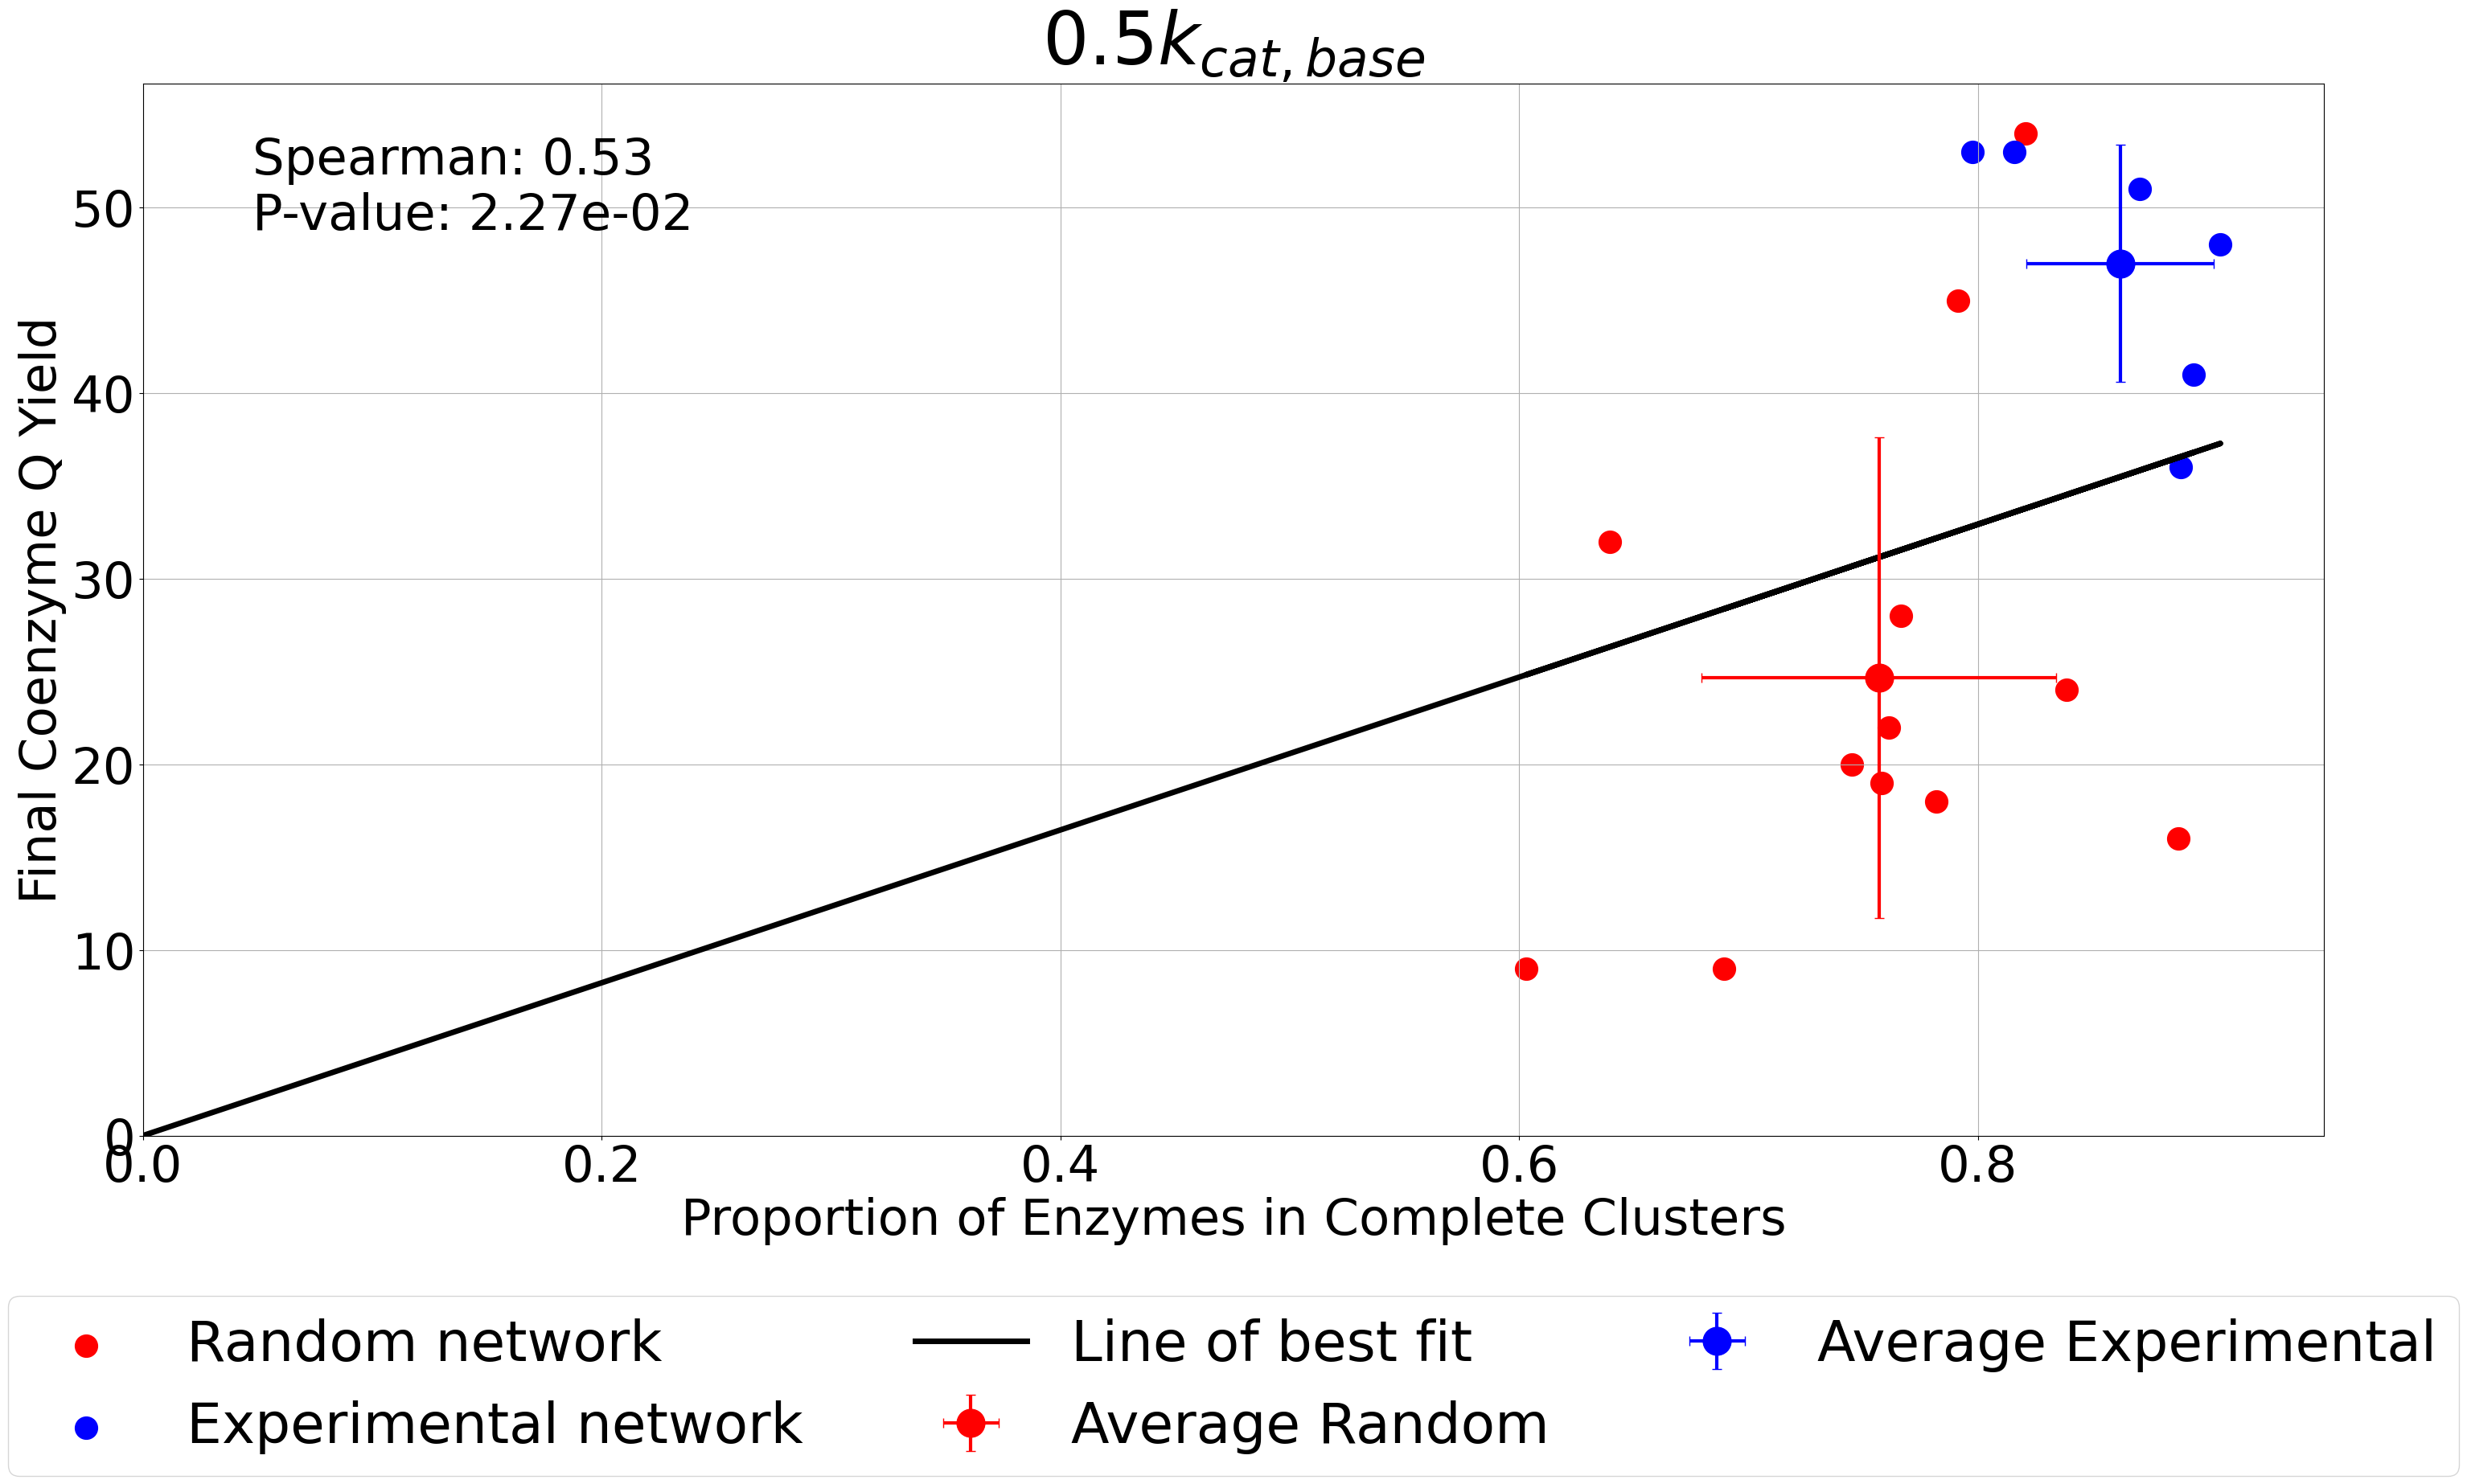

Spearman correlation for combined data: 0.3717088776198447, p-value: 0.12880257096255454


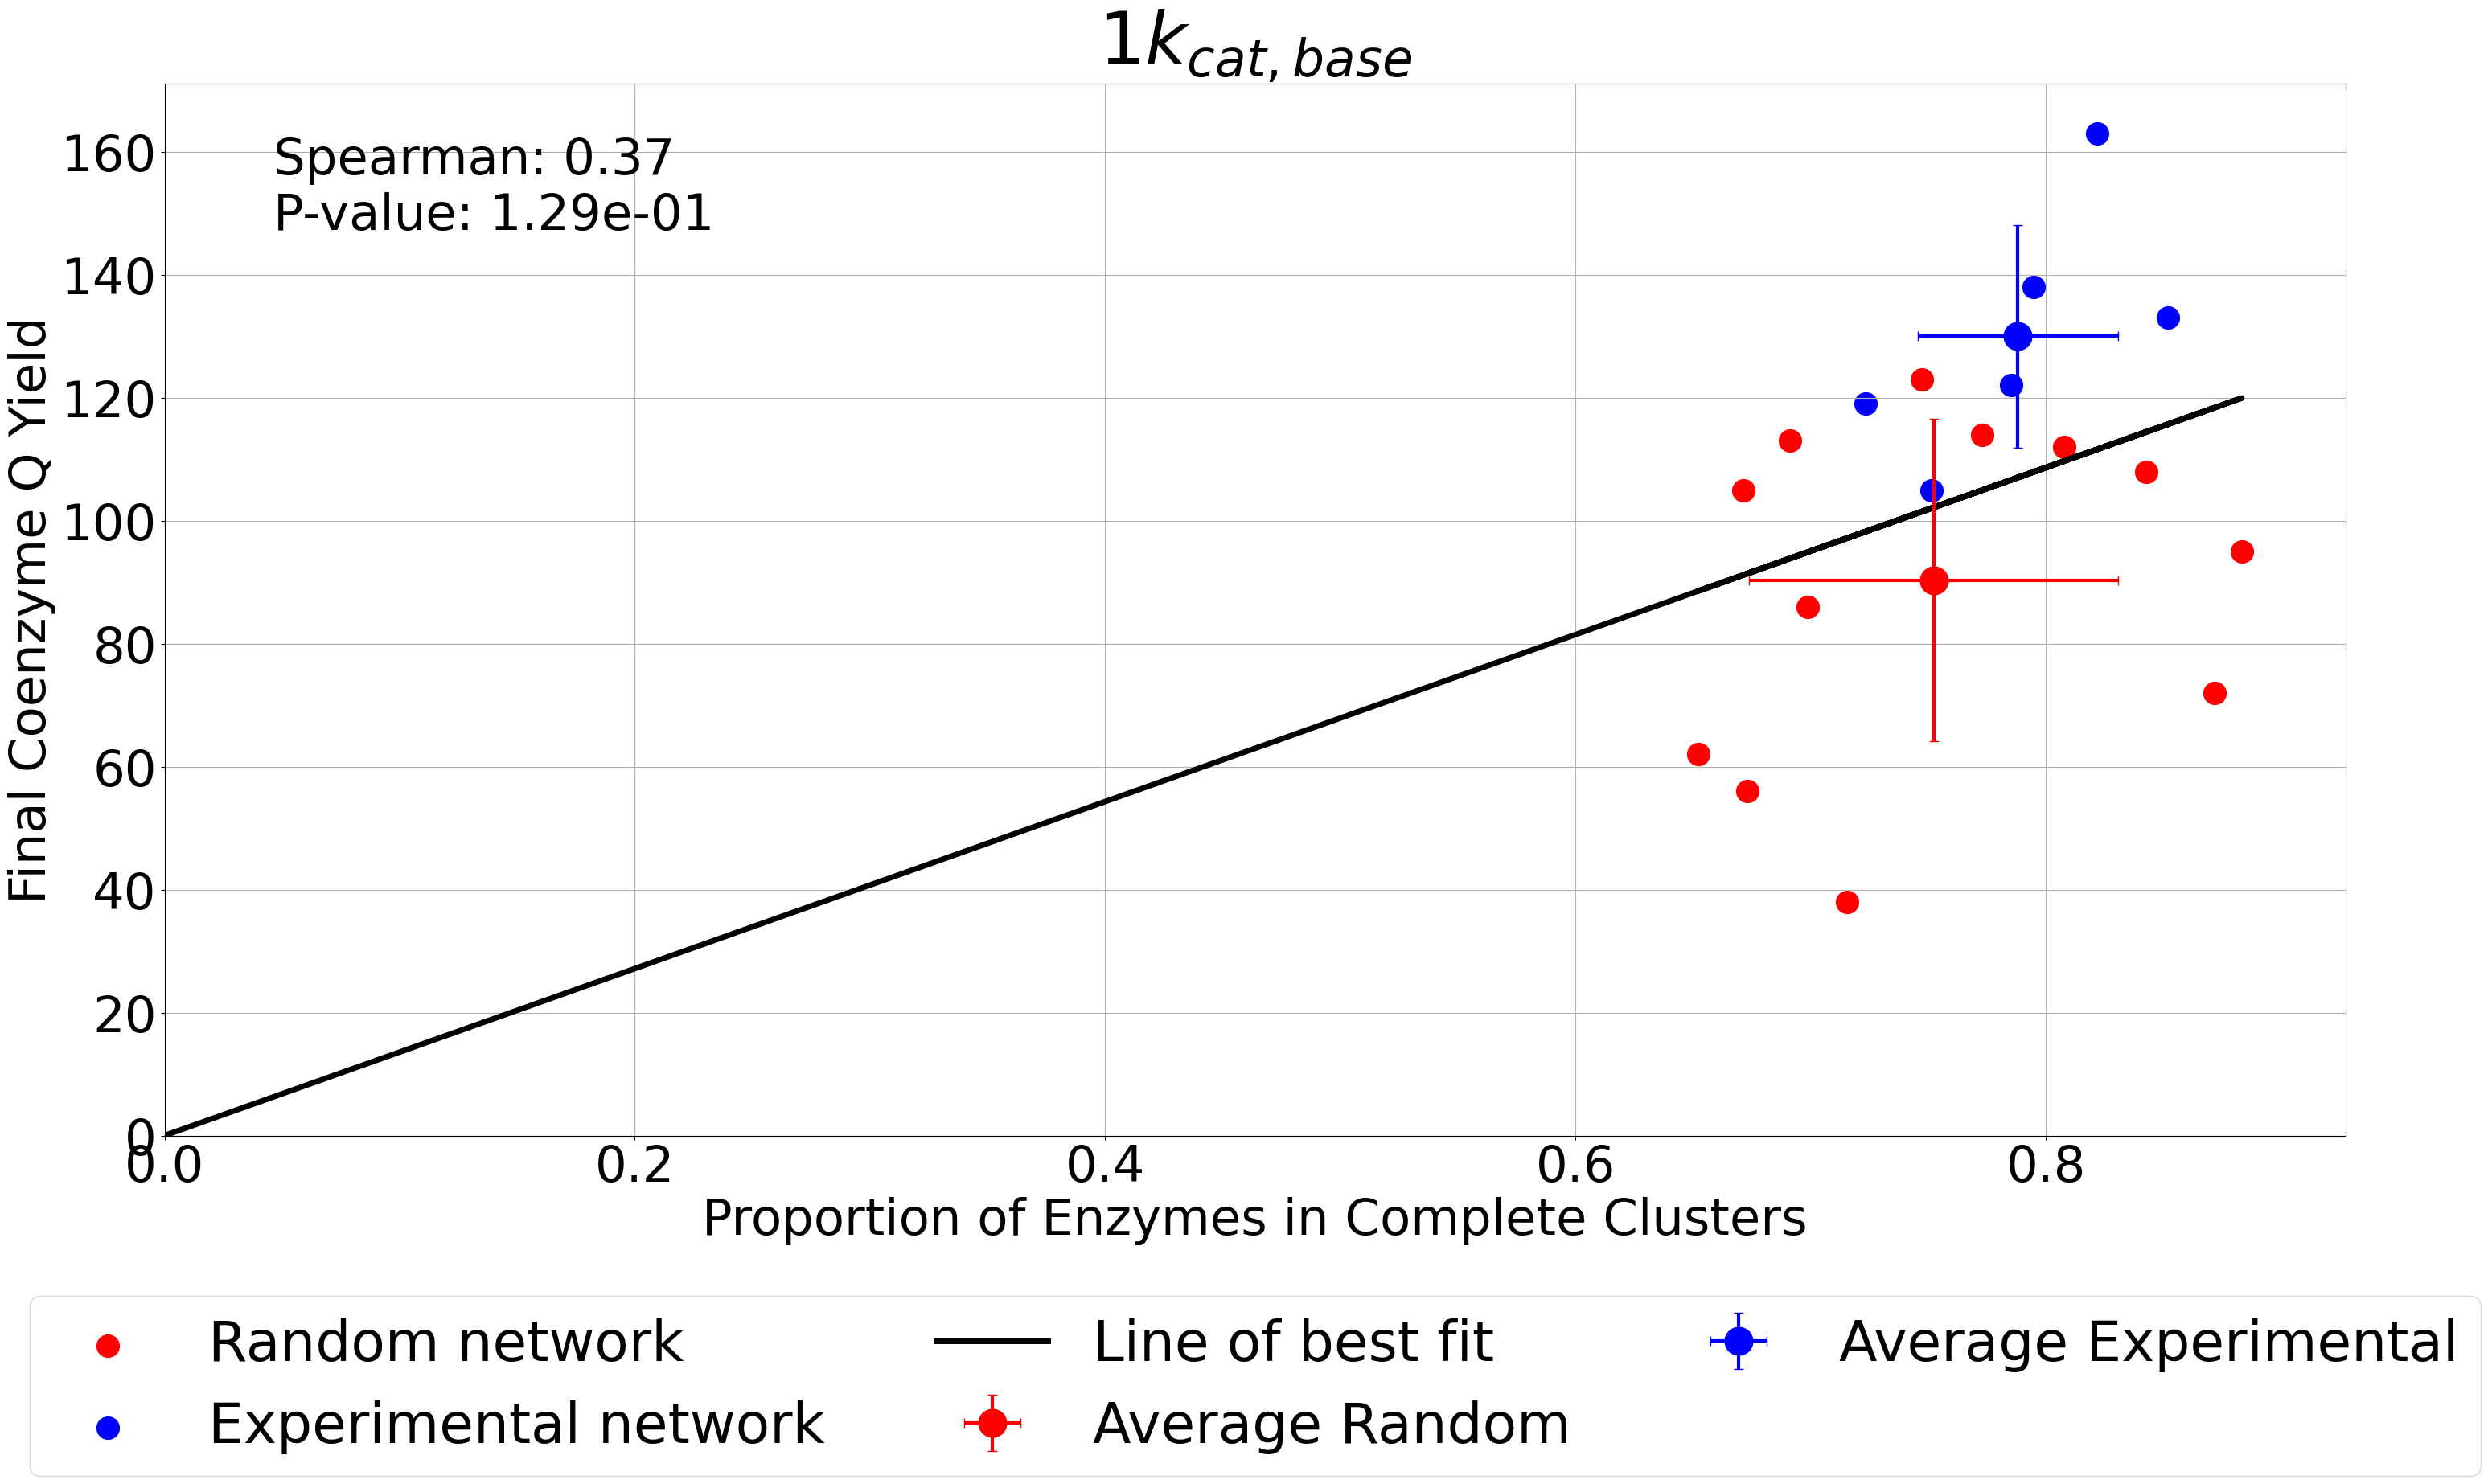

Spearman correlation for combined data: 0.543859649122807, p-value: 0.019643563727791618


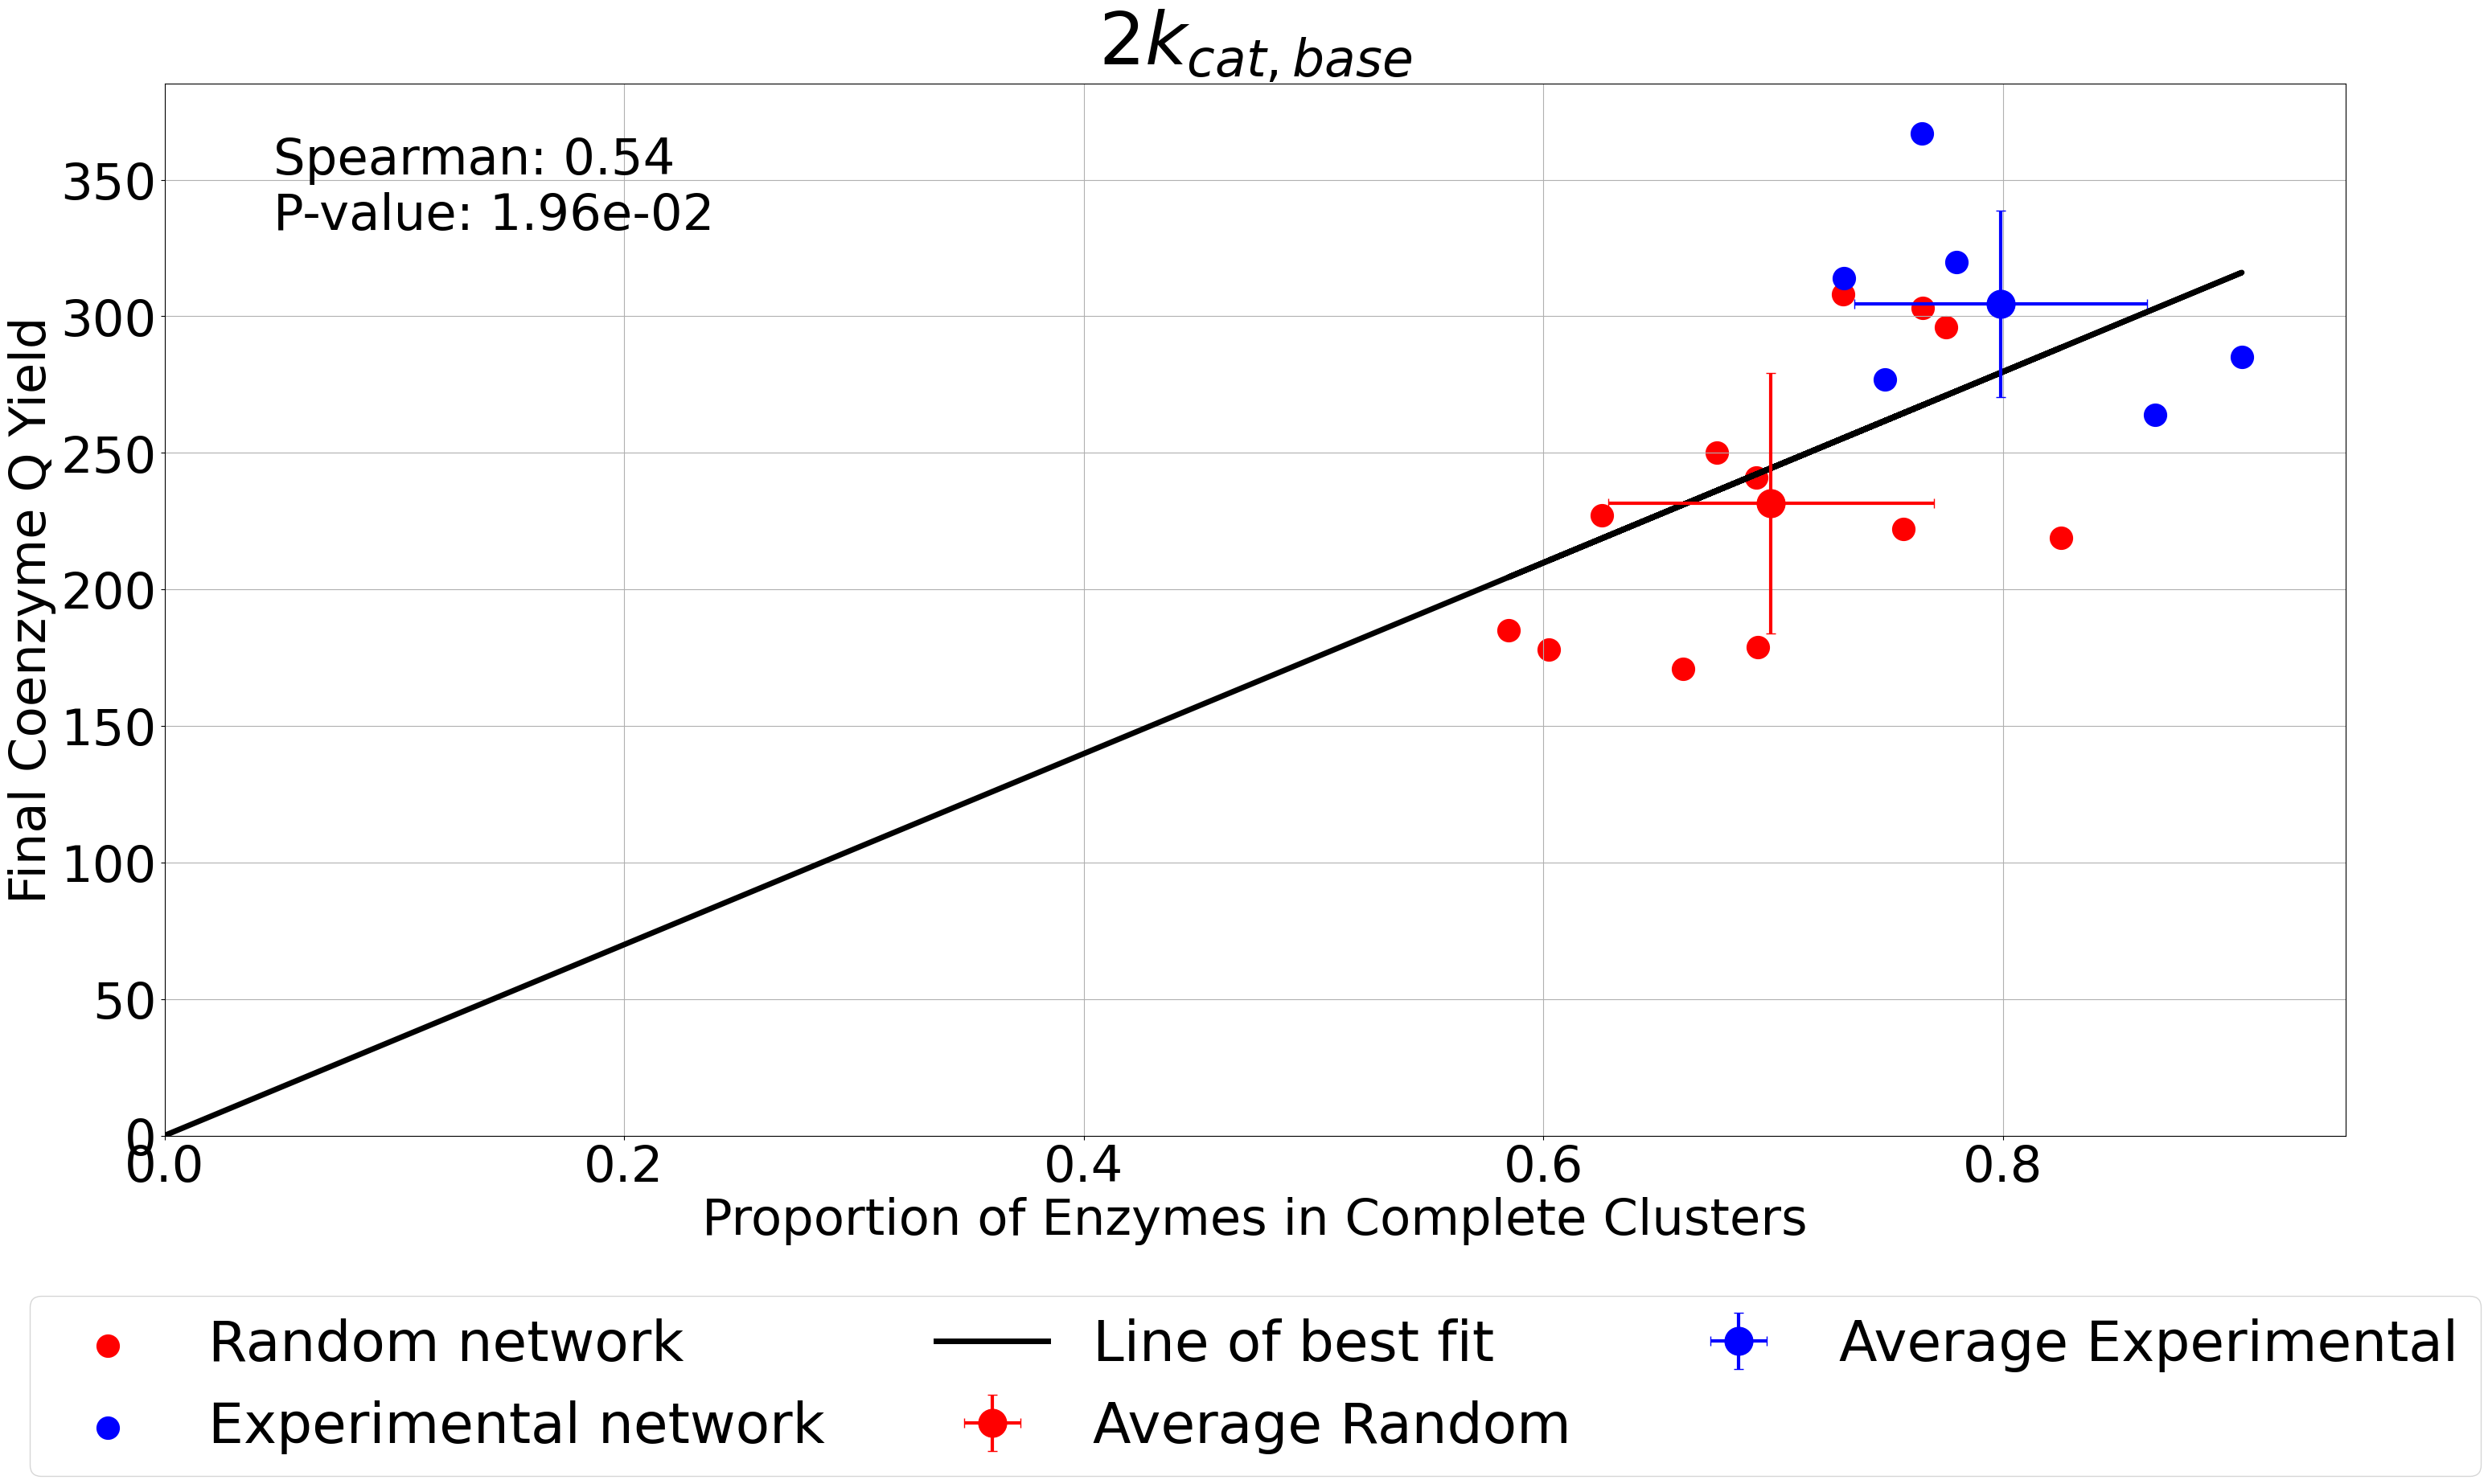

Spearman correlation for combined data: 0.44272445820433437, p-value: 0.06578236404039446


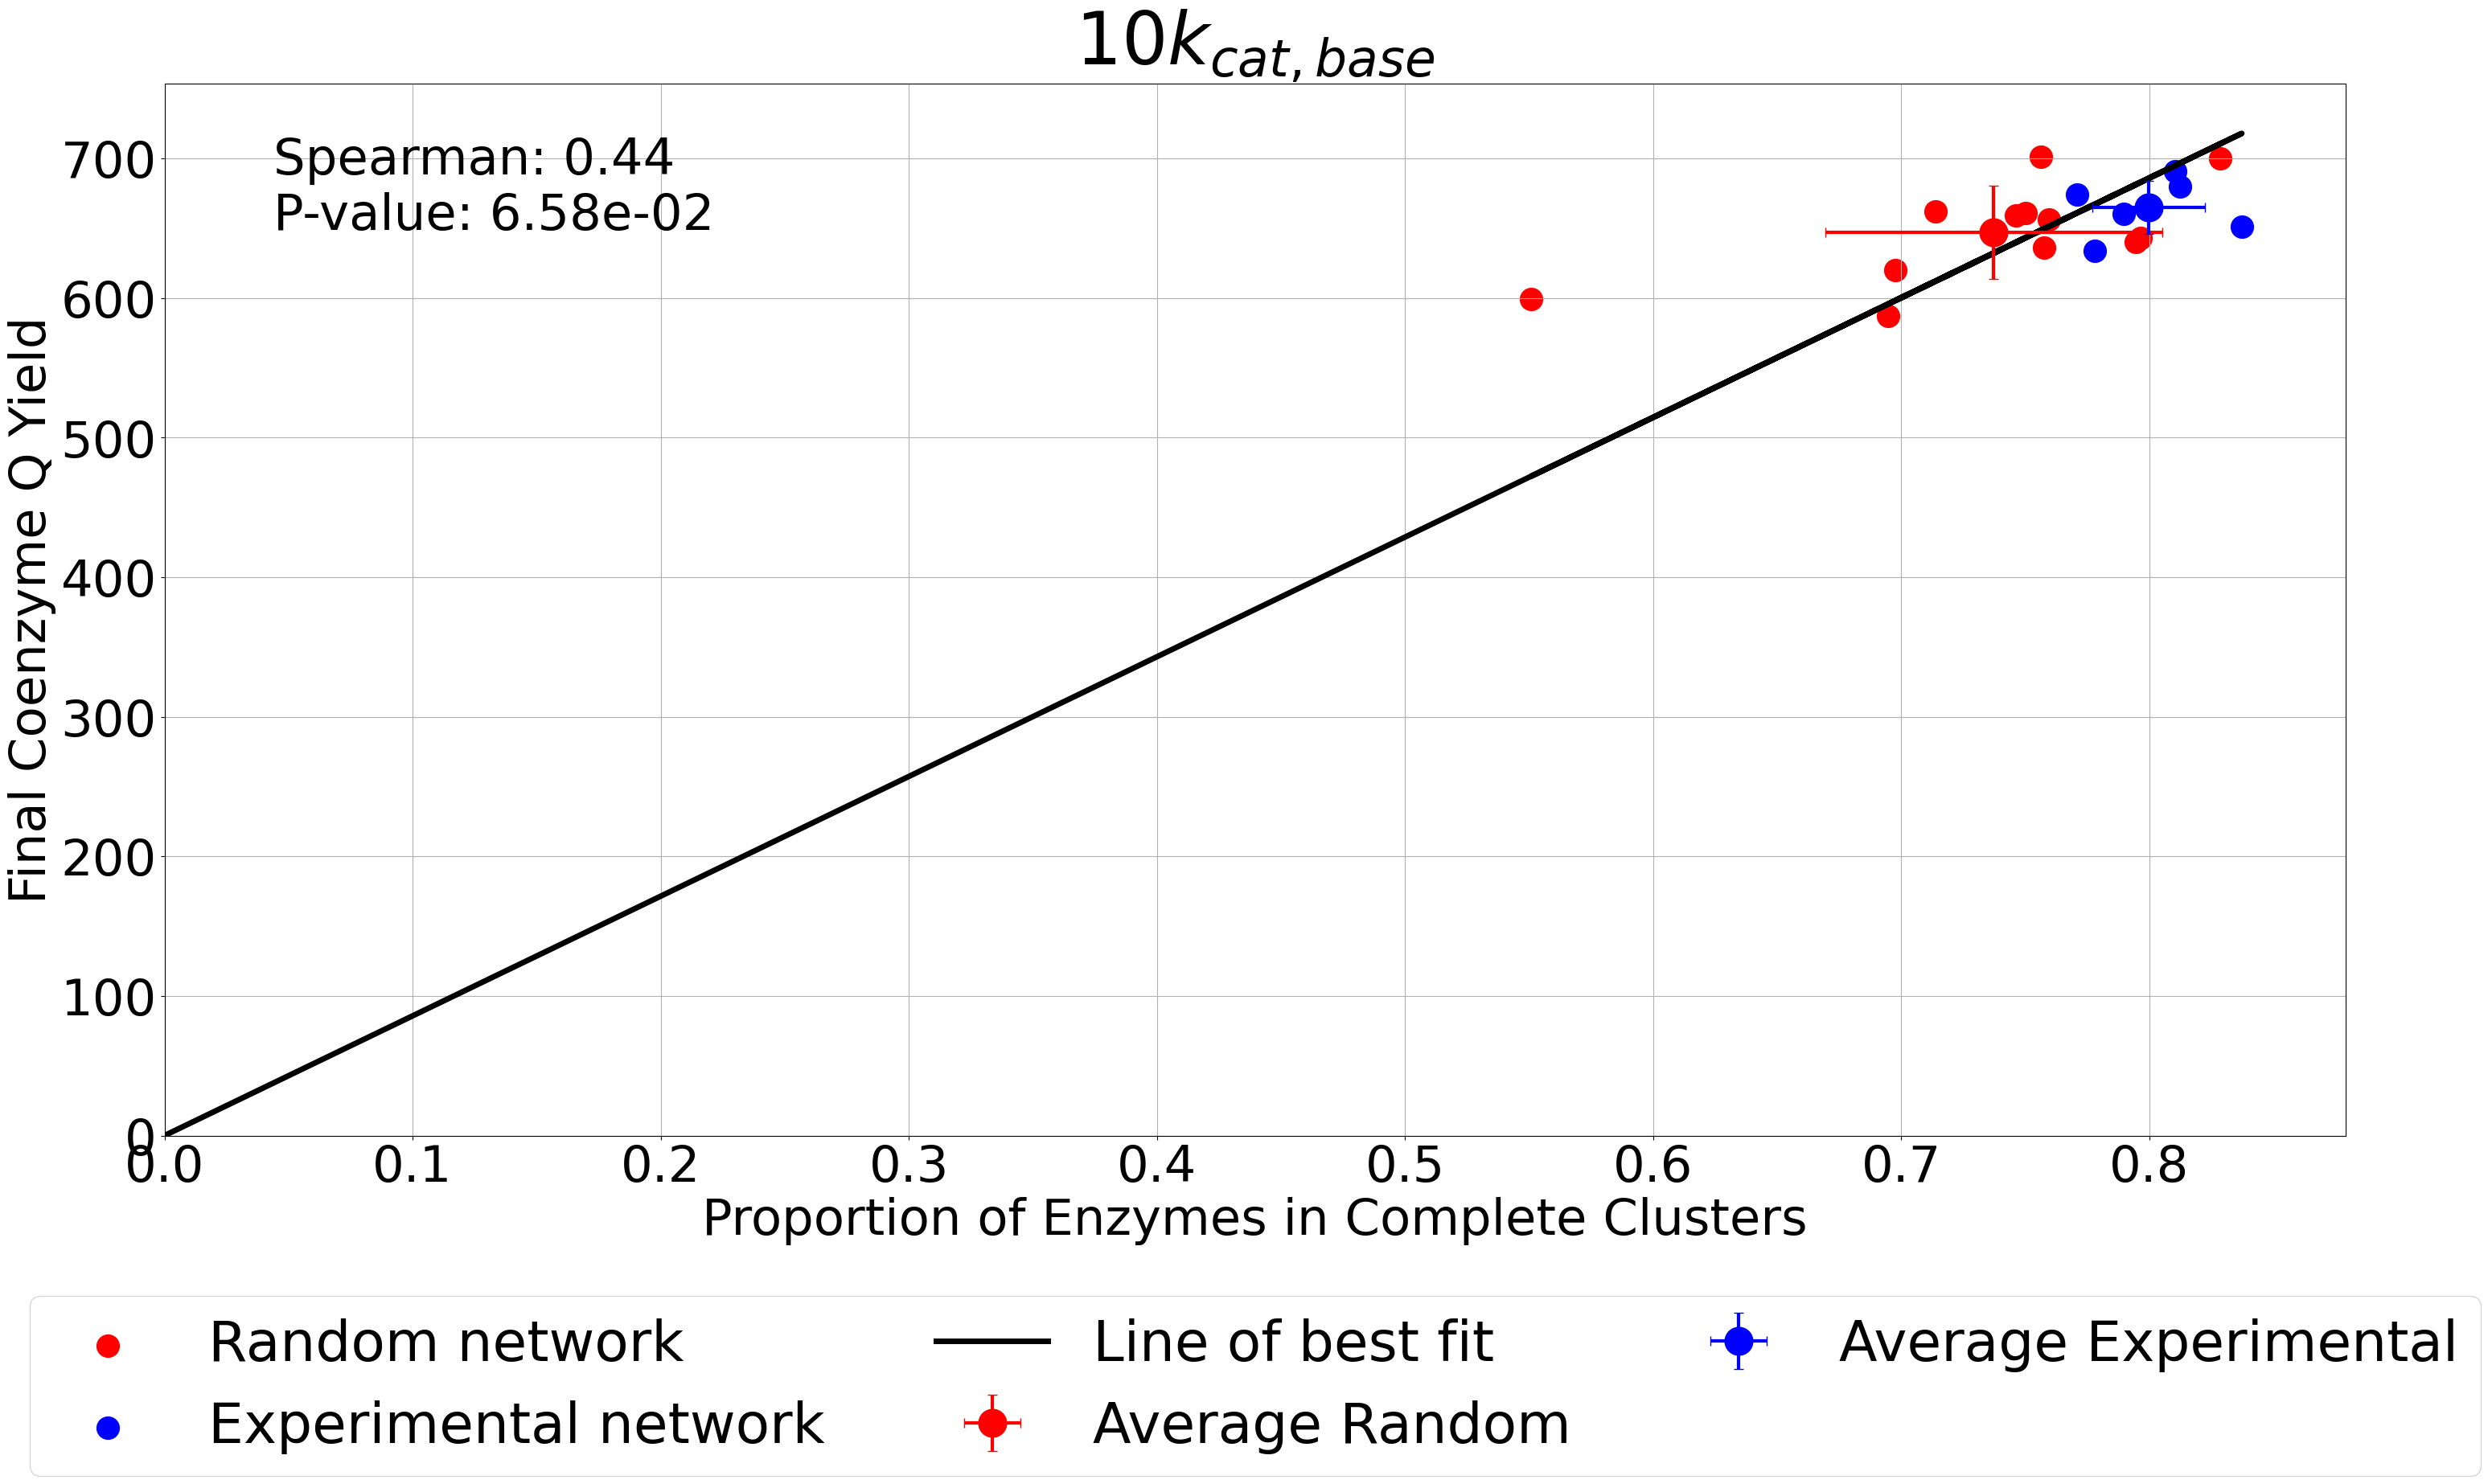

In [49]:
plot_enzyme_number(cc_05kcat_WT, yield_05kat_WT, cc_05kcat_randomized, yield_05kat_randomized, 0.5)
plot_enzyme_number(cc_1kcat_WT, yield_1kat_WT, cc_1kcat_randomized, yield_1kat_randomized, 1)
plot_enzyme_number(cc_2kcat_WT, yield_2kat_WT, cc_2kcat_randomized, yield_2kat_randomized, 2)
plot_enzyme_number(cc_10kcat_WT, yield_10kat_WT, cc_10kcat_randomized, yield_10kat_randomized, 10)


Spearman correlation for combined data: 0.8901935413744744, p-value: 5.756511364659801e-09


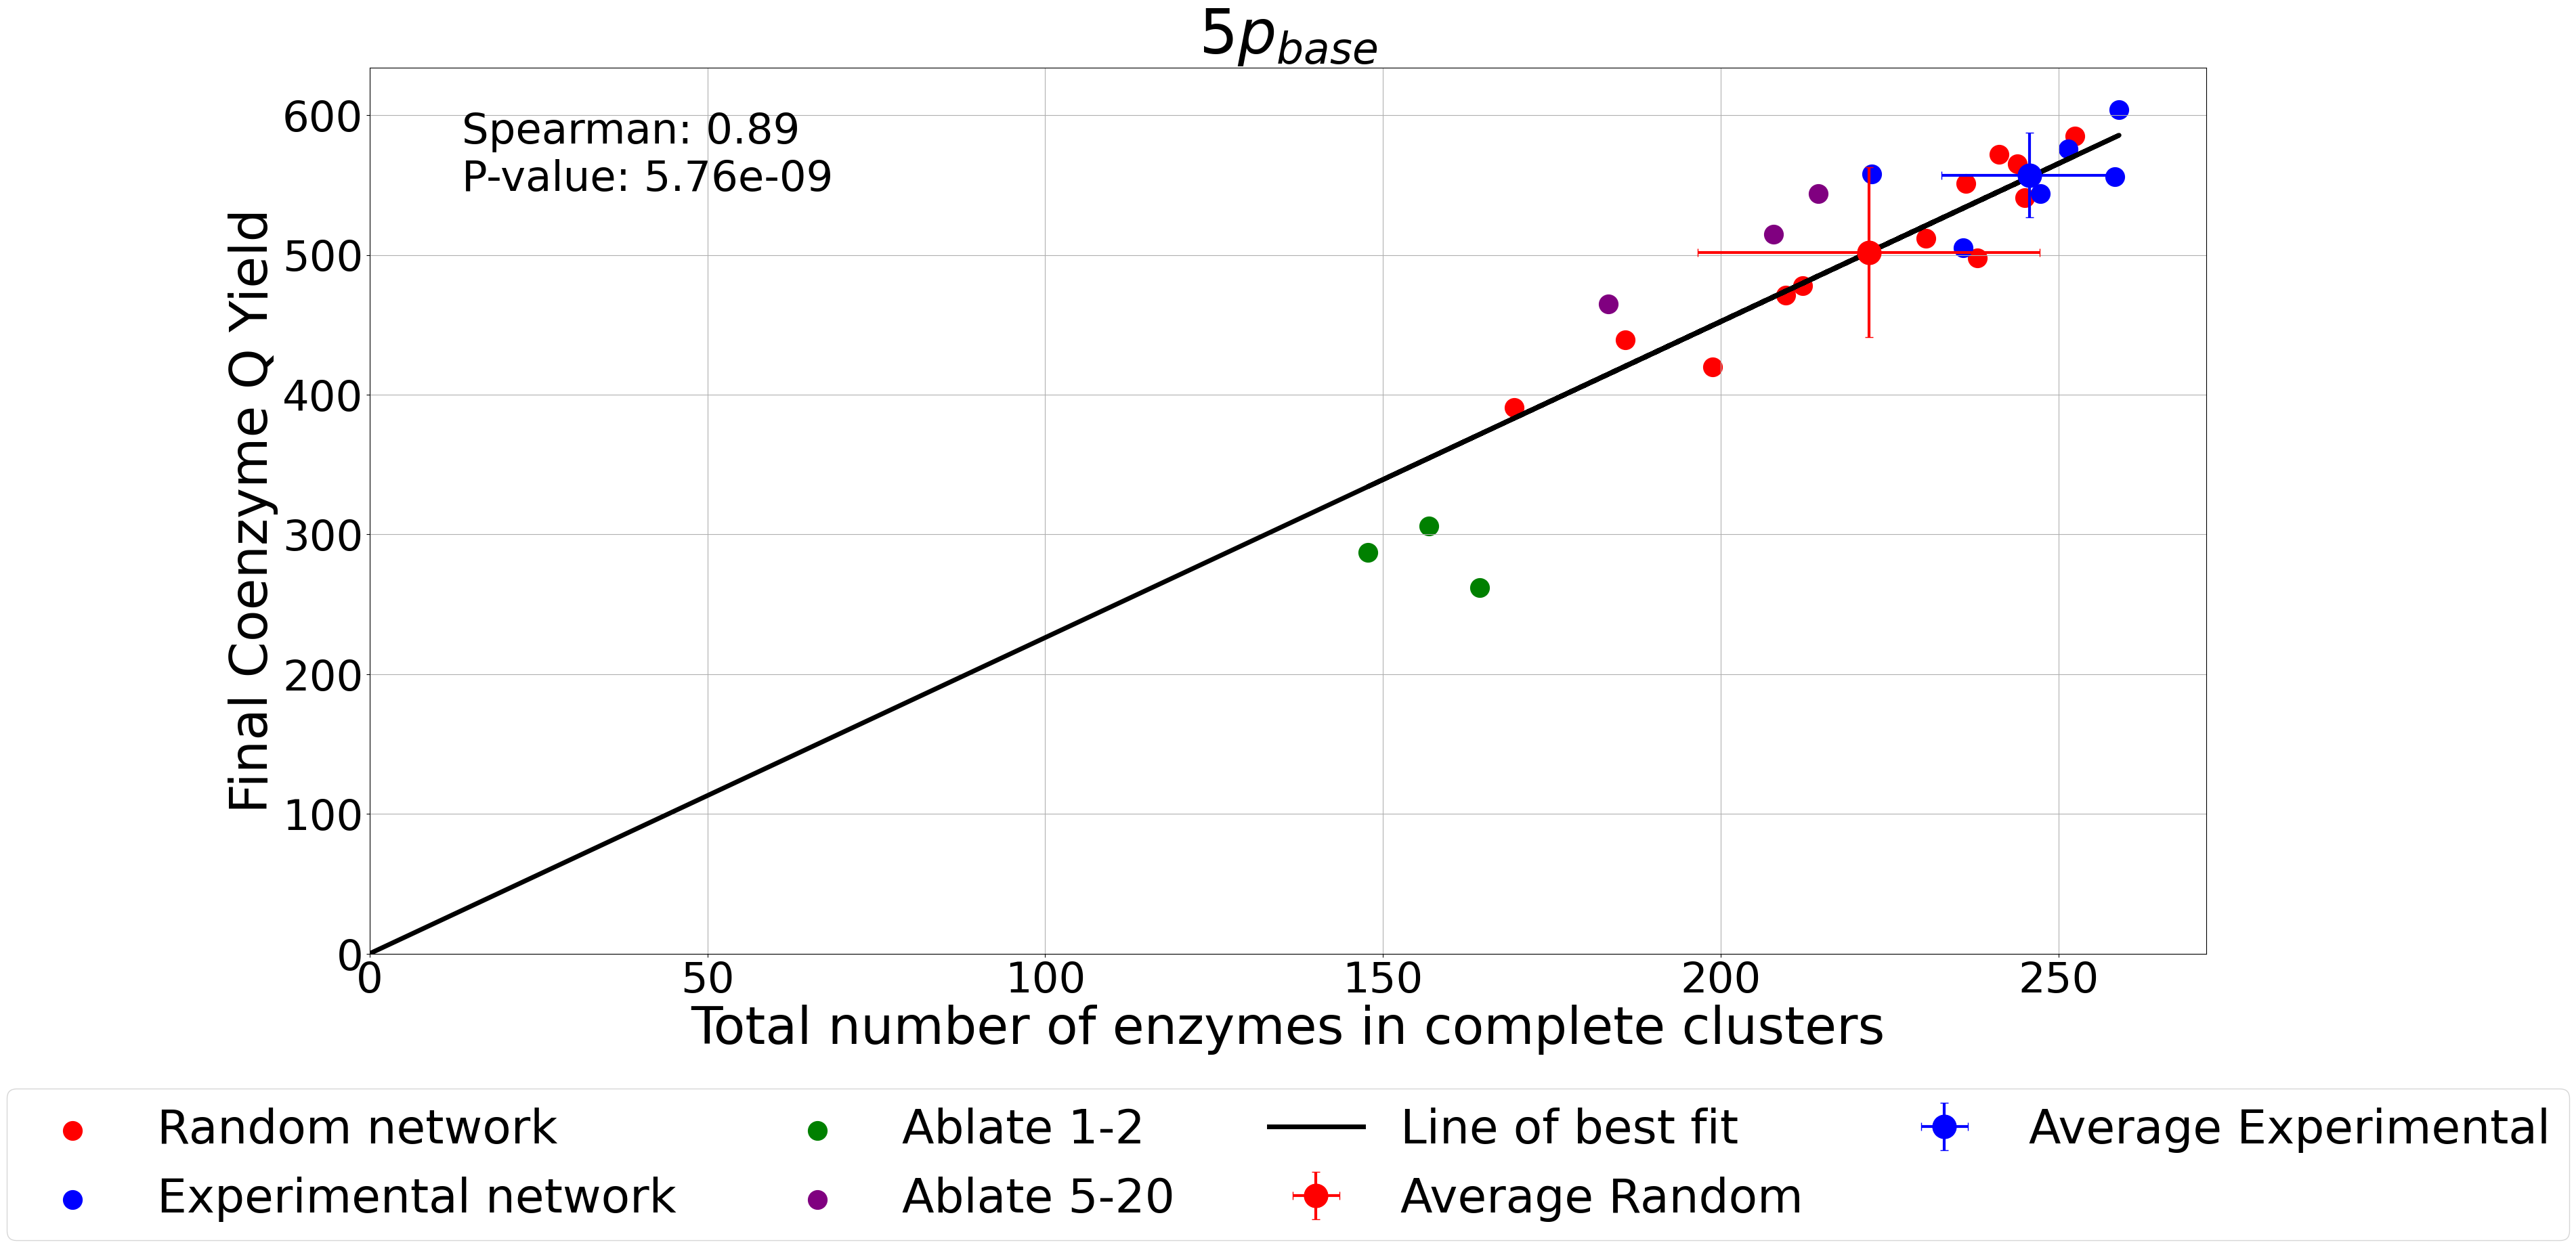

In [51]:
random = cc_5kcat_randomized
random_yield = yield_5kat_randomized
WT = cc_5kcat_WT
WT_yield = yield_5kat_WT
kcat = 5

# Extract the average ClusterSize value from the last 10 rows in each entry in random_complete_clusters
x_values_random = [entry['ClusterSize'].iloc[-10:] for entry in random]
x_values_random = [np.mean(entry) for entry in get_num_enzymes_in_CC(x_values_random)]

# Extract the last f_bondc6[2] value from each entry in random_yield
y_values_random = [entry['f_bondc6[2]'].iloc[-1] for entry in random_yield]

# Extract the average ClusterSize value from the last 10 rows in each entry in control_complete_clusters
x_values_control = [entry['ClusterSize'].iloc[-10:] for entry in WT]
x_values_control = [np.mean(entry) for entry in get_num_enzymes_in_CC(x_values_control)]

# Extract the last f_bondc6[2] value from each entry in control_yield
y_values_control = [entry['f_bondc6[2]'].iloc[-1] for entry in WT_yield]

x_values_ablate_1_2 = [entry['ClusterSize'].iloc[-10:] for entry in cc_5kcat_ablate_1_2]
x_values_ablate_1_2 = [np.mean(entry) for entry in get_num_enzymes_in_CC(x_values_ablate_1_2)]

y_values_ablate_1_2 = [entry['f_bondc6[2]'].iloc[-1] for entry in yield_5kat_ablate_1_2]

x_values_ablate_5_20 = [entry['ClusterSize'].iloc[-10:] for entry in cc_5kcat_ablate_5_20]
x_values_ablate_5_20 = [np.mean(entry) for entry in get_num_enzymes_in_CC(x_values_ablate_5_20)]

y_values_ablate_5_20 = [entry['f_bondc6[2]'].iloc[-1] for entry in yield_5kat_ablate_5_20]

# Combine all x-values and y-values
x_values_combined = x_values_random + x_values_control + x_values_ablate_1_2 + x_values_ablate_5_20
y_values_combined = y_values_random + y_values_control + y_values_ablate_1_2 + y_values_ablate_5_20

# Calculate Spearman correlation for combined data
spearman_combined, p_value_combined = spearmanr(x_values_combined, y_values_combined)
print(f"Spearman correlation for combined data: {spearman_combined}, p-value: {p_value_combined}")

# Calculate line of best fit through the origin
x_values_combined = np.array(x_values_combined).reshape(-1, 1)
y_values_combined = np.array(y_values_combined)
model = LinearRegression(fit_intercept=False)
model.fit(x_values_combined, y_values_combined)
slope = model.coef_[0]
line = slope * np.array(x_values_combined)
line = np.append(line, [[0]], axis=0)

# Calculate mean and standard deviation for random network
mean_x_random = np.mean(x_values_random)
mean_y_random = np.mean(y_values_random)
std_x_random = np.std(x_values_random)
std_y_random = np.std(y_values_random)

# Calculate mean and standard deviation for experimental network
mean_x_control = np.mean(x_values_control)
mean_y_control = np.mean(y_values_control)
std_x_control = np.std(x_values_control)
std_y_control = np.std(y_values_control)

fig, ax = plt.subplots(figsize=(35, 17))
# Plot the values
ax.scatter(x_values_random, y_values_random, color='red', label='Random network', s=400)
ax.scatter(x_values_control, y_values_control, color='blue', label='Experimental network', s=400)
ax.scatter(x_values_ablate_1_2, y_values_ablate_1_2, color='green', label='Ablate 1-2', s=400)  
ax.scatter(x_values_ablate_5_20, y_values_ablate_5_20, color='purple', label='Ablate 5-20', s=400)
ax.plot(np.append(x_values_combined, [[0]], axis=0), line, color='black', label='Line of best fit', linewidth=5)
ax.errorbar(mean_x_random, mean_y_random, xerr=std_x_random, yerr=std_y_random, fmt='o', color='red', ecolor='red', elinewidth=3, capsize=4, label='Average Random', markersize=25)
ax.errorbar(mean_x_control, mean_y_control, xerr=std_x_control, yerr=std_y_control, fmt='o', color='blue', ecolor='blue', elinewidth=3, capsize=4, label='Average Experimental', markersize=25)
ax.set_xlabel('Total number of enzymes in complete clusters', fontsize=55)
ax.set_ylabel('Final Coenzyme Q Yield', fontsize=55)
ax.tick_params(axis='both', which='major', labelsize=45)
ax.set_title(f'{kcat}$p_{{base}}$', fontsize=65)
ax.grid(True)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.text(0.05, 0.95, f'Spearman: {spearman_combined:.2f}\nP-value: {p_value_combined:.2e}', 
        transform=ax.transAxes, fontsize=45, verticalalignment='top')

plt.legend(fontsize=50, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4)
plt.show()

PEG simulations visualization


In [51]:
folder_path = '/n/netscratch/shakhnovich_lab/Lab/jiojeong/simulations/copied_from_local/20241007_metabolon_CoQ9_HSHS1KT_self_interaction_1KT_cognate_patch_ligand_4KT_10_kcat_production_300000000_10000_frames'
path_COQ3PEG = os.path.join(folder_path, 'COQ3PEG')
path_COQ4PEG = os.path.join(folder_path, 'COQ4PEG')
path_COQ5PEG = os.path.join(folder_path, 'COQ5PEG')
path_COQ6PEG = os.path.join(folder_path, 'COQ6PEG')
path_COQ7PEG = os.path.join(folder_path, 'COQ7PEG')
path_COQ9PEG = os.path.join(folder_path, 'COQ9PEG')

paths_COQ3PEG = get_subfolder_paths(path_COQ3PEG)
paths_COQ4PEG = get_subfolder_paths(path_COQ4PEG)
paths_COQ5PEG = get_subfolder_paths(path_COQ5PEG)
paths_COQ6PEG = get_subfolder_paths(path_COQ6PEG)
paths_COQ7PEG = get_subfolder_paths(path_COQ7PEG)
paths_COQ9PEG = get_subfolder_paths(path_COQ9PEG)


paths_WT_for_PEG = get_subfolder_paths('/n/netscratch/shakhnovich_lab/Lab/jiojeong/simulations/copied_from_local/20241003_metabolon_CoQ9_HSHS1KT_self_interaction_1KT_cognate_patch_ligand_4KT_10_kcat_production_300000000_10000_frames/WT')


complete_clusters_exp= read_complete_clusters(paths_WT_for_PEG)
complete_clusters_COQ3_PEG = read_complete_clusters(paths_COQ3PEG)
complete_clusters_COQ4_PEG = read_complete_clusters(paths_COQ4PEG)
complete_clusters_COQ5_PEG = read_complete_clusters(paths_COQ5PEG)
complete_clusters_COQ6_PEG = read_complete_clusters(paths_COQ6PEG)
complete_clusters_COQ7_PEG = read_complete_clusters(paths_COQ7PEG)
complete_clusters_COQ9_PEG = read_complete_clusters(paths_COQ9PEG)

avg_cc_number_exp, stddev_cc_number_exp, avg_cc_size_exp, stddev_cc_size_exp = average_complete_clusters(complete_clusters_exp)
avg_cc_number_COQ3_PEG, stddev_cc_number_COQ3_PEG, avg_cc_size_COQ3_PEG, stddev_cc_size_COQ3_PEG = average_complete_clusters(complete_clusters_COQ3_PEG)
avg_cc_number_COQ4_PEG, stddev_cc_number_COQ4_PEG, avg_cc_size_COQ4_PEG, stddev_cc_size_COQ4_PEG = average_complete_clusters(complete_clusters_COQ4_PEG)
avg_cc_number_COQ6_PEG, stddev_cc_number_COQ6_PEG, avg_cc_size_COQ6_PEG, stddev_cc_size_COQ6_PEG = average_complete_clusters(complete_clusters_COQ6_PEG)
avg_cc_number_COQ9_PEG, stddev_cc_number_COQ9_PEG, avg_cc_size_COQ9_PEG, stddev_cc_size_COQ9_PEG = average_complete_clusters(complete_clusters_COQ9_PEG)
avg_cc_number_COQ5_PEG, stddev_cc_number_COQ5_PEG, avg_cc_size_COQ5_PEG, stddev_cc_size_COQ5_PEG = average_complete_clusters(complete_clusters_COQ5_PEG)
avg_cc_number_COQ7_PEG, stddev_cc_number_COQ7_PEG, avg_cc_size_COQ7_PEG, stddev_cc_size_COQ7_PEG = average_complete_clusters(complete_clusters_COQ7_PEG)

In [52]:

mean_df_10kcat_WT_PEG, var_df_10kcat_WT_PEG = average_runs(paths_WT_for_PEG)
mean_df_10kcat_COQ3_PEG, var_df_10kcat_COQ3_PEG = average_runs(paths_COQ3PEG)
mean_df_10kcat_COQ4_PEG, var_df_10kcat_COQ4_PEG = average_runs(paths_COQ4PEG)
mean_df_10kcat_COQ5_PEG, var_df_10kcat_COQ5_PEG = average_runs(paths_COQ5PEG)
mean_df_10kcat_COQ6_PEG, var_df_10kcat_COQ6_PEG = average_runs(paths_COQ6PEG)
mean_df_10kcat_COQ7_PEG, var_df_10kcat_COQ7_PEG = average_runs(paths_COQ7PEG)
mean_df_10kcat_COQ9_PEG, var_df_10kcat_COQ9_PEG = average_runs(paths_COQ9PEG)

In [53]:
def create_count_dictionary_faster(file_path, target_frame):
    with open(file_path, 'r') as file:
        for line in file:
            # Strip leading/trailing whitespace and split the line into parts
            parts = line.strip().split()
            if parts and parts[0] == str(target_frame):
                # Extract the desired numbers from the line
                desired_numbers = parts[4:11]
                break
    result_dict = {}
    result_dict[18] = int(desired_numbers[-1])
    result_dict[17] = int(desired_numbers[-2]) - result_dict[18]
    result_dict[16] = int(desired_numbers[-3]) - result_dict[17] - result_dict[18]
    result_dict[15] = int(desired_numbers[-4]) - result_dict[16] - result_dict[17] - result_dict[18]
    result_dict[14] = int(desired_numbers[-5]) - result_dict[15] - result_dict[16] - result_dict[17] - result_dict[18]
    result_dict[13] = int(desired_numbers[-6]) - result_dict[14] - result_dict[15] - result_dict[16] - result_dict[17] - result_dict[18]
    result_dict[12] = int(desired_numbers[-7]) - result_dict[13] - result_dict[14] - result_dict[15] - result_dict[16] - result_dict[17] - result_dict[18]
    result_dict[11] = 1000 - result_dict[12] - result_dict[13] - result_dict[14] - result_dict[15] - result_dict[16] - result_dict[17] - result_dict[18]
    return result_dict


def average_counts_atom_type_faster(paths, target_frame):
    result = []
    for path in paths:
        log_file_full_path = os.path.join(path, 'log.lammps')
        temp = create_count_dictionary_faster(log_file_full_path, target_frame)
        result.append(temp)
    
    sum_dict = {}
    sum_of_squares_dict = {}
    count_dict = {}

    # Sum the values and sum of squares for each key
    for d in result:
        for key in d:
            if key in sum_dict:
                sum_dict[key] += d[key]
                sum_of_squares_dict[key] += d[key] ** 2
                count_dict[key] += 1
            else:
                sum_dict[key] = d[key]
                sum_of_squares_dict[key] = d[key] ** 2
                count_dict[key] = 1

    avg_dict = {key: (sum_dict[key] / count_dict[key] if count_dict[key] != 0 else 0) for key in sum_dict}
    stddev_dict = {key: (np.sqrt((sum_of_squares_dict[key] / count_dict[key]) - (avg_dict[key] ** 2)) if count_dict[key] != 0 else 0) for key in sum_dict}

    return avg_dict, stddev_dict

In [54]:
keys_to_plot = [11, 12, 13, 14, 15, 16, 17, 18]

counts_10kcat_WT_PEG, counts_10kcat_WT_PEG_std_dev = average_counts_atom_type_faster(paths_WT_for_PEG, 325000000)
counts_10kcat_COQ3_PEG, counts_10kcat_COQ3_PEG_std_dev = average_counts_atom_type_faster(paths_COQ3PEG, 325000000)
counts_10kcat_COQ4_PEG, counts_10kcat_COQ4_PEG_std_dev = average_counts_atom_type_faster(paths_COQ4PEG, 325000000)
counts_10kcat_COQ5_PEG, counts_10kcat_COQ5_PEG_std_dev = average_counts_atom_type_faster(paths_COQ5PEG, 325000000)
counts_10kcat_COQ6_PEG, counts_10kcat_COQ6_PEG_std_dev = average_counts_atom_type_faster(paths_COQ6PEG, 325000000)
counts_10kcat_COQ7_PEG, counts_10kcat_COQ7_PEG_std_dev = average_counts_atom_type_faster(paths_COQ7PEG, 325000000)
counts_10kcat_COQ9_PEG, counts_10kcat_COQ9_PEG_std_dev = average_counts_atom_type_faster(paths_COQ9PEG, 325000000)


frame_numbers = [175000000, 220000000, 265000000]

# Define the paths for each PEG

# Compute the counts for each PEG and frame number
counts_control = {frame: average_counts_atom_type_faster(paths_WT_for_PEG, frame) for frame in frame_numbers}
counts_COQ3_PEG = {frame: average_counts_atom_type_faster(paths_COQ3PEG,frame) for frame in frame_numbers}
counts_COQ4_PEG = {frame: average_counts_atom_type_faster(paths_COQ4PEG,frame) for frame in frame_numbers}
counts_COQ5_PEG = {frame: average_counts_atom_type_faster(paths_COQ5PEG,frame) for frame in frame_numbers}
counts_COQ6_PEG = {frame: average_counts_atom_type_faster(paths_COQ6PEG,frame) for frame in frame_numbers}
counts_COQ7_PEG = {frame: average_counts_atom_type_faster(paths_COQ7PEG,frame) for frame in frame_numbers}
counts_COQ9_PEG = {frame: average_counts_atom_type_faster(paths_COQ9PEG,frame) for frame in frame_numbers}


values_10kcat = [counts_10kcat_WT_PEG.get(key) for key in keys_to_plot]
values_10kcat_COQ3_PEG = [counts_10kcat_COQ3_PEG.get(key) for key in keys_to_plot]
values_10kcat_COQ4_PEG = [counts_10kcat_COQ4_PEG.get(key) for key in keys_to_plot]
values_10kcat_COQ6_PEG = [counts_10kcat_COQ6_PEG.get(key) for key in keys_to_plot]
values_10kcat_COQ9_PEG = [counts_10kcat_COQ9_PEG.get(key) for key in keys_to_plot]
values_10kcat_COQ5_PEG = [counts_10kcat_COQ5_PEG.get(key) for key in keys_to_plot]
values_10kcat_COQ7_PEG = [counts_10kcat_COQ7_PEG.get(key) for key in keys_to_plot]

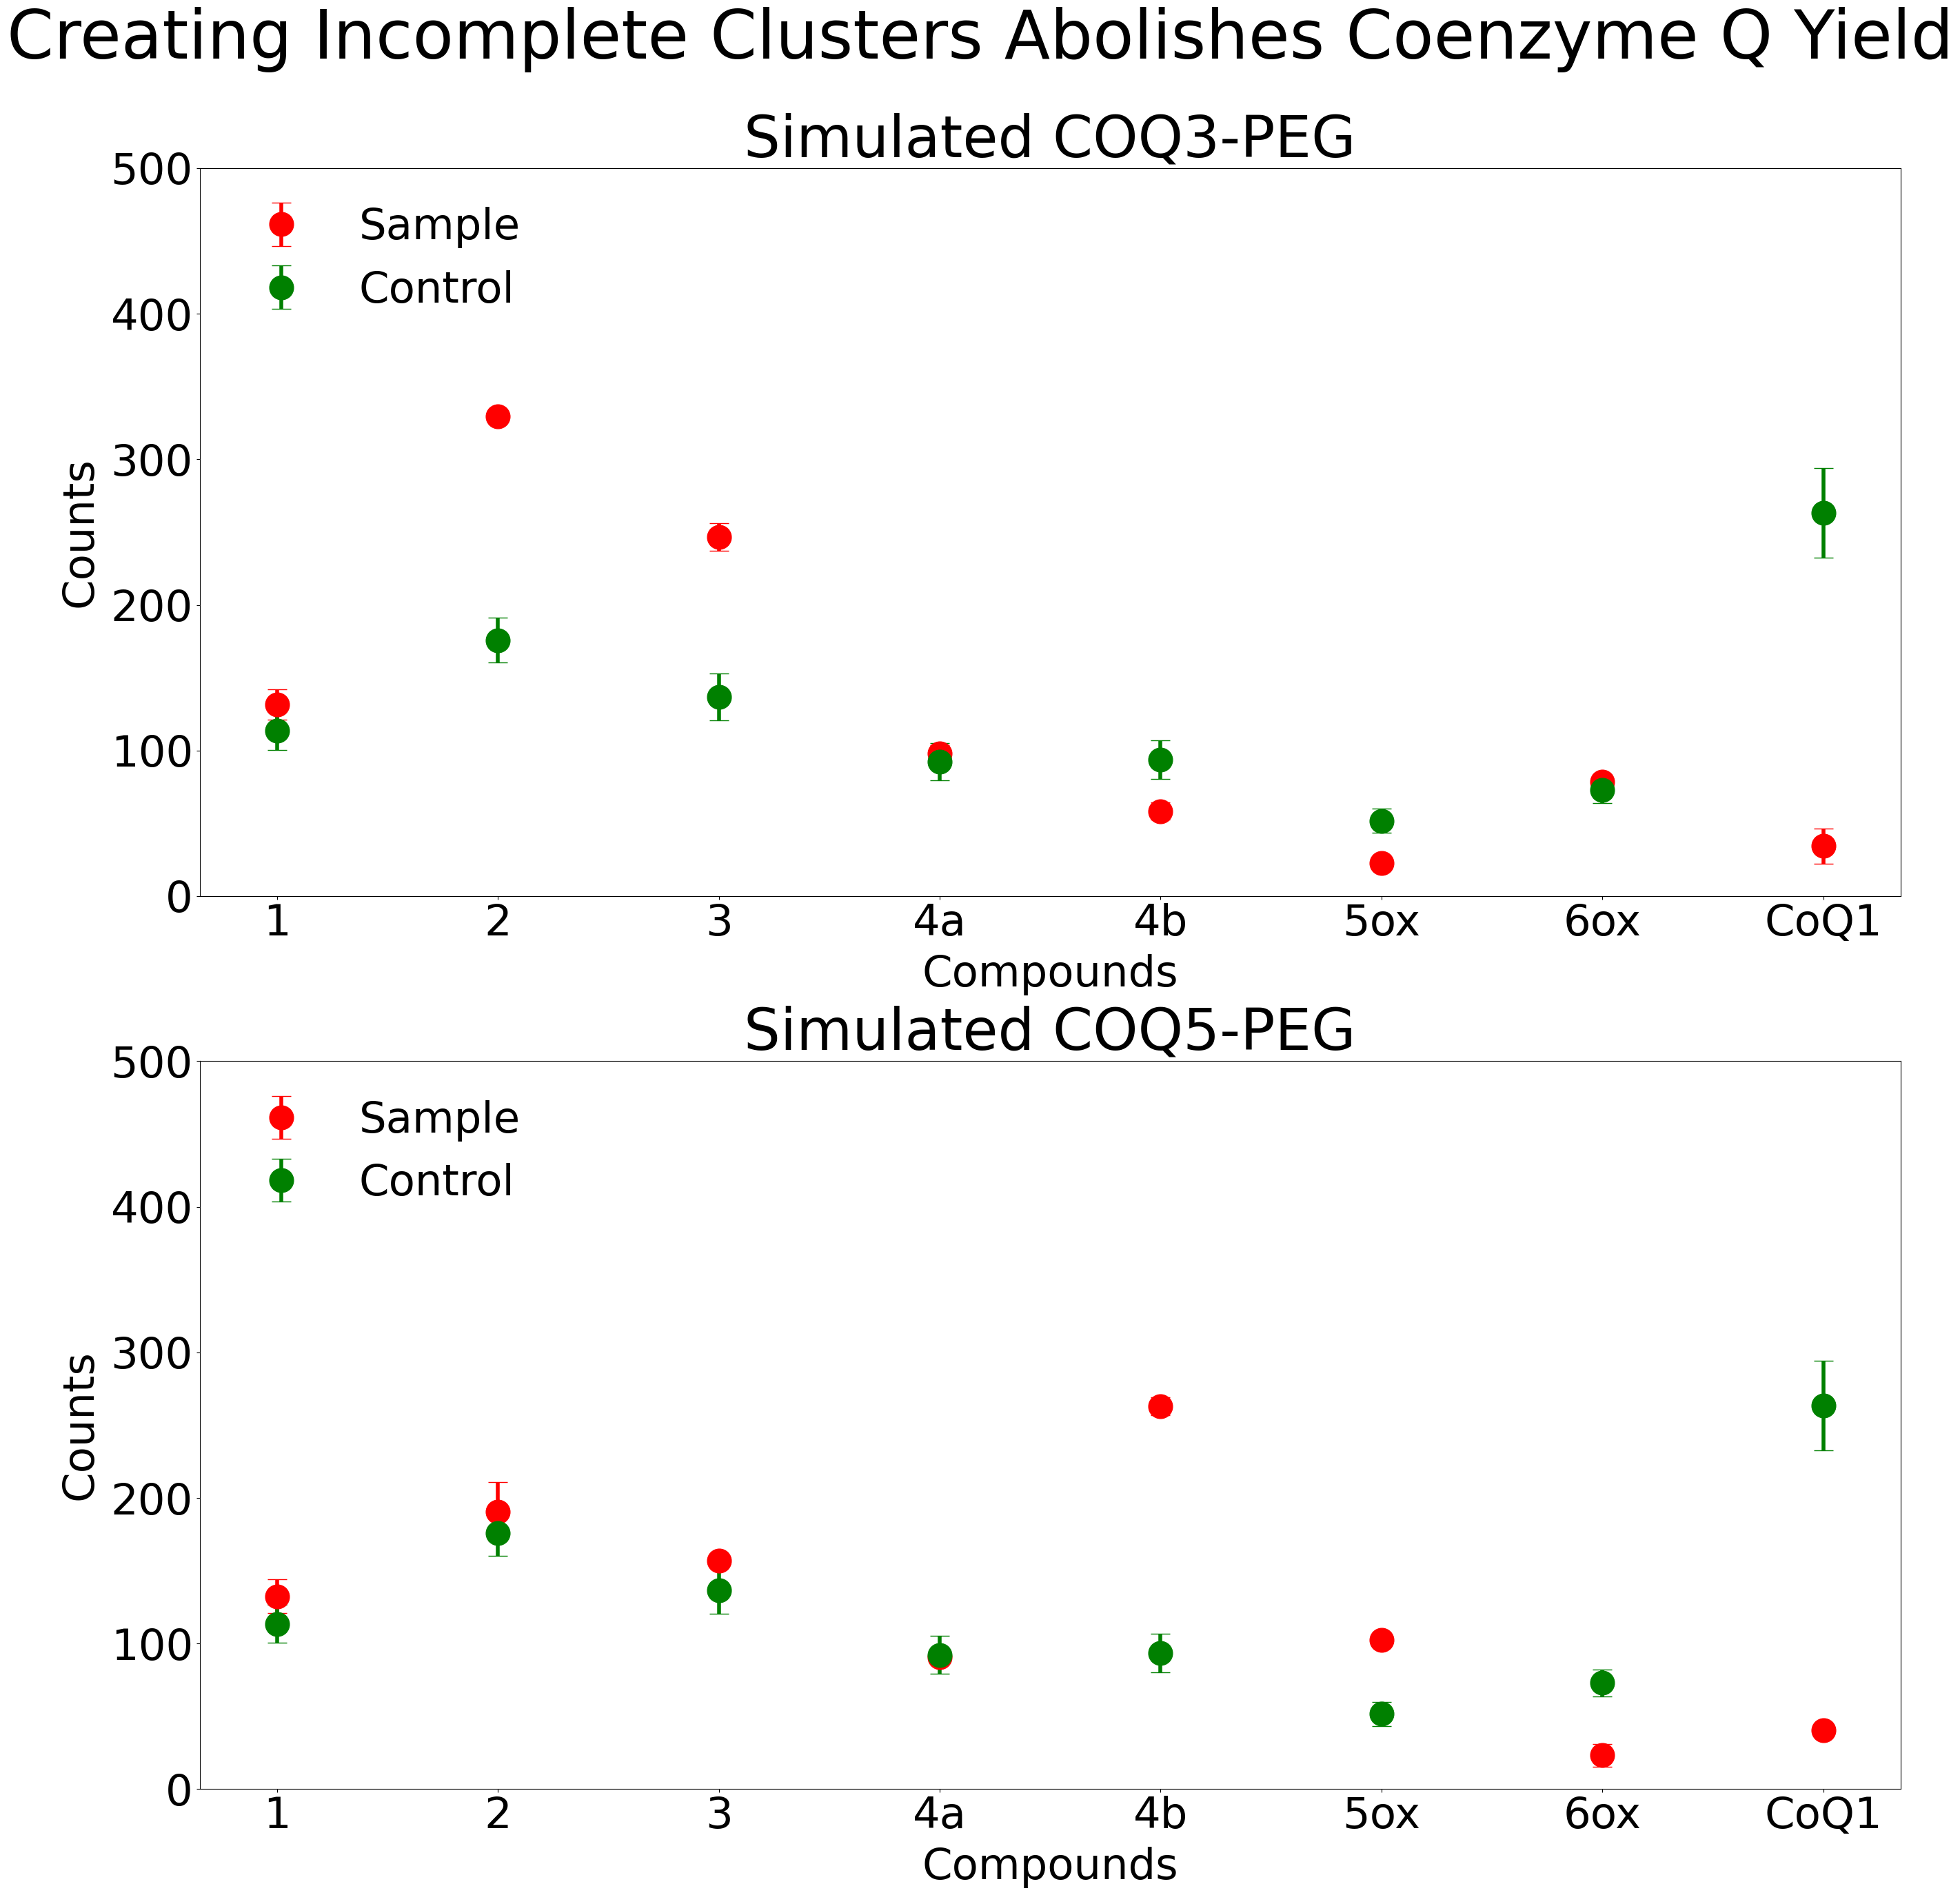

In [55]:
import matplotlib.pyplot as plt

def plot_COQ_PEG(values_control, values_PEG, stddev_control, stddev_PEG, keys_to_plot, custom_labels, title, ax):
    ax.errorbar(keys_to_plot, values_PEG, yerr=stddev_PEG, fmt='o', color='red', label='Sample', markersize=25, capsize=10, elinewidth=4)
    ax.errorbar(keys_to_plot, values_control, yerr=stddev_control, fmt='o', color='green', label='Control', markersize=25, capsize=10, elinewidth=4)
    ax.set_xlabel('Compounds', fontsize=45, labelpad=10)
    ax.set_ylabel('Counts', fontsize=45, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=45)
    ax.set_title(title, fontsize=60, pad=10)
    ax.legend(frameon=False, loc='upper left', fontsize=45)
    ax.grid(False)
    ax.set_ylim(0, 500)
    ax.set_xticks(keys_to_plot)
    ax.set_xticklabels(custom_labels, fontsize=45)

# Assuming exp_counts, COQ3_PEG_counts, stddev_exp_counts, stddev_COQ3_PEG_counts, and keys_to_plot are already defined
values_control_COQ3 = values_10kcat
values_PEG_COQ3 = values_10kcat_COQ3_PEG
stddev_control_COQ3 = [counts_10kcat_WT_PEG_std_dev.get(key, 0) for key in keys_to_plot]
stddev_PEG_COQ3 = [counts_10kcat_COQ3_PEG_std_dev.get(key, 0) for key in keys_to_plot]

values_control_COQ5 = values_10kcat
values_PEG_COQ5 = values_10kcat_COQ5_PEG
stddev_control_COQ5 = [counts_10kcat_WT_PEG_std_dev.get(key, 0) for key in keys_to_plot]
stddev_PEG_COQ5 = [counts_10kcat_COQ5_PEG_std_dev.get(key, 0) for key in keys_to_plot]

# Custom x-axis labels
custom_labels = ['1', '2', '3', '4a', '4b', '5ox', '6ox', 'CoQ1']

# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(27, 28))

# Plot the first set of data
plot_COQ_PEG(values_control_COQ3, values_PEG_COQ3, stddev_control_COQ3, stddev_PEG_COQ3, keys_to_plot, custom_labels, 'Simulated COQ3-PEG', ax1)

# Plot the second set of data
plot_COQ_PEG(values_control_COQ5, values_PEG_COQ5, stddev_control_COQ5, stddev_PEG_COQ5, keys_to_plot, custom_labels, 'Simulated COQ5-PEG', ax2)

# Add a larger title for the entire figure
fig.suptitle('Creating Incomplete Clusters Abolishes Coenzyme Q Yield', fontsize=70)

# Adjust layout to make room for the title
plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.subplots_adjust(hspace=0.2, top=0.9)


# Show the plot
#plt.savefig('fig_COQ_PEG_counts_simulated.png', dpi=600, bbox_inches='tight')
plt.show()

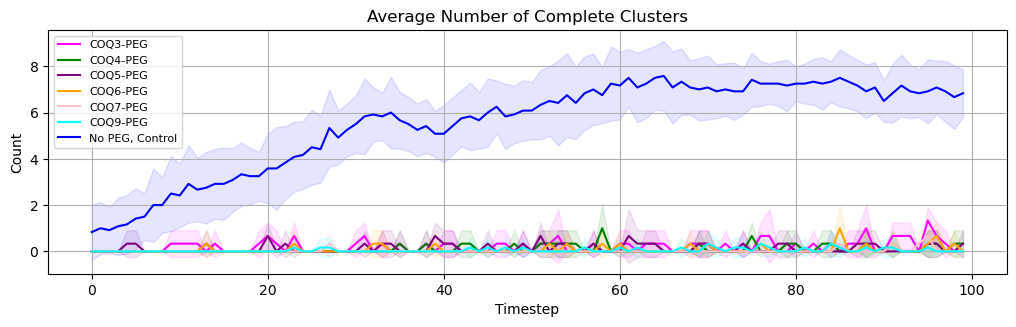

In [62]:
lists = [avg_cc_number_COQ3_PEG, avg_cc_number_COQ4_PEG, avg_cc_number_COQ5_PEG, avg_cc_number_COQ6_PEG, avg_cc_number_COQ7_PEG, avg_cc_number_COQ9_PEG, avg_cc_number_exp]
conditions = ['COQ3-PEG', 'COQ4-PEG', 'COQ5-PEG', 'COQ6-PEG', 'COQ7-PEG', 'COQ9-PEG', 'No PEG, Control']
std_deviation = [stddev_cc_number_COQ3_PEG, stddev_cc_number_COQ4_PEG, stddev_cc_number_COQ5_PEG, stddev_cc_number_COQ6_PEG, stddev_cc_number_COQ7_PEG, stddev_cc_number_COQ9_PEG, stddev_cc_number_exp]
# Specify the columns to plot
columns_to_plot = ['Average Number of Complete Clusters']
colors = ['magenta', 'green', 'purple', 'orange', 'pink', 'cyan', 'blue']
x_values = [range(len(lst)) for lst in lists]

plt.figure(figsize=(20, 12))

for i, col in enumerate(columns_to_plot):
    plt.subplot(4, 2, i + 1)  # Arrange plots in 4x2 grid
    for x, y, condition, std, color in zip(x_values, lists, conditions, std_deviation, colors):
        plt.plot(x, y, label=f'{condition}', color=color)
        # For fill_between, calculate lower and upper bounds using y and std
        lower_bound = [val - s for val, s in zip(y, std)]
        upper_bound = [val + s for val, s in zip(y, std)]
        plt.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.1)
    plt.title(f'{col}')
    plt.xlabel('Timestep')
    plt.ylabel('Count')
    plt.legend(loc = 'upper left', fontsize = 8)
    plt.grid(True)

plt.tight_layout()
#plt.savefig('figure_number_of_CC_PEG.png', dpi=600)
plt.show()


Figure 4a

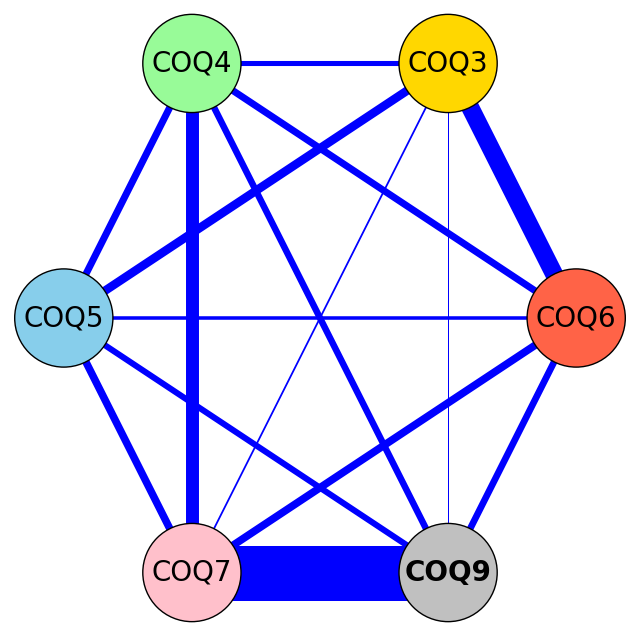

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Node labels and colors
node_labels = {1: "COQ6", 2: "COQ3", 3: "COQ4", 4: "COQ5", 5: "COQ7", 20: "COQ9"}
node_colors = {
    1: "tomato",
    2: "gold",
    3: "palegreen",
    4: "skyblue",
    5: "pink",
    20: "silver"
}

# Interaction data: ((node1, node2), strength)
interactions = [
    ((2, 3), 1.35),
    ((2, 5), 0.80),
    ((3, 4), 1.59),
    ((3, 5), 2.16),
    ((1, 4), 1.13),
    ((4, 5), 1.65),
    ((1, 5), 1.66),
    ((1, 2), 2.54),
    ((1, 3), 1.58),
    ((2, 4), 1.76),
    ((1, 20), 1.55),
    ((2, 20), 0.6),
    ((3, 20), 1.53),
    ((4, 20), 1.48),
    ((5, 20), 4.45)
]

# Create graph and add nodes
G = nx.Graph()
for node, label in node_labels.items():
    G.add_node(node, label=label, color=node_colors[node])

# Add edges with weights (interaction strengths)
for (node1, node2), strength in interactions:
    G.add_edge(node1, node2, weight=strength)

# Hexagon-like custom positions
hexagon_positions = {
    1: np.array([1, 0]),        # COQ6
    2: np.array([0.5, np.sqrt(3)/2]),   # COQ3
    3: np.array([-0.5, np.sqrt(3)/2]),  # COQ4
    4: np.array([-1, 0]),       # COQ5
    5: np.array([-0.5, -np.sqrt(3)/2]), # COQ7
    20: np.array([0.5, -np.sqrt(3)/2])  # COQ9
}

# Normalize positions for better spacing
for key in hexagon_positions:
    hexagon_positions[key] *= 3

n = 2  # Exaggerate differences quadratically

# Scale factor for adjusting overall size
scale_factor = 2

# Compute edge widths using a power function
edge_widths = [scale_factor * (G.edges[edge]["weight"])**n for edge in G.edges]

edge_colors = [
        "blue" if edge == (5, 20) or edge == (20, 5) else "blue" for edge in G.edges
    ]

# Draw the graph using hexagon layout
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, hexagon_positions, node_color=[G.nodes[node]["color"] for node in G.nodes], 
                       node_size=5000, edgecolors="black")

# Draw labels with bold font for COQ9
font_weights = {node: 'bold' if node == 20 else 'normal' for node in G.nodes}
nx.draw_networkx_labels(G, hexagon_positions, labels=node_labels, font_size=20, font_color="black", font_weight=font_weights)

nx.draw_networkx_edges(G, hexagon_positions, width=edge_widths, edge_color=edge_colors)

plt.axis("off")  # Hide axes for a cleaner look
plt.savefig('fig_unshuffled_COQ_network_all_blue.png', dpi=600)
plt.show()


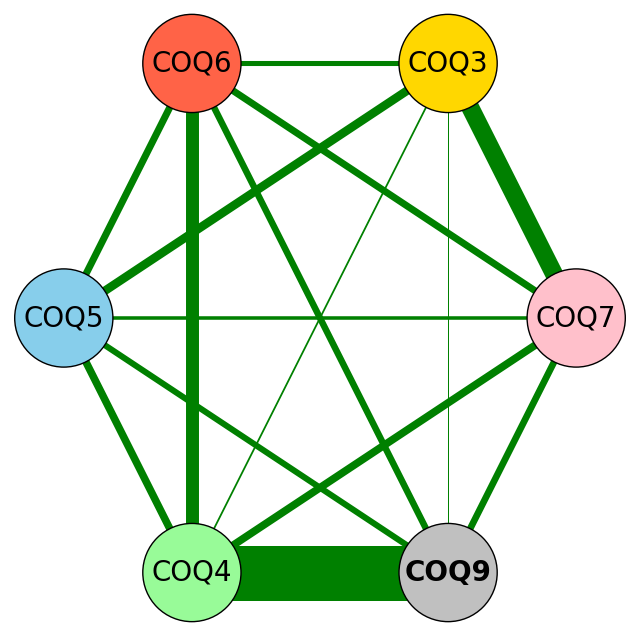

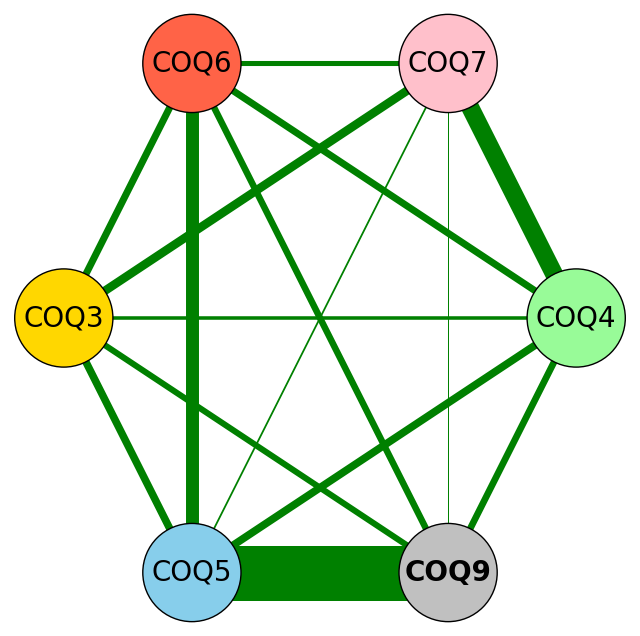

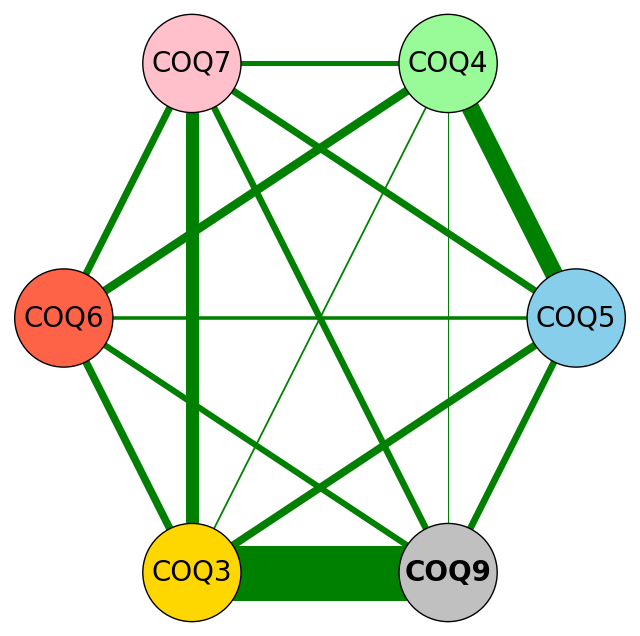

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

for i in range(1, 4):
    # Node labels and colors
    original_labels = {1: "COQ6", 2: "COQ3", 3: "COQ4", 4: "COQ5", 5: "COQ7", 20: "COQ9"}
    node_colors = {
        "COQ6": "tomato",
        "COQ3": "gold",
        "COQ4": "palegreen",
        "COQ5": "skyblue",
        "COQ7": "pink",
        "COQ9": "silver"  # COQ9 remains the same
    }

    # Shuffle labels while keeping COQ9 fixed
    shuffled_keys = list(original_labels.keys())
    shuffled_labels = shuffled_keys[:-1]  # Exclude COQ9 from shuffling
    random.shuffle(shuffled_labels)
    new_labels = {shuffled_keys[i]: original_labels[shuffled_labels[i]] for i in range(len(shuffled_labels))}
    new_labels[20] = "COQ9"  # Keep COQ9 the same

    # Assign colors based on shuffled labels
    shuffled_colors = {node: node_colors[label] for node, label in new_labels.items()}

    # Interaction data: ((node1, node2), strength)
    interactions = [
        ((2, 3), 1.35),
        ((2, 5), 0.80),
        ((3, 4), 1.59),
        ((3, 5), 2.16),
        ((1, 4), 1.13),
        ((4, 5), 1.65),
        ((1, 5), 1.66),
        ((1, 2), 2.54),
        ((1, 3), 1.58),
        ((2, 4), 1.76),
        ((1, 20), 1.55),
        ((2, 20), 0.6),
        ((3, 20), 1.53),
        ((4, 20), 1.48),
        ((5, 20), 4.45)
    ]

    # Create graph and add nodes
    G = nx.Graph()
    for node, label in new_labels.items():
        G.add_node(node, label=label, color=shuffled_colors[node])

    # Add edges with weights (interaction strengths)
    for (node1, node2), strength in interactions:
        G.add_edge(node1, node2, weight=strength)

    # Hexagon-like custom positions
    hexagon_positions = {
        1: np.array([1, 0]),        # COQ6
        2: np.array([0.5, np.sqrt(3)/2]),   # COQ3
        3: np.array([-0.5, np.sqrt(3)/2]),  # COQ4
        4: np.array([-1, 0]),       # COQ5
        5: np.array([-0.5, -np.sqrt(3)/2]), # COQ7
        20: np.array([0.5, -np.sqrt(3)/2])  # COQ9
    }

    # Normalize positions for better spacing
    for key in hexagon_positions:
        hexagon_positions[key] *= 3

    n = 2  # Exaggerate differences quadratically
    scale_factor = 2  # Scale factor for adjusting overall size

    # Compute edge widths using a power function
    edge_widths = [scale_factor * (G.edges[edge]["weight"])**n for edge in G.edges]
    edge_colors = [
            "green" if edge == (5, 20) or edge == (20, 5) else "green" for edge in G.edges
        ]

    plt.figure(figsize=(8, 8))
    font_weights = {node: 'bold' if node == 20 else 'normal' for node in G.nodes}

    nx.draw_networkx_nodes(G, hexagon_positions, node_color=[shuffled_colors[node] for node in G.nodes], 
                            node_size=5000, edgecolors="black")
    nx.draw_networkx_labels(G, hexagon_positions, labels=new_labels, font_size=20, font_color="black", font_weight=font_weights)
    nx.draw_networkx_edges(G, hexagon_positions, width=edge_widths, edge_color=edge_colors)
    plt.axis("off")  # Hide axes for a cleaner look
    plt.savefig(f'fig_shuffled_nodes_COQ_network_{i}.png', dpi=600)
    plt.show()


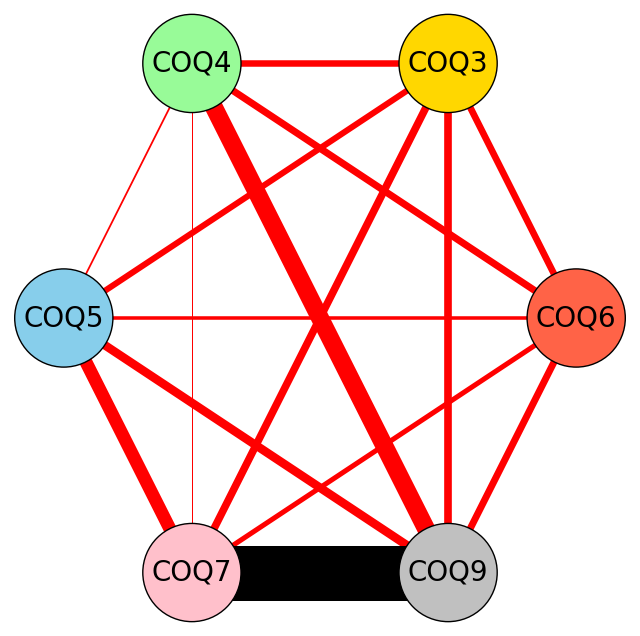

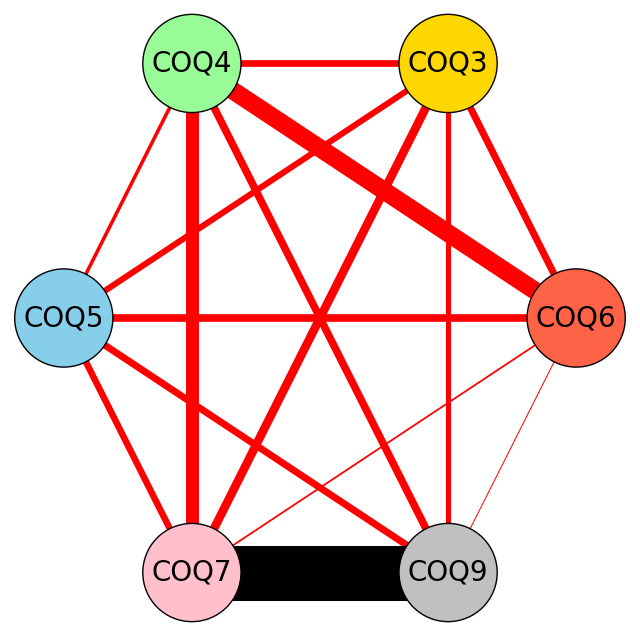

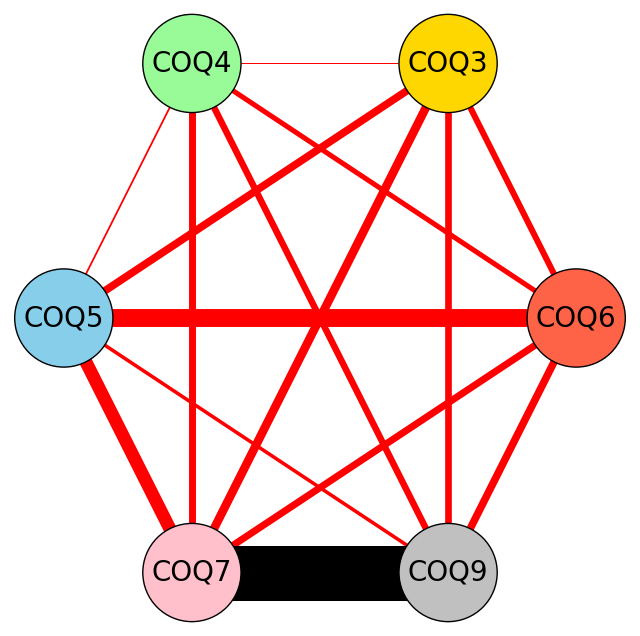

In [65]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

# Node labels and colors
node_labels = {1: "COQ6", 2: "COQ3", 3: "COQ4", 4: "COQ5", 5: "COQ7", 20: "COQ9"}
node_colors = {
    1: "tomato",
    2: "gold",
    3: "palegreen",
    4: "skyblue",
    5: "pink",
    20: "silver"
}

# Interaction data: ((node1, node2), strength)
base_interactions = [
    ((2, 3), 1.35),
    ((2, 5), 0.80),
    ((3, 4), 1.59),
    ((3, 5), 2.16),
    ((1, 4), 1.13),
    ((4, 5), 1.65),
    ((1, 5), 1.66),
    ((1, 2), 2.54),
    ((1, 3), 1.58),
    ((2, 4), 1.76),
    ((1, 20), 1.55),
    ((2, 20), 0.6),
    ((3, 20), 1.53),
    ((4, 20), 1.48),
    ((5, 20), 4.45)  # COQ7-COQ9 fixed strength
]

# Function to shuffle interaction strengths except for COQ7-COQ9
def shuffle_interactions(interactions):
    strengths = [strength for (nodes, strength) in interactions if nodes != (5, 20)]
    random.shuffle(strengths)
    shuffled_interactions = []
    index = 0
    for nodes, strength in interactions:
        if nodes == (5, 20):
            shuffled_interactions.append((nodes, strength))
        else:
            shuffled_interactions.append((nodes, strengths[index]))
            index += 1
    return shuffled_interactions

# Hexagon-like custom positions
hexagon_positions = {
    1: np.array([1, 0]),        # COQ6
    2: np.array([0.5, np.sqrt(3)/2]),   # COQ3
    3: np.array([-0.5, np.sqrt(3)/2]),  # COQ4
    4: np.array([-1, 0]),       # COQ5
    5: np.array([-0.5, -np.sqrt(3)/2]), # COQ7
    20: np.array([0.5, -np.sqrt(3)/2])  # COQ9
}

# Normalize positions for better spacing
for key in hexagon_positions:
    hexagon_positions[key] *= 3

# Function to plot the graph with specified edge colors
def plot_graph_with_red_edges(interactions, index):
    # Create graph and add nodes
    G = nx.Graph()
    for node, label in node_labels.items():
        G.add_node(node, label=label, color=node_colors[node])
    
    # Add edges with weights (interaction strengths)
    for (node1, node2), strength in interactions:
        G.add_edge(node1, node2, weight=strength)
    
    # Edge widths proportional to interaction strength
    n = 2  # Exaggerate differences quadratically

# Scale factor for adjusting overall size
    scale_factor = 2

    # Compute edge widths using a power function
    edge_widths = [scale_factor * (G.edges[edge]["weight"])**n for edge in G.edges]
    edge_colors = [
        "black" if edge == (5, 20) or edge == (20, 5) else "red" for edge in G.edges
    ]

    # Draw the graph using hexagon layout
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, hexagon_positions, 
                           node_color=[G.nodes[node]["color"] for node in G.nodes], 
                           node_size=5000, edgecolors="black")
    nx.draw_networkx_labels(G, hexagon_positions, labels=node_labels, font_size=20, font_color="black")
    nx.draw_networkx_edges(G, hexagon_positions, width=edge_widths, edge_color=edge_colors)

    plt.axis("off")  # Hide axes for a cleaner look
    #plt.savefig(f'fig_shuffled_COQ_network_{index}.png', dpi=600)
    plt.show()

# Plot the 3 shuffled graphs with red edges (except COQ7-COQ9)
for i in range(1, 4):
    shuffled_interactions = shuffle_interactions(base_interactions)
    plot_graph_with_red_edges(shuffled_interactions, i)
